In [1]:
import pandas as pd
import os
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
from tabulate import tabulate

import sys
sys.path.append('../')

from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utilities import data, roc, threshold

## directory where results are
CHANSEY_ROOT = "W:"
EXPERIMENT_DIR = f"{CHANSEY_ROOT}/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
NLST_PREDS = f"{TEAMS_DIR}/nlst" ## Comment out if not using Teams backup (aka Chansey is up :)
RESULTS_DIR = f"{TEAMS_DIR}/fairness-analysis-results"
FIG_DIR = f"{TEAMS_DIR}/figs"
TAB_DIR = f"{TEAMS_DIR}/tables"

In [2]:
COL_TO_MODEL = {
    "DL_cal": "Venkadesh",
    "Ensemble_Kiran_cal": "Venkadesh", ## DLCST
    "thijmen_mean_cal": "De Haas Combined", ## DLCST
    "Thijmen_mean_cal": "De Haas Combined",
    "Thijmen_local_cal": "De Haas Local",
    "Thijmen_global_hidden_cal": "De Haas Global (Hidden Nodule)",
    "Thijmen_global_show_cal": "De Haas Global (Shown Nodule)",
    "sybil_year1": "Sybil (Year 1)",
    "PanCan2b": "PanCan2b",
}

In [3]:
nlst_preds_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov4_allmodels_cal.csv")
nlst_preds_nodule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 131 entries, PatientID to SliceCount
dtypes: bool(27), float64(86), int64(12), object(6)
memory usage: 13.2+ MB


In [4]:
with open(f'{NLST_PREDS}/nlst_demo_v4_cols.json') as json_data:
    nlst_democols_og = json.load(json_data)
    json_data.close()

nlst_democols_og

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'nodule': ['CoordX', 'CoordZ', 'CoordY', 'Mean_Entropy_Kiran'],
  'other': ['NoduleCounts', 'Diameter_mm', 'SliceCount']},
 'cat': {'demo': ['Overweight',
   'educat',
   'Gender',
   'Married',
   'HighSchoolPlus',
   'NonHispanicWhite',
   'Unfinished_ed',
   'WhiteOrBlack',
   'marital',
   'ethnic',
   'race'],
  'smoke': ['smokelive', 'cigar', 'cigsmok', 'smokework', 'pipe'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'diaghype',
   'diagchro'],
  'canchist': ['canckidn',
   'cancphar',
   'ca

### Check skew numerical cols (Mean vs. Median)

BMI


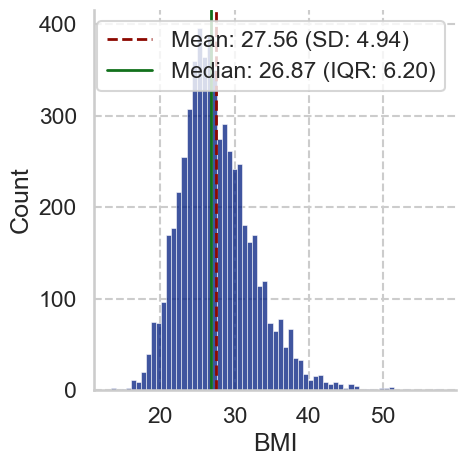

Age


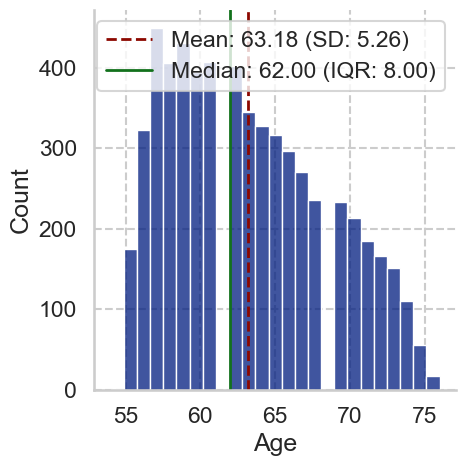

height


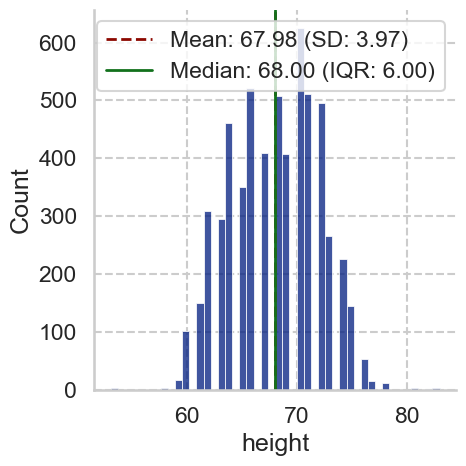

weight


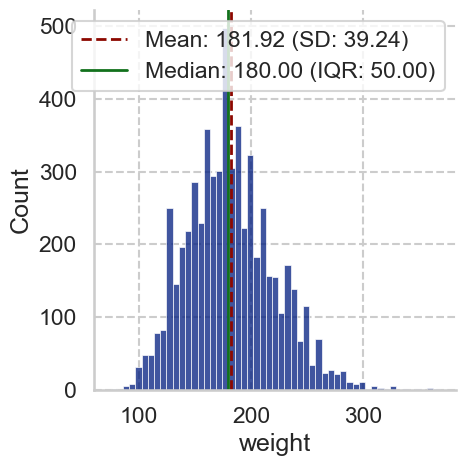

smokeage


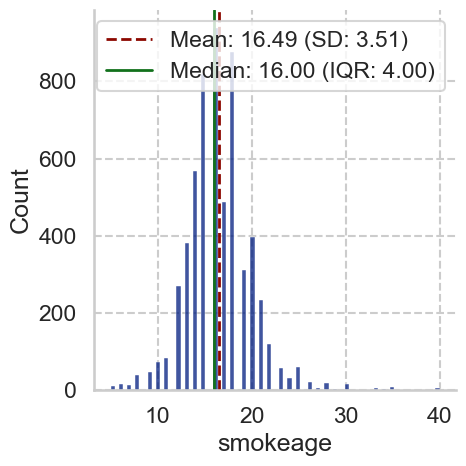

smokeday


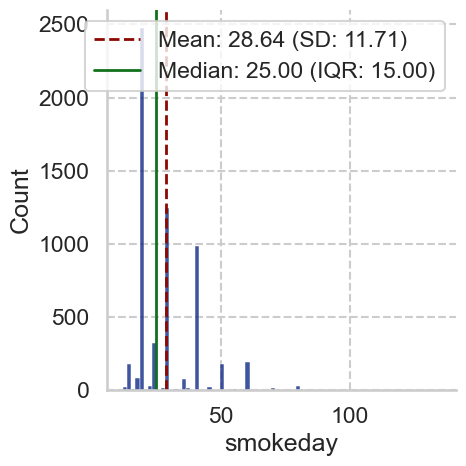

smokeyr


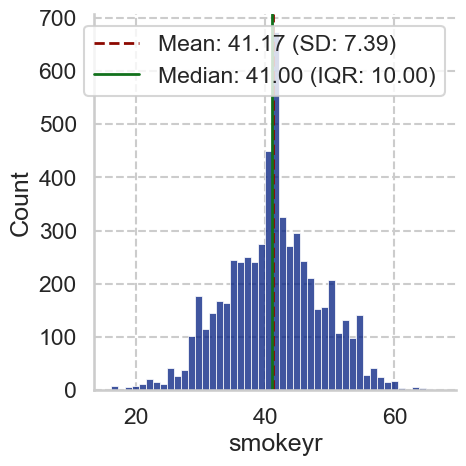

pkyr


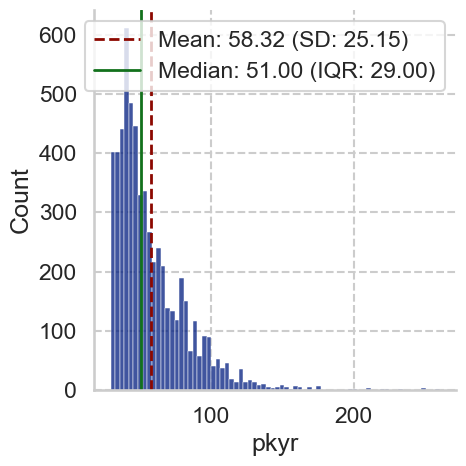

NoduleCounts


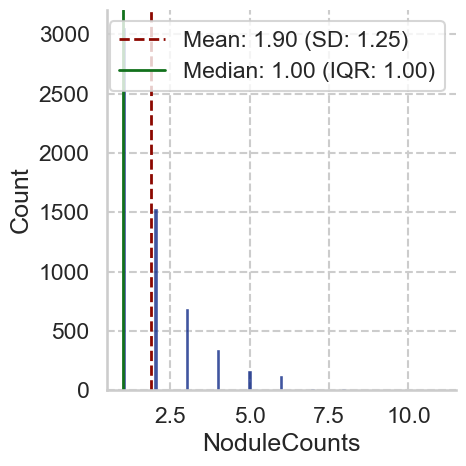

Diameter_mm


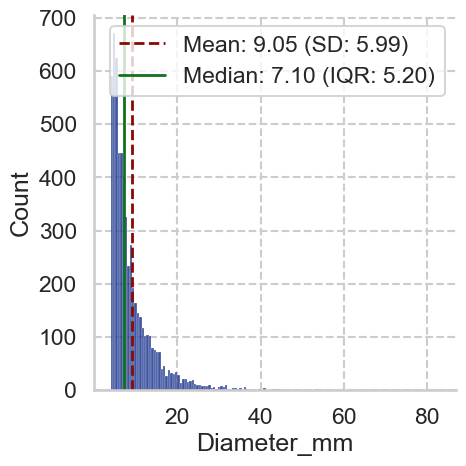

SliceCount


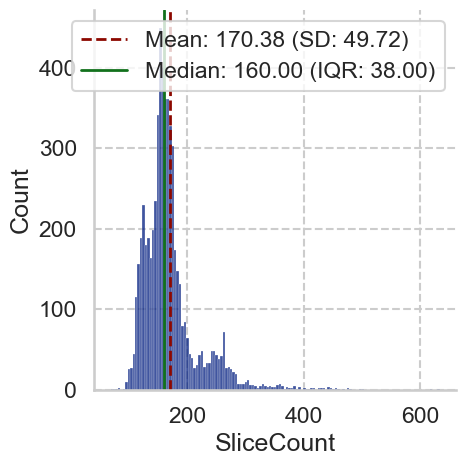

In [5]:
nlst_scan_test, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=False, bin_num=False)
for category in nlst_democols_og['num']:
    if category == 'nodule':
        continue
    for col in nlst_democols_og['num'][category]:
        print(col)
        sns.displot(nlst_scan_test, x=col)
        # Calculate mean and median
        mean = np.nanmean(nlst_scan_test[col])
        median = np.nanmedian(nlst_scan_test[col])
        std = np.nanstd(nlst_scan_test[col])
        iqr = nlst_scan_test[col].quantile(0.75) - nlst_scan_test[col].quantile(0.25)

        # Add vertical lines for mean and median
        plt.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f} (SD: {std:.2f})')
        plt.axvline(median, color='g', linestyle='-', label=f'Median: {median:.2f} (IQR: {iqr:.2f})')

        # Add a legend
        plt.legend()
        plt.show()

# Materials

## Demographic characteristics of the NLST validation sets (n=5911 scans, n=1172 scans).

In [6]:
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
nlst_1172, nlst_democols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=True, sybil=True, pretty=True, bin_num=False)
len(nlst_5911), len(nlst_1172)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


(5911, 1172)

In [7]:
nlstval_full_mal = nlst_5911.query('label == 1')
nlstval_full_ben = nlst_5911.query('label == 0')
print('full:', len(nlstval_full_ben), 'ben', len(nlstval_full_mal), 'mal')

nlstval_some_mal = nlst_1172.query('label == 1')
nlstval_some_ben = nlst_1172.query('label == 0')
print('some:', len(nlstval_some_ben), 'ben', len(nlstval_some_mal), 'mal')

full: 5330 ben 581 mal
some: 1045 ben 127 mal


In [8]:
validation_sets = {
    "Full (malignant)": nlstval_full_mal,
    "Full (benign)": nlstval_full_ben,
    # "Full (all)": nlst_5911,
    "Partial (malignant)": nlstval_some_mal,
    "Partial (benign)": nlstval_some_ben,
    # "Partial (all)": nlst_1172,
}

In [9]:
cat_df0 = data.combine_diff_dfs(nlst_democols['cat'], data.diffs_category_prevalence, validation_sets)
cat_df = cat_df0.copy(deep=True)
for s in validation_sets:
    cat_df[f"{s}_info"] = cat_df.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

cat_df = cat_df[['category', 'attribute', 'value'] + [f"{s}_info" for s in validation_sets]].dropna(axis=0)
cat_df = cat_df.set_index(pd.MultiIndex.from_frame(cat_df[['category', 'attribute', 'value']]))[[f"{s}_info" for s in validation_sets]]

In [10]:
MIN_MAL = 15
attribute_valid_subgroups_1172 = cat_df0[cat_df0['Partial (malignant)_freq'] > 15][['attribute', 'value', 'Partial (malignant)_freq']].groupby('attribute')['value'].count()
invalid_attributes_1172 = list(attribute_valid_subgroups_1172[attribute_valid_subgroups_1172 < 2].index)

attribute_valid_subgroups_5911 = cat_df0[cat_df0['Full (malignant)_freq'] > 15][['attribute', 'value', 'Partial (malignant)_freq']].groupby('attribute')['value'].count()
invalid_attributes_5911 = list(attribute_valid_subgroups_5911[attribute_valid_subgroups_5911 < 2].index)

total_categorical_columns = cat_df0['attribute'].nunique()
print("invalid:", len(invalid_attributes_5911), len(invalid_attributes_1172))
print("valid:", total_categorical_columns - len(invalid_attributes_5911), total_categorical_columns - len(invalid_attributes_1172))

invalid: 36 59
valid: 49 26


In [11]:
num_df = data.combine_diff_dfs(nlst_democols['num'], data.diffs_numerical_means, validation_sets)
num_df = num_df[(num_df['value'].isin(['Median (IQR)']))][['category', 'attribute', 'value'] + [f"{s}" for s in validation_sets]].dropna(axis=0)
num_df = num_df.set_index(pd.MultiIndex.from_frame(num_df[['category', 'attribute', 'value']]))[[f"{s}" for s in validation_sets]]

In [12]:
multicol_idx = pd.MultiIndex.from_tuples([
    ('Full Dataset (n=5911 Scans)', 'Malignant (n=581)'),
    ('Full Dataset (n=5911 Scans)', 'Benign (n=5330)'),
    # ('Full Dataset (n=5911 Scans)', 'Total'),
    ('Partial Dataset (n=1172 Scans)', 'Malignant (n=127)'),
    ('Partial Dataset (n=1172 Scans)', 'Benign (n=1045)'),
    # ('Partial Dataset (n=1172 Scans)', 'Total'),
])

cat_df.columns = multicol_idx
num_df.columns = multicol_idx

In [13]:
df_out = pd.concat([cat_df, num_df], axis=0)
df_out

Full Dataset (n=5911 Scans)  \
                                                                Malignant (n=581)   
category     attribute              value                                           
Demographics BMI Class              25 or Above                        372 (64.0)   
                                    Below 25                           209 (36.0)   
             Education Status       8th grade or less                     9 (1.5)   
                                    9th-11th grade                       32 (5.5)   
                                    Associate Degree                   126 (21.7)   
...                                                                           ...   
Smoking      Total Years of Smoking Median (IQR)                          44 (10)   
             Pack-Years             Median (IQR)                          56 (39)   
Other        Nodules Per Scan       Median (IQR)                            2 (2)   
             Diameter (mm)          Median (IQR)                           12 (9)   
             Slices In Scan         Median (IQR)                         162 (40)   

                                                                       \
                                                      Benign (n=5330)   
category     attribute              value                               
Demographics BMI Class              25 or Above           3640 (68.3)   
                                    Below 25              1690 (31.7)   
             Education Status       8th grade or less       102 (1.9)   
                                    9th-11th grade          258 (4.8)   
                                    Associate Degree      1175 (22.0)   
...                                                               ...   
Smoking      Total Years of Smoking Median (IQR)              41 (10)   
             Pack-Years             Median (IQR)              50 (28)   
Other        Nodules Per Scan       Median (IQR)                1 (1)   
             Diameter (mm)          Median (IQR)                6 (4)   
             Slices In Scan         Median (IQR)             160 (38)   

                                                      Partial Dataset (n=1172 Scans)  \
                                                                   Malignant (n=127)   
category     attribute              value                                              
Demographics BMI Class              25 or Above                            82 (64.6)   
                                    Below 25                               45 (35.4)   
             Education Status       8th grade or less                        4 (3.1)   
                                    9th-11th grade                           2 (1.6)   
                                    Associate Degree                       31 (24.4)   
...                                                                              ...   
Smoking      Total Years of Smoking Median (IQR)                             44 (10)   
             Pack-Years             Median (IQR)                             64 (35)   
Other        Nodules Per Scan       Median (IQR)                               2 (1)   
             Diameter (mm)          Median (IQR)                              11 (9)   
             Slices In Scan         Median (IQR)                            162 (43)   

                                                                       
                                                      Benign (n=1045)  
category     attribute              value                              
Demographics BMI Class              25 or Above            719 (68.8)  
                                    Below 25               326 (31.2)  
             Education Status       8th grade or less        23 (2.2)  
                                    9th-11th grade           65 (6.2)  
                                    Associate Degree       213 (20.4)  
...                            

In [14]:
df_out[('Partial Dataset (n=1172 Scans)', 'Malignant (n=127)')]

category      attribute               value            
Demographics  BMI Class               25 or Above          82 (64.6)
                                      Below 25             45 (35.4)
              Education Status        8th grade or less      4 (3.1)
                                      9th-11th grade         2 (1.6)
                                      Associate Degree     31 (24.4)
                                                             ...    
Smoking       Total Years of Smoking  Median (IQR)           44 (10)
              Pack-Years              Median (IQR)           64 (35)
Other         Nodules Per Scan        Median (IQR)             2 (1)
              Diameter (mm)           Median (IQR)            11 (9)
              Slices In Scan          Median (IQR)          162 (43)
Name: (Partial Dataset (n=1172 Scans), Malignant (n=127)), Length: 217, dtype: object

In [15]:
df_out2 = df_out.xs('Demographics', level='category')
df_out2

Full Dataset (n=5911 Scans)  \
                                                         Malignant (n=581)   
attribute                  value                                             
BMI Class                  25 or Above                          372 (64.0)   
                           Below 25                             209 (36.0)   
Education Status           8th grade or less                       9 (1.5)   
                           9th-11th grade                         32 (5.5)   
                           Associate Degree                     126 (21.7)   
                           Bachelors Degree                      96 (16.5)   
                           Graduate School                       76 (13.1)   
                           HS Graduate / GED                    141 (24.3)   
                           Post-HS training                      87 (15.0)   
Gender                     Female                               244 (42.0)   
                           Male                                 337 (58.0)   
Married                    False                                197 (33.9)   
                           True                                 384 (66.1)   
HS Education               False                                   9 (1.5)   
                           True                                 572 (98.5)   
Non-Hispanic White         False                                  55 (9.5)   
                           True                                 526 (90.5)   
Unfinished Education Level False                                423 (72.8)   
                           True                                 158 (27.2)   
White or Black             Black                                  28 (4.8)   
                           White                                530 (91.2)   
Marital Status             Divorced                             125 (21.5)   
                           Married                              384 (66.1)   
                           Never Married                          16 (2.8)   
                           Separated                               5 (0.9)   
                           Widowed                                49 (8.4)   
Ethnicity                  Hispanic/Latino                         4 (0.7)   
                           Not Hispanic/Latino                  574 (98.8)   
Race                       Asian                                   6 (1.0)   
                           Black                                  28 (4.8)   
                           More than one race                      6 (1.0)   
                           Native American                         8 (1.4)   
                           Native Hawaiian                         1 (0.2)   
                           White                                530 (91.2)   
BMI                        Median (IQR)                             26 (4)   
Age                        Median (IQR)                             64 (8)   
Height                     Median (IQR)                             68 (6)   
Weight                     Median (IQR)                           175 (50)   

                                                                \
                                               Benign (n=5330)   
attribute                  value                                 
BMI Class                  25 or Above             3640 (68.3)   
                           Below 25                1690 (31.7)   
Education Status           8th grade or less         102 (1.9)   
                           9th-11th grade            258 (4.8)   
                           Associate Degree        1175 (22.0)   
                           Bachelors Degree         817 (15.3)   
                           Graduate School          778 (14.6)   
                           HS Graduate / GED       1338 (25.1)   
                           Post-HS training         765 (14.4)   
Gender                     Female                  2226 

In [16]:
print(df_out2.style.format(precision=1, na_rep='-').to_latex(
    buf=f"{TAB_DIR}/datasetDemos.tex",
    hrules=True, label='tab:datasetDemos', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the NLST validation sets (n={len(nlst_5911)} scans, n={len(nlst_1172)} scans). HS = High School.'))

None


## DLCST vs. NLST

In [17]:
nlst_valset, nlst_cols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
dlcst_democols = {
    'cat': {'demo': ['Sex'], 'other': ['FamilyHistoryLungCa', 'Emphysema']},
    'num': {'demo': ['Age'], 'other': ['NoduleCountPerScan']}
}
dlcst_preds = pd.read_csv(f"{TEAMS_DIR}/dlcst/calibrated_dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
dlcst_valset, dlcst_cols = data.nlst_pretty_labels(dlcst_preds, dlcst_democols)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [18]:
popshift_check = {
    "NLST_mal": nlst_valset.query('label == 1'),
    "NLST_ben": nlst_valset.query('label == 0'),
    # "NLST_full": nlst_valset,
    "DLCST_mal": dlcst_valset.query('label == 1'),
    "DLCST_ben": dlcst_valset.query('label == 0'),
    # "DLCST_full": dlcst_valset,   
}

popshift_multi_idx = pd.MultiIndex.from_tuples([
    ('NLST Validation (n=5911 Scans)', 'Malignant (n=581)'),
    ('NLST Validation (n=5911 Scans)', 'Benign (n=5330)'),
    # ('NLST Validation (n=5911 Scans)', 'Total'),
    ('DLCST Validation (n=599 Scans)', 'Malignant (n=59)'),
    ('DLCST Validation (n=599 Scans)', 'Benign (n=540)'),
    # ('DLCST Validation (n=599 Scans)', 'Total'),
])

df_popshift = data.combine_diff_dfs(dlcst_cols['cat'], dfsets=popshift_check, dispdf=False)
for s in popshift_check:
    df_popshift[f"{s}_info"] = df_popshift.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

cat_multiidx = pd.MultiIndex.from_frame(df_popshift[['attribute', 'value']])
df_popshift = df_popshift.set_index(cat_multiidx)[[f"{s}_info" for s in popshift_check]]
df_popshift.columns = popshift_multi_idx

In [19]:
num_popshift = data.combine_diff_dfs(dlcst_cols['num'], df_func=data.diffs_numerical_means, dfsets=popshift_check, dispdf=False)
num_popshift = num_popshift[
    (num_popshift['category'] == "Demographics") & (num_popshift['value'].isin(['Median (IQR)']))
    # & (df['attribute'].isin(['Gender', 'Race', 'Education Status', 'Marital Status', 'Ethnic']))
][['attribute', 'value'] + [f"{s}" for s in popshift_check]].dropna(axis=0)
num_popshift = num_popshift.set_index(pd.MultiIndex.from_frame(num_popshift[['attribute', 'value']]))[[f"{s}" for s in popshift_check]]
num_popshift.columns = popshift_multi_idx

In [20]:
df_popshift = pd.concat([df_popshift, num_popshift], axis=0)
df_popshift

NLST Validation (n=5911 Scans)  \
                                               Malignant (n=581)   
attribute            value                                         
Gender               Female                           244 (42.0)   
                     Male                             337 (58.0)   
Family History of LC False                            401 (69.0)   
                     True                             180 (31.0)   
Emphysema in Scan    False                            317 (54.6)   
                     True                             264 (45.4)   
Age                  Median (IQR)                         64 (8)   

                                                   \
                                  Benign (n=5330)   
attribute            value                          
Gender               Female           2226 (41.8)   
                     Male             3104 (58.2)   
Family History of LC False            3983 (74.7)   
                     True             1347 (25.3)   
Emphysema in Scan    False            3438 (64.5)   
                     True             1892 (35.5)   
Age                  Median (IQR)          62 (8)   

                                  DLCST Validation (n=599 Scans)  \
                                                Malignant (n=59)   
attribute            value                                         
Gender               Female                            27 (45.8)   
                     Male                              32 (54.2)   
Family History of LC False                             43 (72.9)   
                     True                              16 (27.1)   
Emphysema in Scan    False                             15 (25.4)   
                     True                              44 (74.6)   
Age                  Median (IQR)                         62 (7)   

                                                  
                                  Benign (n=540)  
attribute            value                        
Gender               Female           249 (46.1)  
                     Male             291 (53.9)  
Family History of LC False            454 (84.1)  
                     True              86 (15.9)  
Emphysema in Scan    False            179 (33.1)  
                     True             361 (66.9)  
Age                  Median (IQR)         58 (7)

In [21]:
print(df_popshift.style.format(precision=1, na_rep='-').to_latex(
    buf=f"{TAB_DIR}/populationShift.tex",
    hrules=True, label='tab:populationShift', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the DLCST validation set (n=599 scans), compared to those from the NLST validation set (n=5911 scans).'))

None


# Methods

### Thresholds from policies on validation sets.

In [22]:
policies = (
    ("Sensitivity", 0.9),
    # ("Sensitivity", 1.0),
    ("Specificity", 0.9),
    # ("Specificity", 1.0),
    # ("Youden J", 1.0),  ## Max J statistic
)

In [23]:
DLCST_MODELCOLS = {
    "Venkadesh": "Ensemble_Kiran_cal",
    "De Haas Combined": "thijmen_mean_cal",
    "PanCan2b": "PanCan2b",
    "Sybil (Year 1)": "sybil_year1",
}
dlcst_policies, _ = threshold.get_threshold_policies(dlcst_preds, models=DLCST_MODELCOLS, policies=policies, brock=True)

In [24]:
NLST_1172_MODELCOLS = {
    "Venkadesh": "DL_cal",
    "De Haas Combined": "Thijmen_mean_cal",
    "De Haas Local": "Thijmen_local_cal",
    "De Haas Global (Hidden Nodule)": "Thijmen_global_hidden_cal",
    "De Haas Global (Shown Nodule)": "Thijmen_global_show_cal",
    "Sybil (Year 1)": "sybil_year1",
    "PanCan2b": "PanCan2b",
}
nlst_1172, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=True, sybil=True, pretty=True, bin_num=False)
nlst_1172_policies, _ = threshold.get_threshold_policies(nlst_1172, models=NLST_1172_MODELCOLS, policies=policies, brock=True)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [25]:
NLST_5911_MODELCOLS = {
    "Venkadesh": "DL_cal",
    # "De Haas Combined": "Thijmen_mean_cal",
    "De Haas Local": "Thijmen_local_cal",
    "De Haas Global (Hidden Nodule)": "Thijmen_global_hidden_cal",
    "De Haas Global (Shown Nodule)": "Thijmen_global_show_cal",
    "Sybil (Year 1)": "sybil_year1",
    "PanCan2b": "PanCan2b",
}
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
nlst_5911_policies, _ = threshold.get_threshold_policies(nlst_5911, models=NLST_5911_MODELCOLS, policies=policies, brock=True)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [26]:
policy_dfs = {
    "DLCST (n=599)": dlcst_policies.copy(deep=True), 
    "NLST Partial (n=1172)": nlst_1172_policies.copy(deep=True), 
    "NLST Full (n=5911)": nlst_5911_policies.copy(deep=True)
}

for val in policy_dfs:
    if 'Brock' in policy_dfs[val].columns:
        policy_dfs[val].drop(columns='Brock', inplace=True)
    policy_dfs[val].rename(columns={'Sensitivity=0.9': '90\% Sensitivity', 'Specificity=0.9': '90\% Specificity'}, inplace=True)

combined_policies = pd.concat(policy_dfs, axis=1).sort_index(ascending=False)
combined_policies

DLCST (n=599)                   \
                               90\% Sensitivity 90\% Specificity   
Venkadesh                                 0.134            0.204   
Sybil (Year 1)                            0.001            0.018   
PanCan2b                                  0.020            0.093   
De Haas Local                               NaN              NaN   
De Haas Global (Shown Nodule)               NaN              NaN   
De Haas Global (Hidden Nodule)              NaN              NaN   
De Haas Combined                          0.099            0.193   

                               NLST Partial (n=1172)                   \
                                    90\% Sensitivity 90\% Specificity   
Venkadesh                                      0.026            0.229   
Sybil (Year 1)                                 0.003            0.058   
PanCan2b                                       0.014            0.168   
De Haas Local                                  0.049            0.214   
De Haas Global (Shown Nodule)                  0.038            0.308   
De Haas Global (Hidden Nodule)                 0.060            0.235   
De Haas Combined                               0.069            0.261   

                               NLST Full (n=5911)                   
                                 90\% Sensitivity 90\% Specificity  
Venkadesh                                   0.048            0.220  
Sybil (Year 1)                              0.003            0.058  
PanCan2b                                    0.015            0.165  
De Haas Local                               0.044            0.212  
De Haas Global (Shown Nodule)               0.068            0.300  
De Haas Global (Hidden Nodule)              0.066            0.241  
De Haas Combined                              NaN              NaN

In [27]:
print(combined_policies.style.format(precision=3, na_rep='\\verb|-|').to_latex(
    buf=f"{TAB_DIR}/thresholds.tex",
    hrules=True, label='tab:thresholds', environment='table*', column_format='l|rr|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='Thresholds used to evaluate model performance on DLCST and both NLST validation datasets. All models are also evaluated on the ILST moderate risk threshold of 6\% (0.06) \cite{Lim2020-ilst}.'))

None


# Results

In [28]:
model_column_rename = {
    'Venkadesh': 'Venkadesh',
    'de Haas': 'De Haas Combined', 
    'de Haas Combined': 'De Haas Combined', 
    'Sybil year 1': 'Sybil (Year 1)', 
    'de Haas Local': 'De Haas Local',
    'de Haas Global (hidden nodule)': 'De Haas Global (Hidden Nodule)',
    'de Haas Global (shown nodule)': 'De Haas Global (Shown Nodule)',
    'PanCan2b': 'PanCan2b'
}

In [29]:
def prettify_result_val(attribute, group):
    if ">" in attribute:
        attribute_value_split_list = attribute.split(">")
        new_attribute = data.rename_cols[attribute_value_split_list[0].strip()] + " Class"

        if group == 'ALL':
            return new_attribute, 'ALL'
                                         
        new_group = "True"
        if str(group).lower() in ['true', '1', '1.0']:
            new_group = f"Above {int(attribute_value_split_list[1].strip())}"
        else:
            new_group = f"{int(attribute_value_split_list[1].strip())} or Below"

    else:    
        new_attribute = data.rename_cols[attribute]
        if group == 'ALL':
            return new_attribute, 'ALL'
        
        new_group = group
        if attribute in data.keys:
            if group == 'True':
                new_group = True
            elif group == 'False':
                new_group = False    
            elif pd.isna(group):
                new_group = None
            else:
                new_group = int(float(group))
            new_group = data.keys[attribute][new_group]
        
        elif attribute in data.boolean_cols:
            if str(group).lower() == 'true' or str(group) == '1':
                new_group = "True"
            elif str(group).lower() == 'false' or str(group) == '0':
                new_group = "False"

    return new_attribute, new_group

## ROC Tables

In [30]:
TABLE_SCORE_PRECISION = 2
def pretty_interval(row, precision, group_num=1, metric='AUC'):
    return f"{row[f'{metric}_{group_num}']:.{precision}f} ({row[f'{metric}-CI-lo_{group_num}']:.{precision}f}, {row[f'{metric}-CI-hi_{group_num}']:.{precision}f})"

In [31]:
def roc_results_pretty(df, model_order_0, precision=TABLE_SCORE_PRECISION):
    model_order = [model_column_rename[m] for m in model_order_0]
    df.rename(index=model_column_rename, inplace=True)
    df.reset_index(inplace=True, names='model')
    
    ## Get AUC info in nice interval notation.
    df['Group_1_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1), axis=1)
    df['Group_2_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2), axis=1)

    df1 = df[['model', 'category', 'attribute', 'Group_1', 'Group_1_AUC', 'Group_1_mal']].rename(columns={'Group_1': 'Group', 'Group_1_AUC': 'ROC AUC', 'Group_1_mal': 'Malignant Scans'})
    df2 = df[['model', 'category', 'attribute', 'Group_2', 'Group_2_AUC', 'Group_2_mal', 'p']].rename(columns={'Group_2': 'Group', 'Group_2_AUC': 'ROC AUC', 'Group_2_mal': 'Malignant Scans'})
    df_res = pd.concat([df1, df2])

    df_res['Category'] = df_res.apply(lambda row: data.rename_types[row['category']], axis=1)
    df_res['Attribute'] = df_res.apply(lambda row: prettify_result_val(row['attribute'], row['Group'])[0], axis=1)
    df_res['Group'] = df_res.apply(lambda row: prettify_result_val(row['attribute'], row['Group'])[1], axis=1)
    df_res['p'] = df_res.apply(lambda row: data.truncate_p(row['p']), axis=1)
    df_res = df_res.set_index(pd.MultiIndex.from_frame(df_res[['Category', 'Attribute', 'Group']]))

    model_results = {m: dfm[['ROC AUC', 'p']] for m, dfm in df_res.groupby('model')}
    df_out = pd.concat(model_results, axis=1)
    df_out['Malignant Scans'] = df_res['Malignant Scans'].drop_duplicates()
    df_out = df_out.sort_values(by='Malignant Scans', ascending=False)
    df_out = df_out.sort_index(ascending=True, level=['Category', 'Attribute'], sort_remaining=False)[model_order + ['Malignant Scans']]
    return df_out

### DLCST

In [32]:
dlcst_results = pd.read_csv(f"{RESULTS_DIR}/auroc-dlcst-599.csv", index_col=0)
dlcst_model_order = ['Venkadesh', 'de Haas', 'Sybil year 1', 'PanCan2b']
dlcst_out = roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
dlcst_out_demos = dlcst_out.xs('Demographics', level='Category')
dlcst_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\1842769948.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dlcst_out = roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh         De Haas Combined        \
                                 ROC AUC     p            ROC AUC     p   
Attribute Group                                                           
Age Class Above 61     0.92 (0.87, 0.97)  None  0.91 (0.85, 0.96)  None   
          61 or Below  0.92 (0.85, 0.97)   .99  0.92 (0.86, 0.97)   .78   
Gender    Male         0.91 (0.84, 0.96)  None  0.90 (0.84, 0.96)  None   
          Female       0.94 (0.91, 0.97)   .44  0.95 (0.91, 0.98)   .37   

                          Sybil (Year 1)                 PanCan2b        
                                 ROC AUC     p            ROC AUC     p  
Attribute Group                                                          
Age Class Above 61     0.86 (0.78, 0.94)  None  0.85 (0.79, 0.91)  None  
          61 or Below  0.86 (0.78, 0.93)   .98  0.90 (0.84, 0.95)   .46  
Gender    Male         0.87 (0.78, 0.94)  None  0.91 (0.86, 0.95)  None  
          Female       0.86 (0.78, 0.93)   .88  0.86 (0.79, 0.92)   .35

In [33]:
print(dlcst_out_demos.style.format(na_rep='').to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoROC.tex",
    hrules=True, label='tab:resDLCSTdemoROC', environment='table*', column_format=f'll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for models on demographic characteristics when evaluated on the DLCST validation set (599 scans), including p values. No significant demographic biases were found from any of our models on the DLCST cohort.'))

None


### NLST (for Tijmen's combined model only.)

In [75]:
nlst_demos_to_include = ['Age Class', 'Gender', 'Race', 'HS Education', 'Height Class', 'Weight Class', 'BMI Class']
nlst_tijmen_model_order = ['de Haas Combined', 'de Haas Local', 'de Haas Global (hidden nodule)']

In [ ]:
nlst_tijmen_scan_res = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-1172.csv", index_col=0)
# nlst_tijmen_model_order = ['Venkadesh', 'de Haas Combined', 'Sybil year 1', 'PanCan2b']

nlst_tijmen_scan_out = roc_results_pretty(nlst_tijmen_scan_res, nlst_tijmen_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
nlst_tijmen_scan_out_demos = nlst_tijmen_scan_out.xs('Demographics', level='Category').query('Attribute in @nlst_demos_to_include & Attribute not in @invalid_attributes_1172')
nlst_tijmen_scan_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\850763859.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nlst_tijmen_scan_out = roc_results_pretty(nlst_tijmen_scan_res, nlst_tijmen_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


De Haas Combined            De Haas Local        \
                                     ROC AUC     p            ROC AUC     p   
Attribute    Group                                                            
Age Class    Above 61      0.86 (0.82, 0.90)  None  0.85 (0.81, 0.90)  None   
             61 or Below   0.88 (0.82, 0.92)   .73  0.88 (0.83, 0.93)   .45   
BMI Class    25 or Above   0.87 (0.83, 0.90)  None  0.87 (0.83, 0.91)  None   
             Below 25      0.87 (0.82, 0.92)   .91  0.85 (0.79, 0.90)   .57   
Gender       Male          0.87 (0.84, 0.91)  None  0.87 (0.82, 0.91)  None   
             Female        0.86 (0.80, 0.91)   .69  0.87 (0.81, 0.91)   .98   
Height Class Above 68      0.87 (0.83, 0.91)  None  0.86 (0.82, 0.91)  None   
             68 or Below   0.87 (0.82, 0.92)   .91  0.87 (0.83, 0.92)   .83   
Weight Class 180 or Below  0.86 (0.82, 0.90)  None  0.86 (0.82, 0.90)  None   
             Above 180     0.87 (0.83, 0.91)   .83  0.87 (0.82, 0.92)   .71   

                          De Haas Global (Hidden Nodule)        
                                                 ROC AUC     p  
Attribute    Group                                              
Age Class    Above 61                  0.77 (0.73, 0.82)  None  
             61 or Below               0.77 (0.71, 0.82)   .91  
BMI Class    25 or Above               0.78 (0.74, 0.82)  None  
             Below 25                  0.75 (0.68, 0.81)   .49  
Gender       Male                      0.80 (0.75, 0.84)  None  
             Female                    0.72 (0.66, 0.78)   .13  
Height Class Above 68                  0.79 (0.74, 0.84)  None  
             68 or Below               0.75 (0.69, 0.81)   .39  
Weight Class 180 or Below              0.74 (0.69, 0.79)  None  
             Above 180                 0.80 (0.75, 0.85)   .17

In [101]:
print(nlst_tijmen_scan_out_demos.style.format(na_rep='').to_latex(
    buf=f"{TAB_DIR}/resNLSTtijmenROC.tex",
    hrules=True, label='tab:resNLSTtijmenROC', environment='table*', column_format=f'll{"|ll"*len(nlst_tijmen_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for the De Haas model and its constituent submodels on demographic characteristics when evaluated on the smaller NLST validation set (1172 scans), including p values. Race and High School Education analysis are not included since there are less than 15 malignant scans in the underrepresented subgroup. No significant demographic biases were found from the De Haas Combined model on this limited set of scans.'))

None


### NLST for all other models

In [37]:
nlst_scan_res = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-5911.csv", index_col=0)
nlst_model_order = pd.unique(list(nlst_scan_res.index))
nlst_scan_out = roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
nlst_scan_out_demos = nlst_scan_out.xs('Demographics', level='Category').query('Attribute in @nlst_demos_to_include & Attribute not in @invalid_attributes_5911')
nlst_scan_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\3618004989.py:2: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  nlst_model_order = pd.unique(list(nlst_scan_res.index))
C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\3618004989.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nlst_scan_out = roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh            De Haas Local        \
                                     ROC AUC     p            ROC AUC     p   
Attribute    Group                                                            
Age Class    Above 61      0.88 (0.86, 0.90)  None  0.86 (0.85, 0.88)  None   
             61 or Below   0.90 (0.88, 0.92)   .14  0.88 (0.86, 0.91)   .33   
BMI Class    25 or Above   0.90 (0.88, 0.91)  None  0.87 (0.85, 0.89)  None   
             Below 25      0.88 (0.85, 0.90)   .32  0.87 (0.85, 0.90)   .91   
Gender       Male          0.89 (0.87, 0.91)  None  0.87 (0.85, 0.89)  None   
             Female        0.89 (0.87, 0.91)   .92  0.88 (0.86, 0.90)   .40   
Height Class 68 or Below   0.89 (0.87, 0.91)  None  0.88 (0.86, 0.90)  None   
             Above 68      0.88 (0.86, 0.91)   .67  0.86 (0.84, 0.89)   .35   
Race         White         0.89 (0.88, 0.91)  None  0.87 (0.86, 0.89)  None   
             Black         0.82 (0.74, 0.89)   .14  0.81 (0.72, 0.89)   .21   
Weight Class 180 or Below  0.88 (0.87, 0.90)  None  0.87 (0.85, 0.89)  None   
             Above 180     0.89 (0.87, 0.91)   .65  0.87 (0.85, 0.89)   .95   

                          De Haas Global (Hidden Nodule)        \
                                                 ROC AUC     p   
Attribute    Group                                               
Age Class    Above 61                  0.79 (0.77, 0.81)  None   
             61 or Below               0.81 (0.79, 0.83)   .30   
BMI Class    25 or Above               0.80 (0.78, 0.82)  None   
             Below 25                  0.79 (0.76, 0.82)   .63   
Gender       Male                      0.81 (0.80, 0.83)  None   
             Female                    0.77 (0.74, 0.80)   .05   
Height Class 68 or Below               0.79 (0.76, 0.81)  None   
             Above 68                  0.80 (0.78, 0.83)   .48   
Race         White                     0.80 (0.78, 0.81)  None   
             Black                     0.83 (0.76, 0.90)   .45   
Weight Class 180 or Below              0.78 (0.75, 0.80)  None   
             Above 180                 0.82 (0.79, 0.84)   .05   

                          De Haas Global (Shown Nodule)        \
                                                ROC AUC     p   
Attribute    Group                                              
Age Class    Above 61                 0.86 (0.84, 0.87)  None   
             61 or Below              0.84 (0.82, 0.87)   .55   
BMI Class    25 or Above              0.87 (0.85, 0.88)  None   
             Below 25                 0.82 (0.80, 0.85)   .03   
Gender       Male                     0.85 (0.84, 0.87)  None   
             Female                   0.85 (0.83, 0.88)   .95   
Height Class 68 or Below              0.86 (0.84, 0.87)  None   
             Above 68                 0.85 (0.83, 0.87)   .82   
Race         White                    0.85 (0.84, 0.87)  None   
             Black                    0.85 (0.77, 0.92)   .98   
Weight Class 180 or Below             0.83 (0.81, 0.85)  None   
             Above 180                0.88 (0.86, 0.90)   .01   

                              Sybil (Year 1)                   PanCan2b        
                                     ROC AUC       p            ROC AUC     p  
Attribute    Group                                                             
Age Class    Above 61      0.84 (0.82, 0.86)    None  0.76 (0.74, 0.79)  None  
             61 or Below   0.85 (0.82, 0.88)     .67  0.81 (0.78, 0.83)   .05  
BMI Class    25 or Above   0.86 (0.84, 0.88)    None  0.81 (0.79, 0.83)  None  
             Below 25      0.81 (0.78, 0.85)     .05  0.73 (0.70, 0.77)  .001  
Gender       Male          0.81 (0.78, 0.84)    None  0.79 (0.76, 0.81)  None  
             Female        0.88 (0.86, 0.90)  < .001  0.78 (0.75, 0.81)   .66  
Height Class 68 or Below   0.87 (0.85, 0.89)    None  0.79 (0.76, 0.81)  None  
             Above 68      0.80 (0.77, 0.83)  < .001  0.78 (0.75, 0.80)   .71  
Ra

In [38]:
print(nlst_scan_out_demos.style.format(na_rep='').to_latex(
    buf=f"{TAB_DIR}/resNLSTscanROC.tex",
    hrules=True, label='tab:resNLSTscanROC', environment='table*', column_format=f'll{"|ll"*len(nlst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for models on demographic characteristics when evaluated on the larger NLST validation set (5911 scans), including p values. Sybil has significant demographic biases against men, people above 68 inches tall, and married indivivduals.'))

None


## Threshold Utilities

In [39]:
rename_policies = {'Sensitivity=0.9': '90% Sensitivity', 'Specificity=0.9': '90% Specificity', 'Brock': 'Brock ILST (6%)'}
POLICIES_TO_USE = ['90% Sensitivity', '90% Specificity', 'Brock ILST (6%)']


rename_metrics = {
    'fpr': 'FPR',
    'fnr': 'FNR',
    'tpr': 'TPR',
    'tnr': 'TNR'
}

rename_metrics_hi = {f'{k}_hi': f'{v}_hi' for k, v in rename_metrics.items()}
rename_metrics_lo = {f'{k}_lo': f'{v}_lo' for k, v in rename_metrics.items()}

In [40]:
def threshold_stats_pretty(df, policies, demographic_for_isolations=None):
    policies.rename(columns=rename_policies, inplace=True)
    df['policy'] = df['policy'].replace(rename_policies)
    df['model'] = df.apply(lambda row: COL_TO_MODEL[row['col']], axis=1)
    df['category'] = df.apply(lambda row: data.rename_types[row['category']], axis=1)

    if demographic_for_isolations is None:
        df['attribute2'] = df.apply(lambda row: prettify_result_val(row['attribute'], row['group'])[0], axis=1)
        df['group'] = df.apply(lambda row: prettify_result_val(row['attribute'], row['group'])[1], axis=1)
        df['attribute'] = df['attribute2']

    else:
        df['filter_by2'] = df.apply(lambda row: prettify_result_val(row['filter_by'], row['filter_val'])[0], axis=1)
        df['filter_val'] = df.apply(lambda row: prettify_result_val(row['filter_by'], row['filter_val'])[1], axis=1)
        df['filter_by'] = df['filter_by2']
        df['group'] = df.apply(lambda row: prettify_result_val(demographic_for_isolations, row['group'])[1], axis=1)

    df.rename(columns=rename_metrics, inplace=True)
    df.rename(columns=rename_metrics_lo, inplace=True)
    df.rename(columns=rename_metrics_hi, inplace=True)

    return df, policies

In [41]:
dlcst_preds_pretty, _ = data.nlst_pretty_labels(dlcst_preds, dlcst_democols)
threshold_dlcst = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-dlcst-{len(dlcst_preds)}.csv', index_col=0)
threshold_dlcst, dlcst_policies = threshold_stats_pretty(threshold_dlcst, dlcst_policies)

In [42]:
threshold_nlst_1172 = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-nlst-1172.csv', index_col=0)
threshold_nlst_1172, nlst_1172_policies = threshold_stats_pretty(threshold_nlst_1172, nlst_1172_policies)

In [43]:
threshold_nlst_5911 = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-nlst-5911.csv', index_col=0)
threshold_nlst_5911, nlst_5911_policies = threshold_stats_pretty(threshold_nlst_5911, nlst_5911_policies)

In [44]:
PRETTY_MODELS_NLST = {
    'Venkadesh': 'DL_cal',
    'De Haas Combined': 'Thijmen_mean_cal', 
    'Sybil (Year 1)': 'sybil_year1', 
    'De Haas Local': 'Thijmen_local_cal',
    'De Haas Global (Hidden Nodule)': 'Thijmen_global_hidden_cal',
    'De Haas Global (Shown Nodule)': "Thijmen_global_show_cal",
    'PanCan2b': 'PanCan2b'
}

PRETTY_MODELS_DLCST = {
    'Venkadesh': 'Ensemble_Kiran_cal',
    'De Haas Combined': "thijmen_mean_cal", ## DLCST
    'Sybil (Year 1)': 'sybil_year1', 
    'PanCan2b': 'PanCan2b'
}

## Threshold Plots

### DLCST

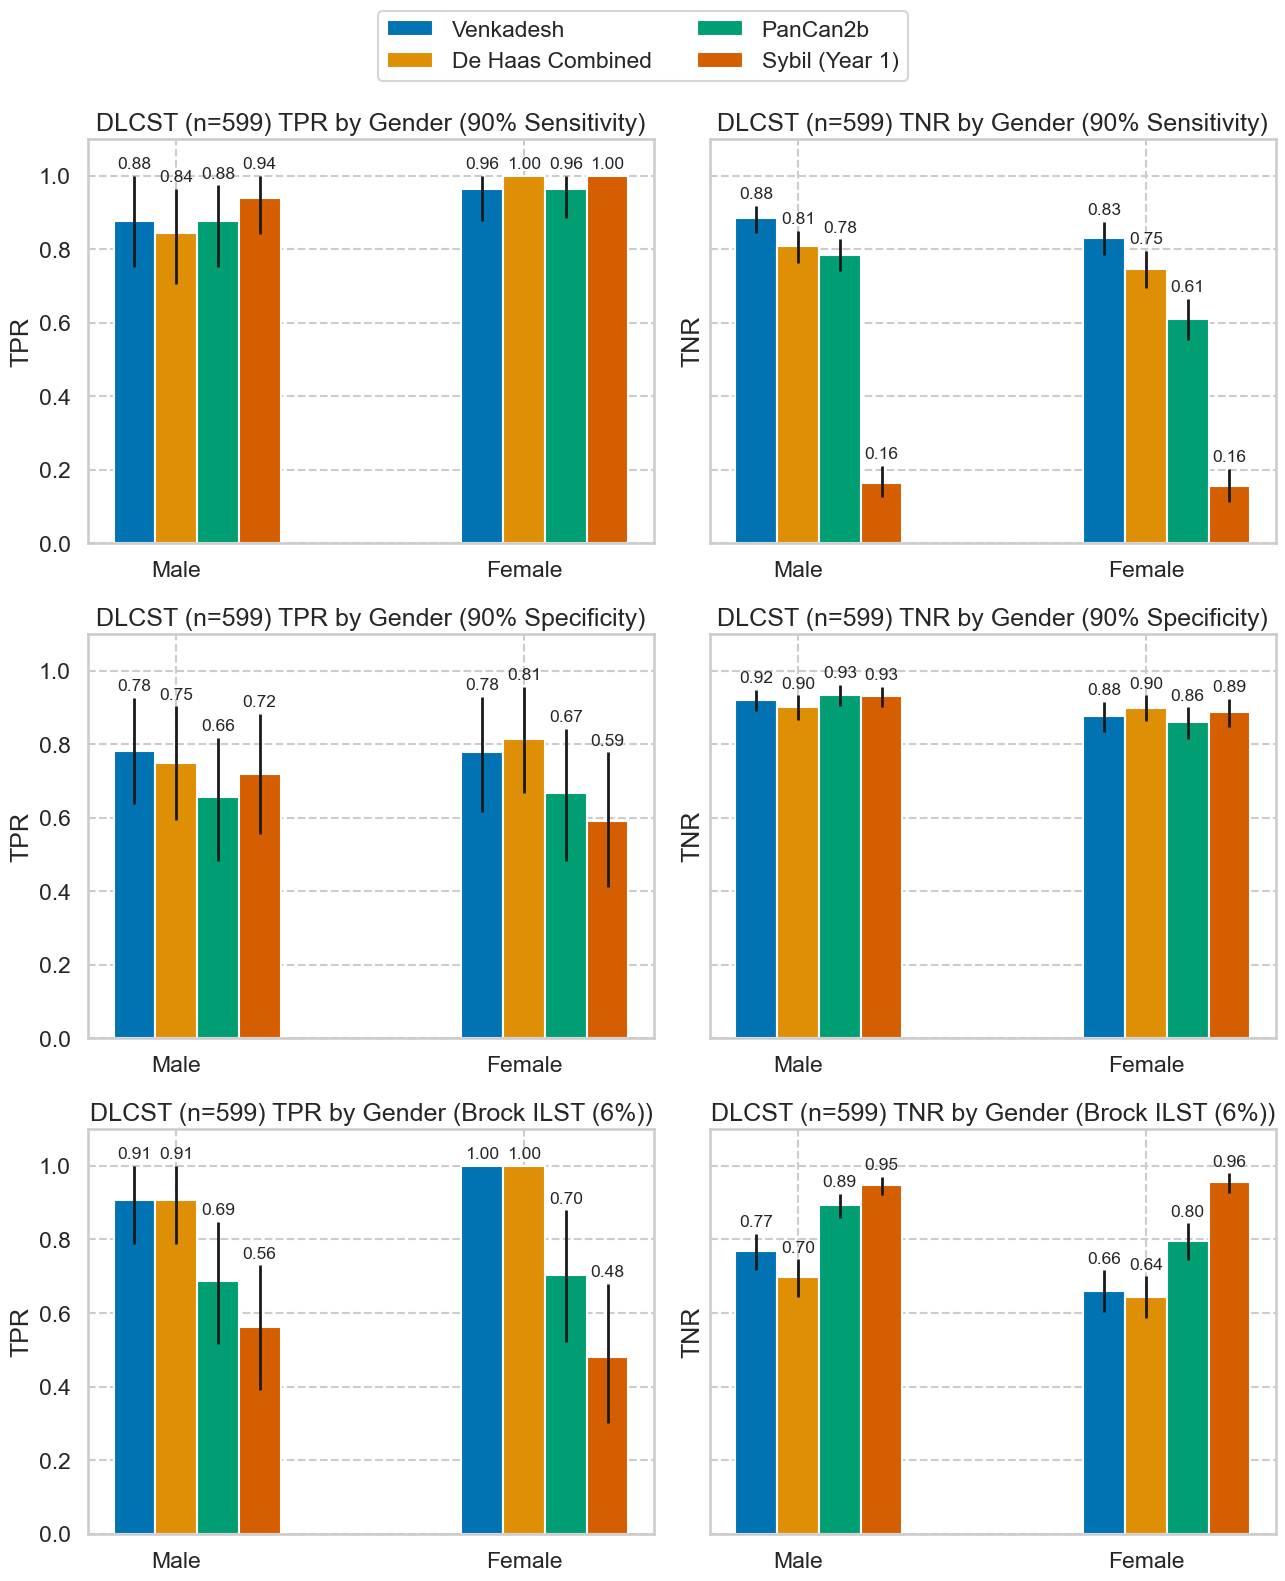

In [45]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Gender', dataset_name='DLCST',
                                             policies=dlcst_policies, models=DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Gender"'),
                                             plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTsex.png"
                                            )

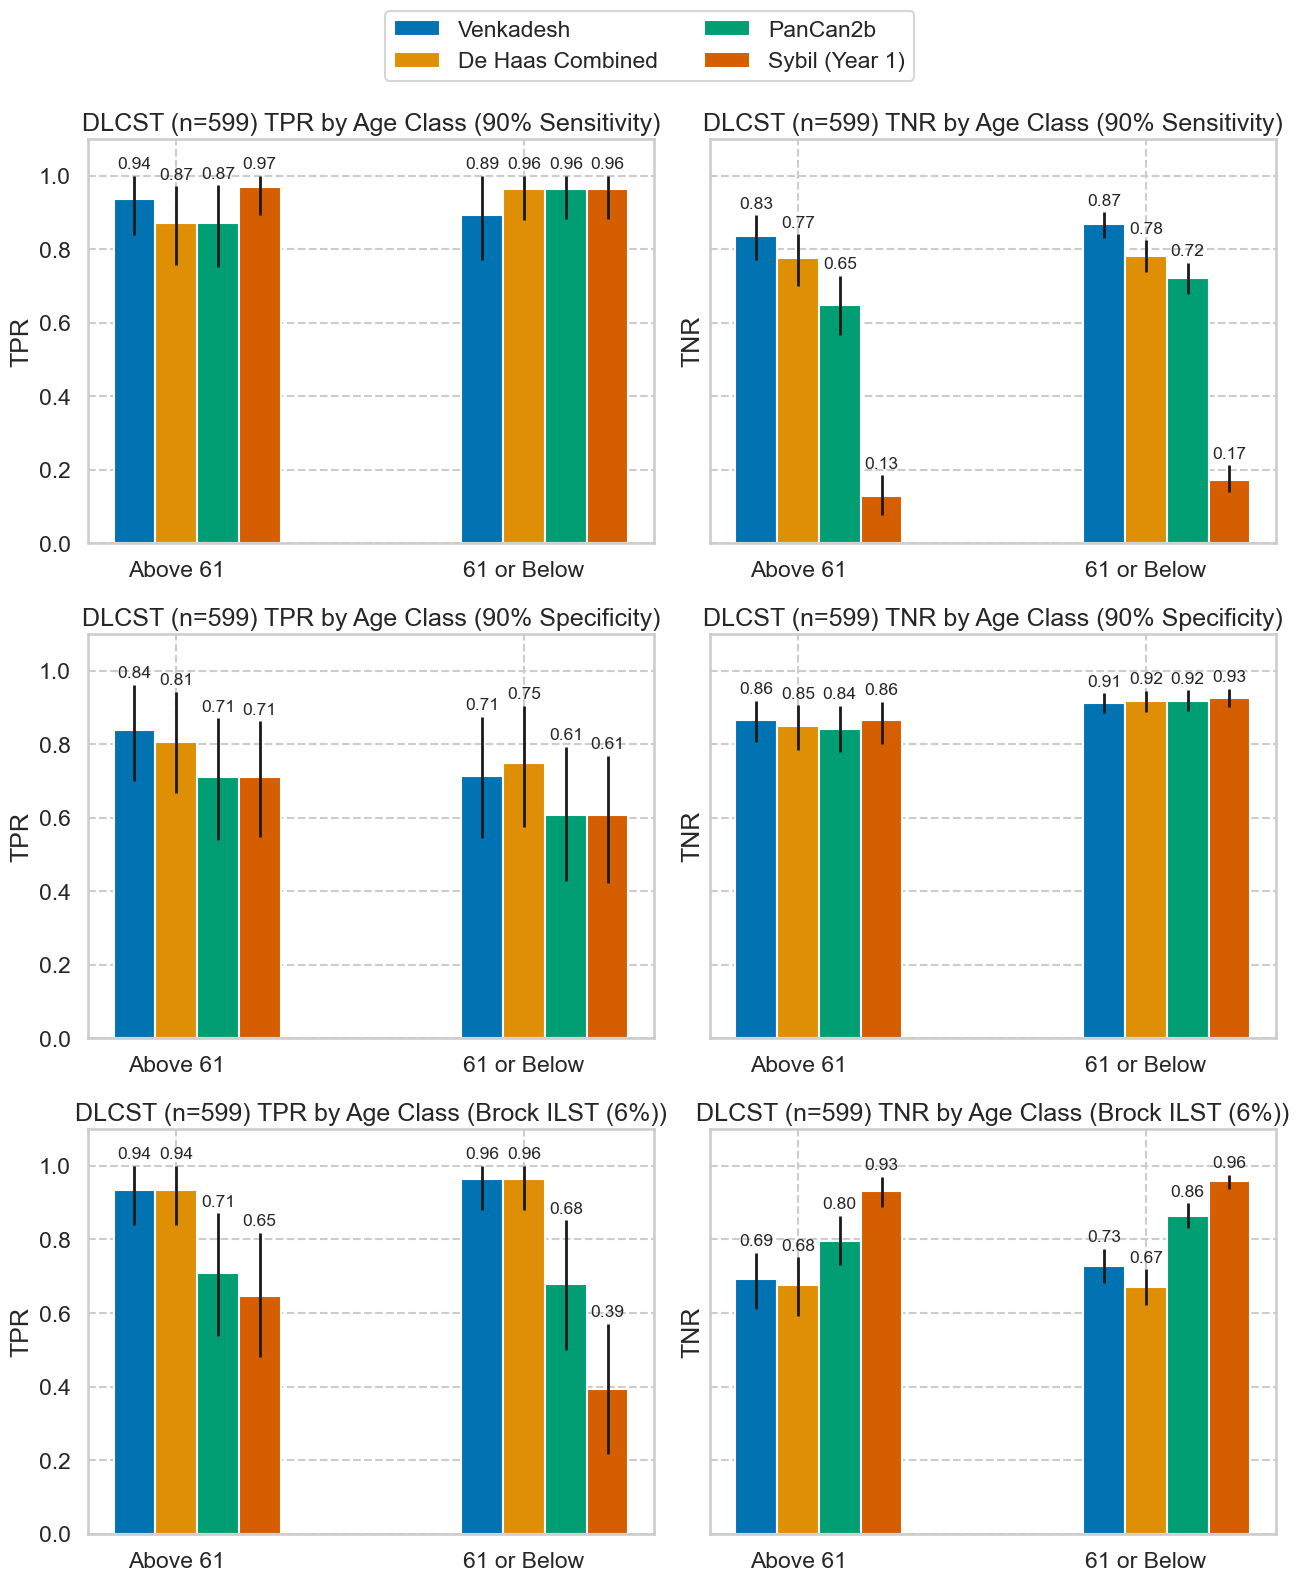

In [46]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Age Class', dataset_name='DLCST',
                                             policies=dlcst_policies, models=DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Age Class"'),
                                             plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTage.png"
                                            )

### NLST (1172)

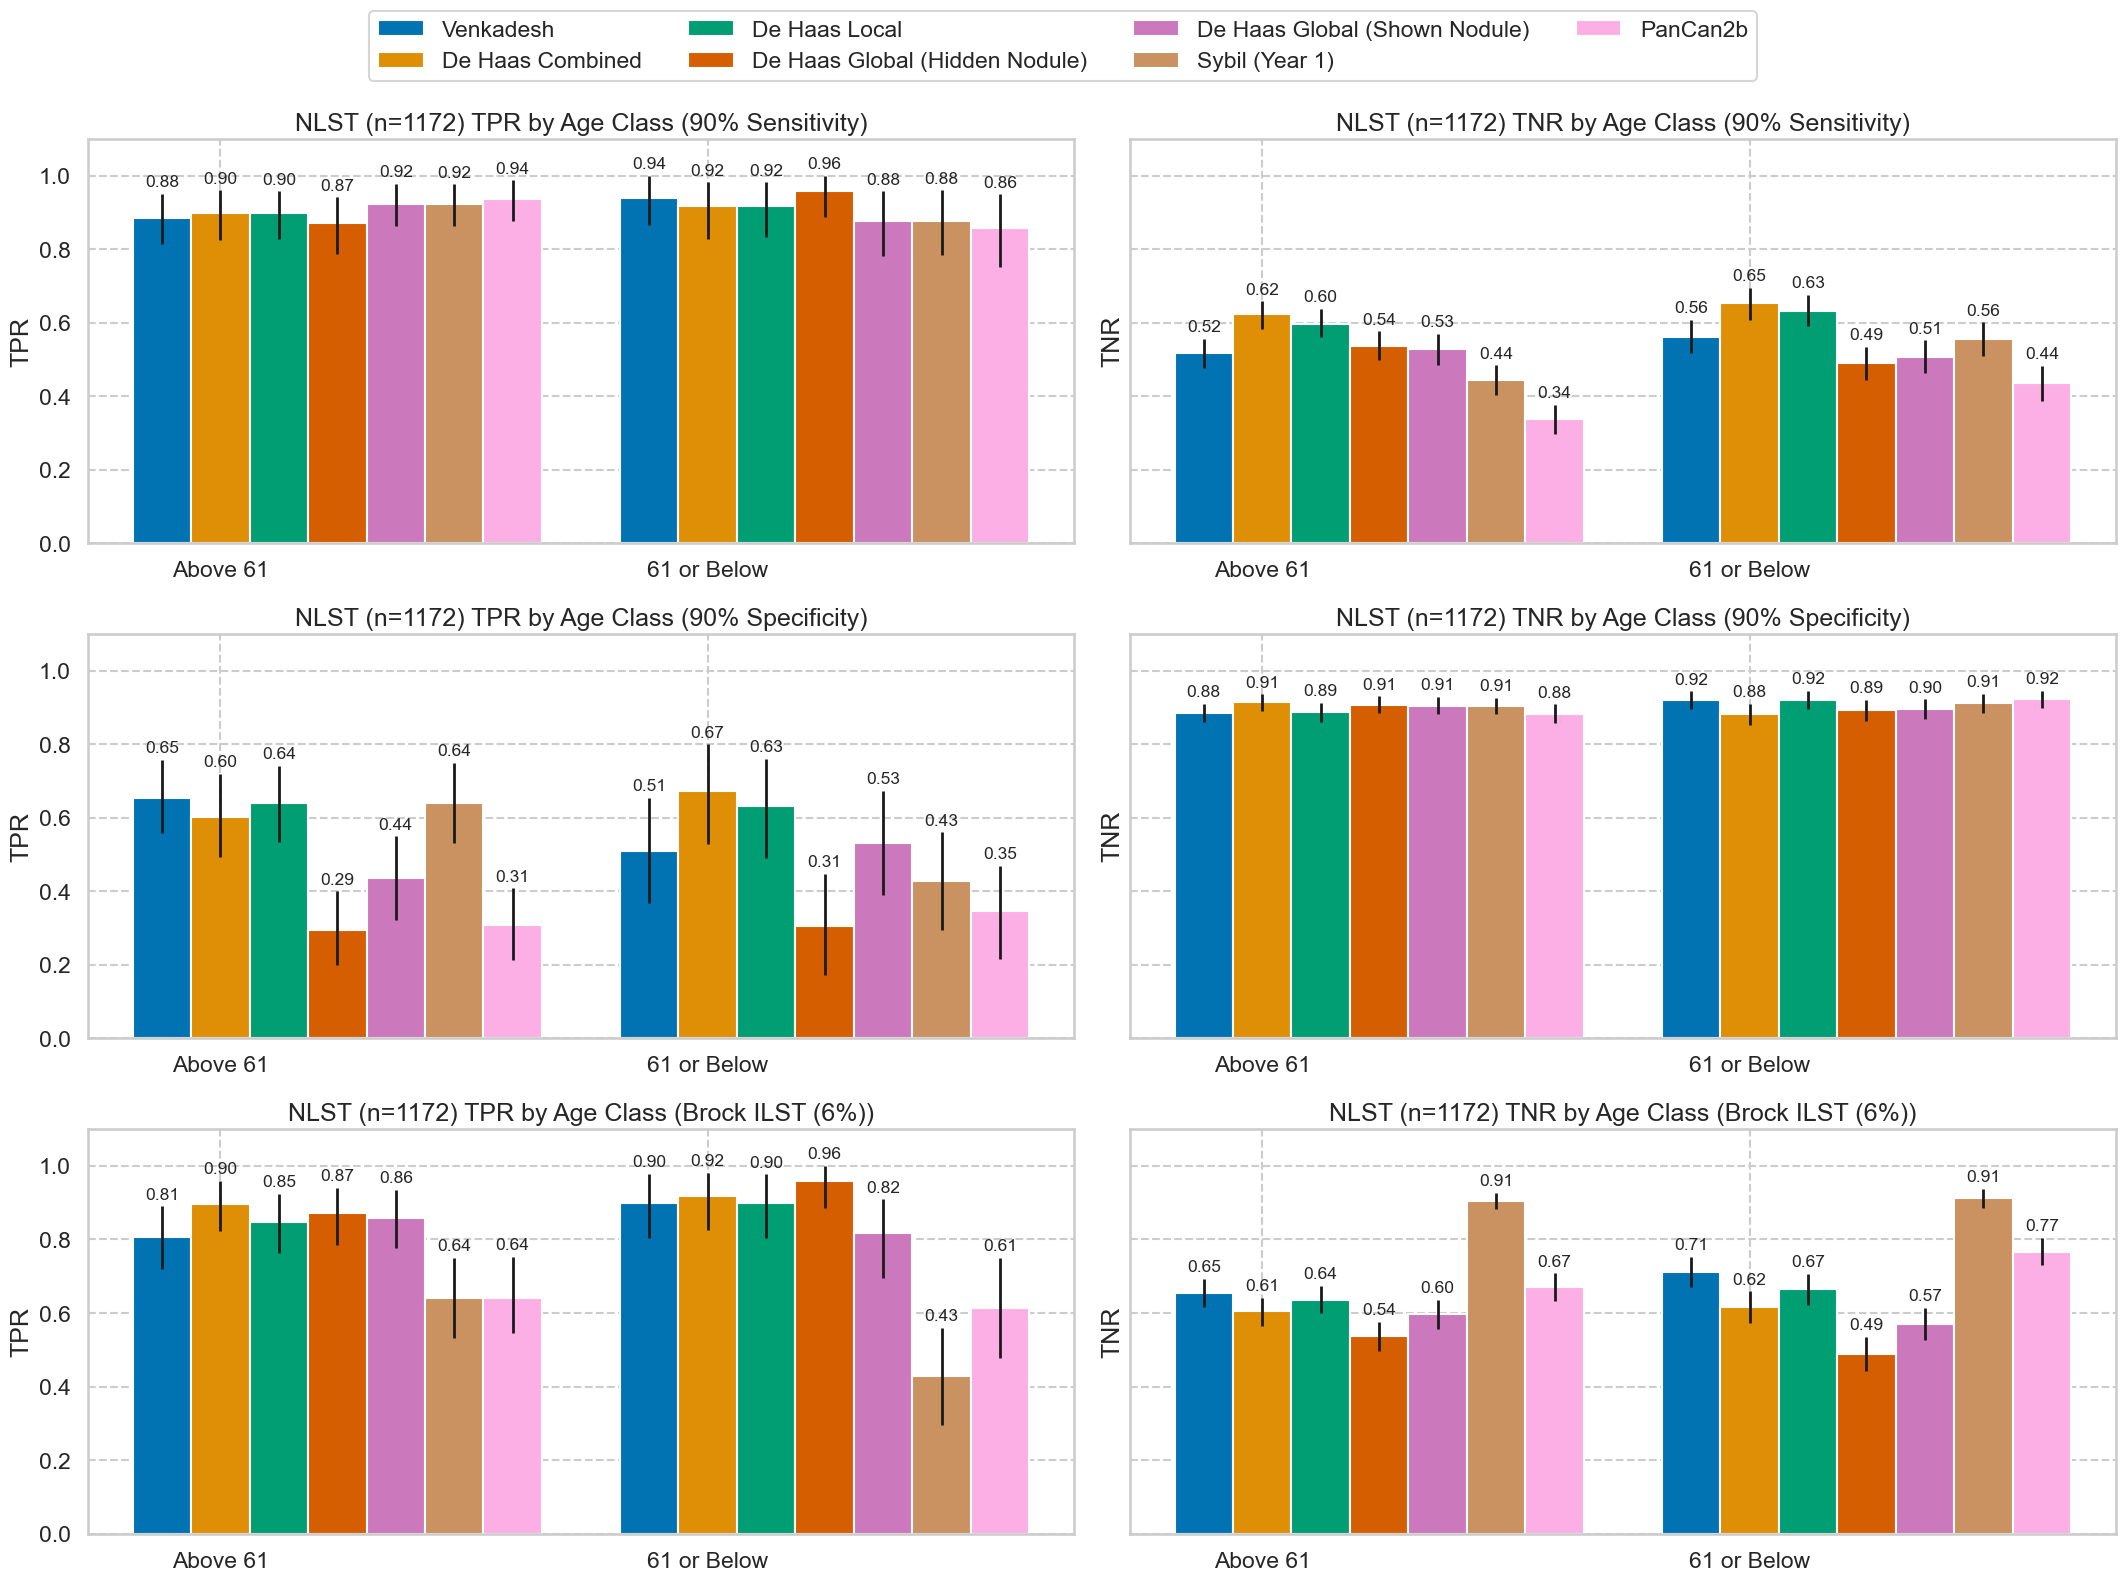

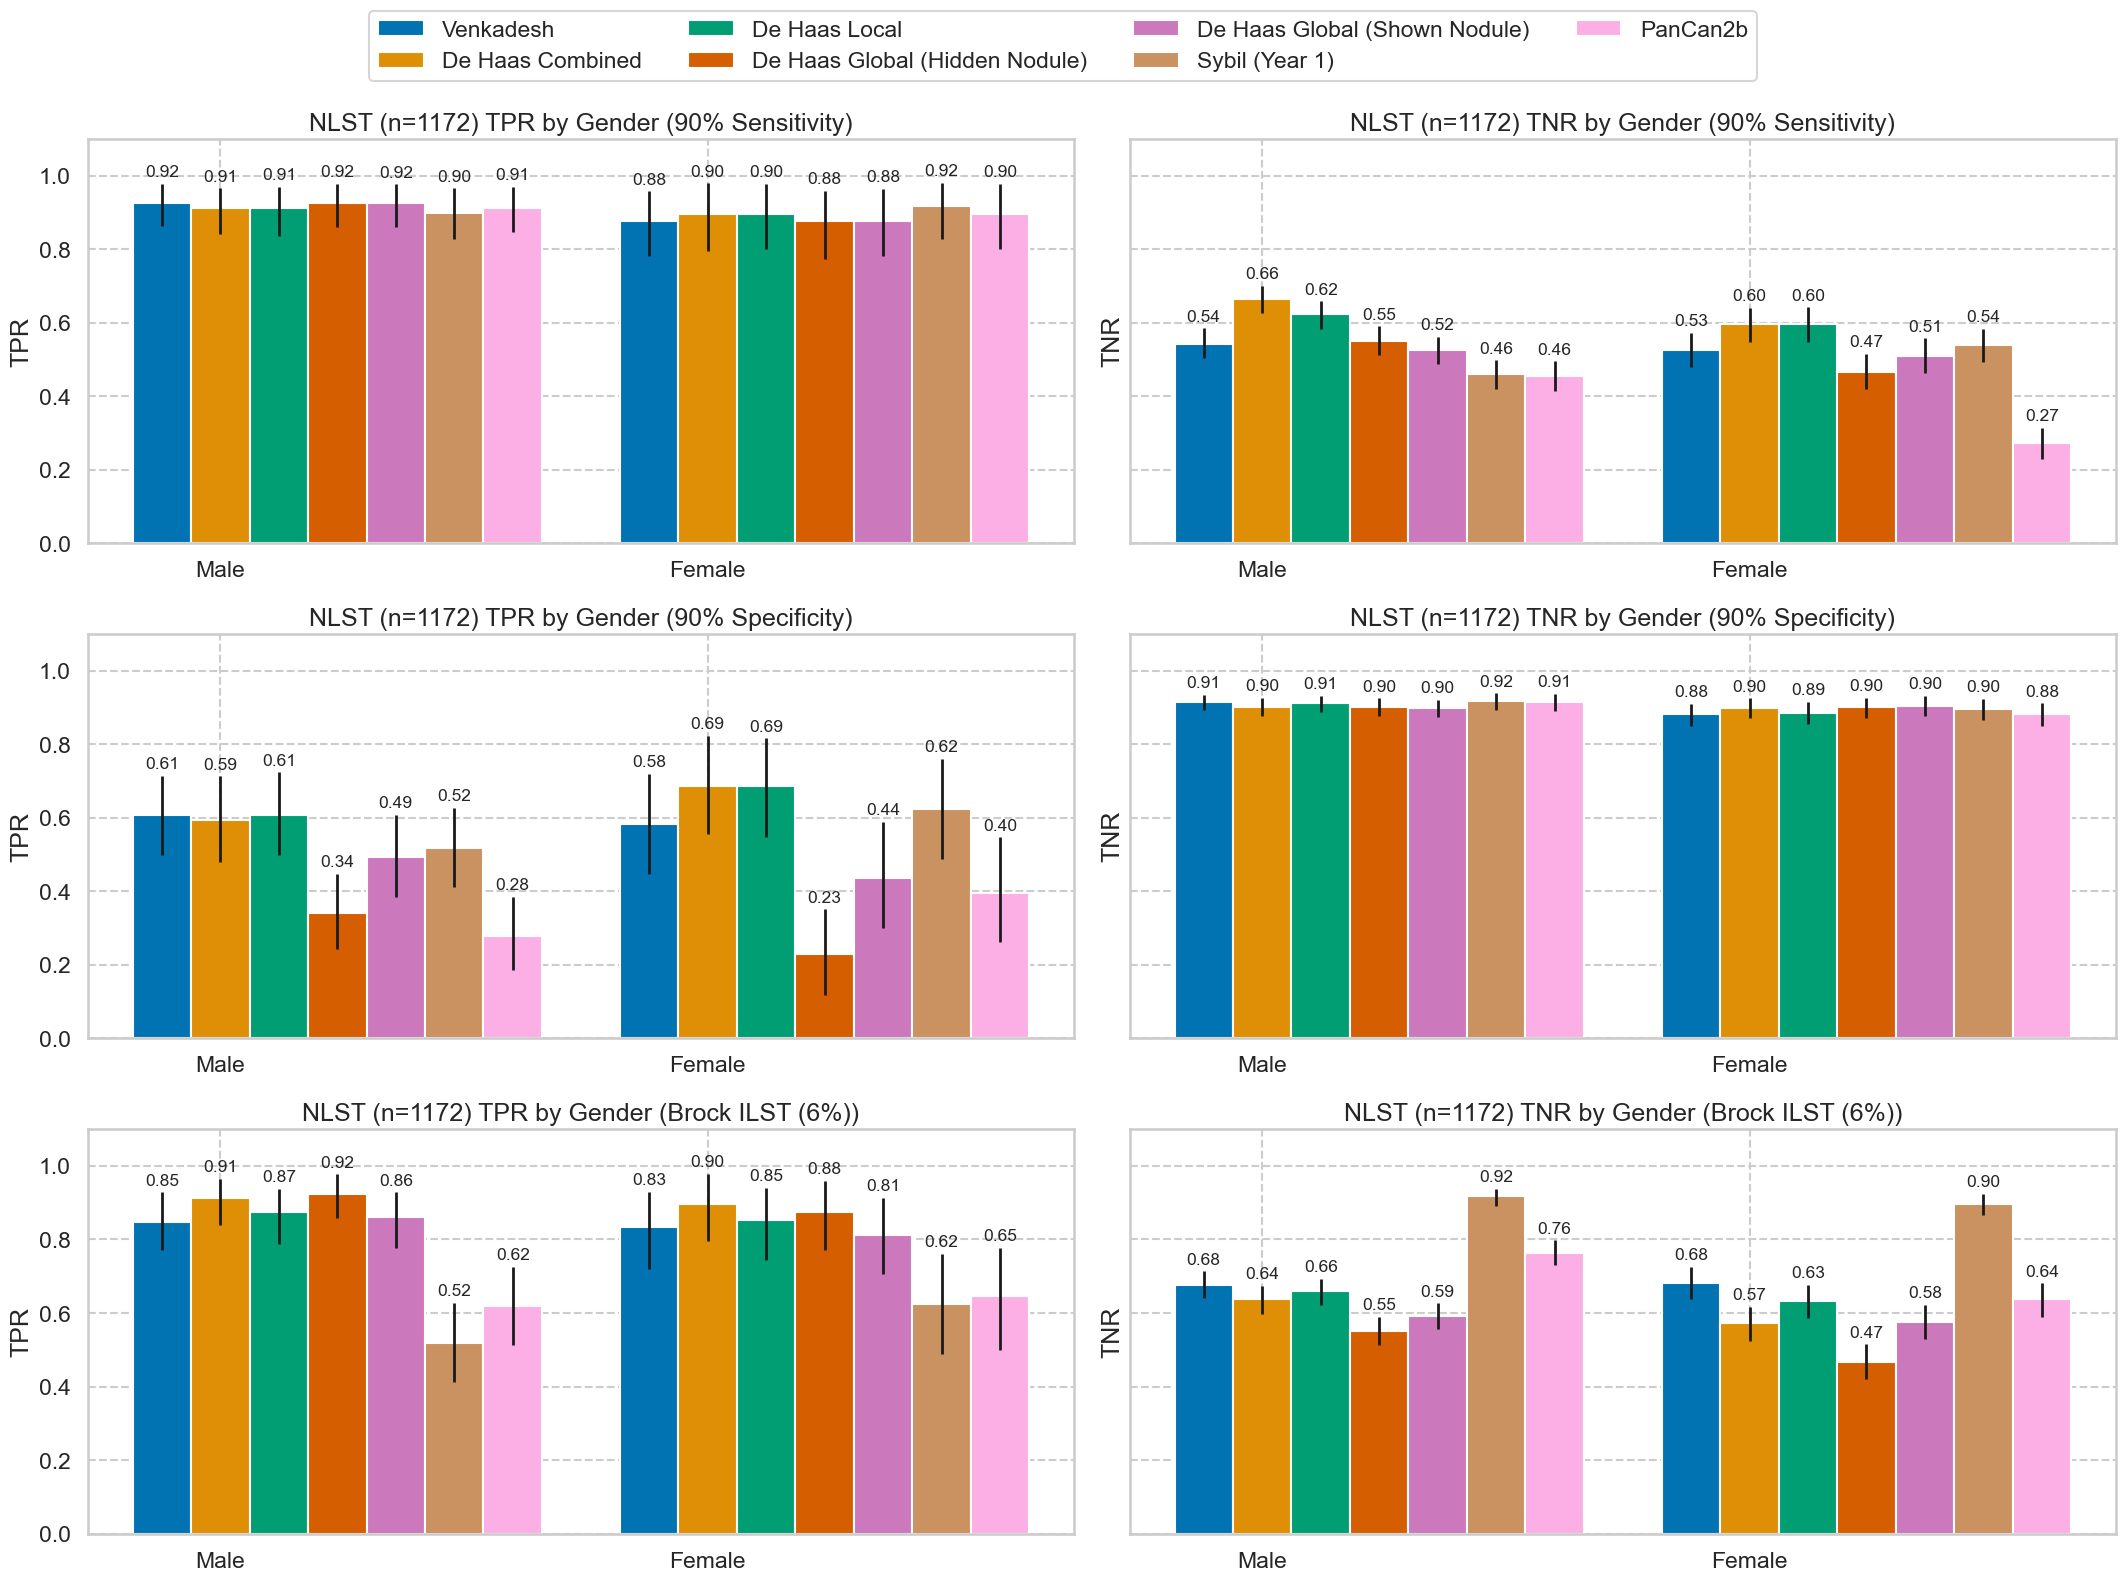

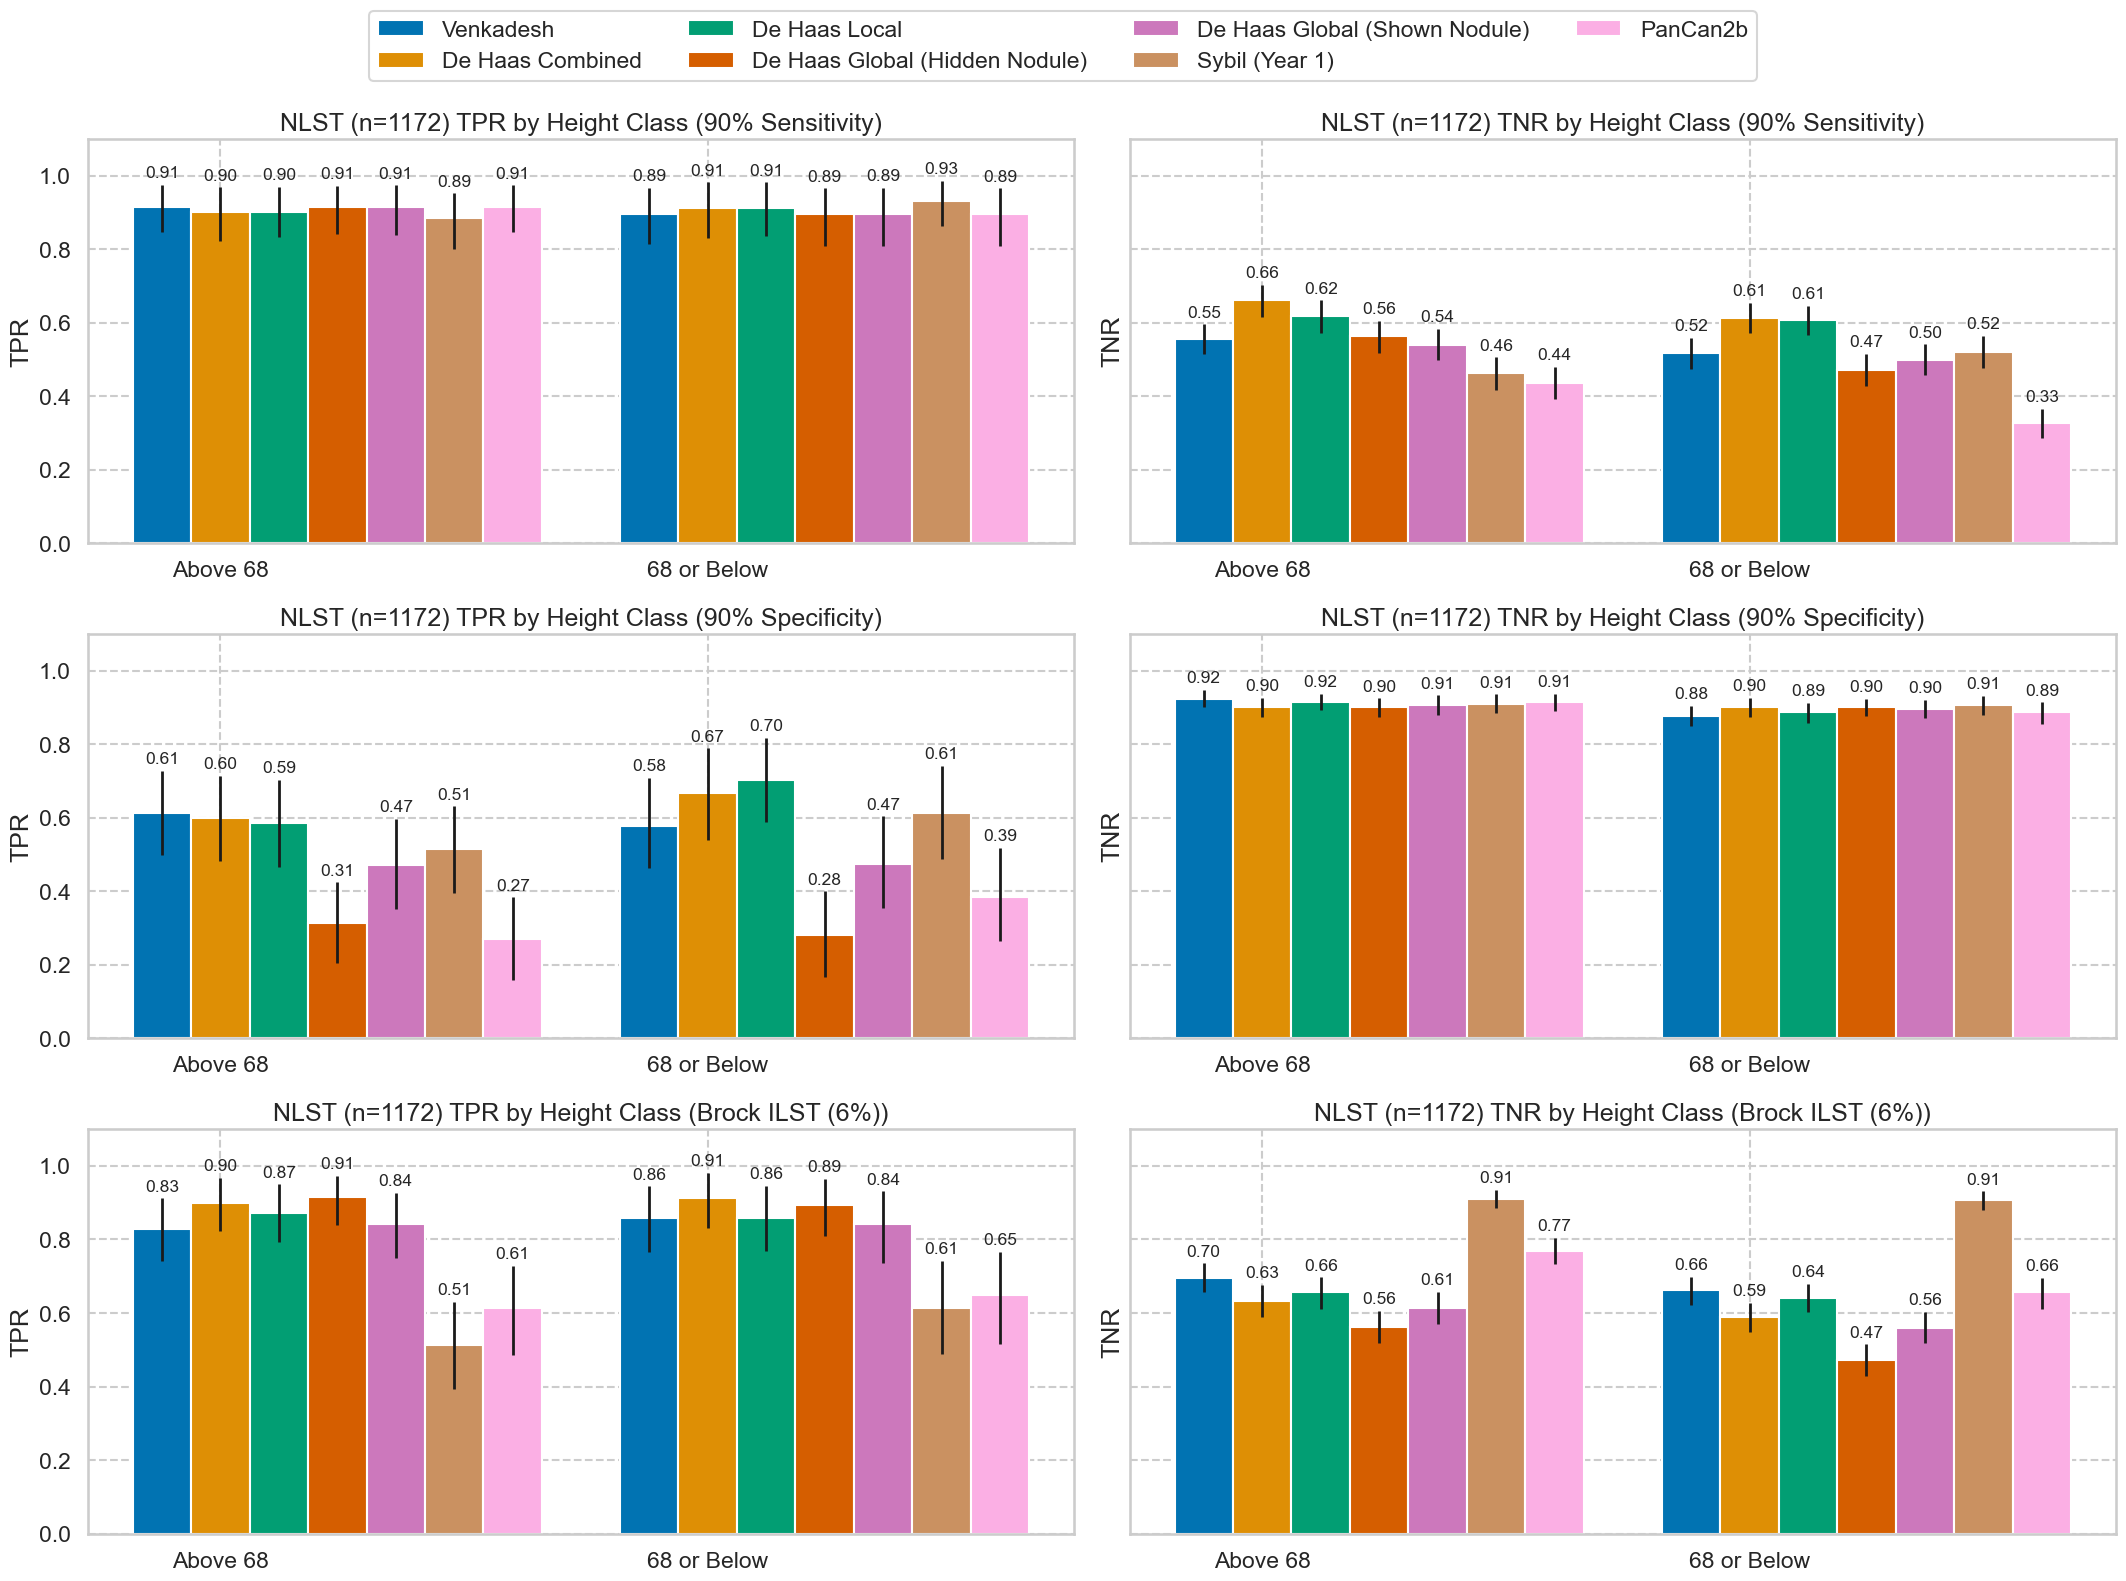

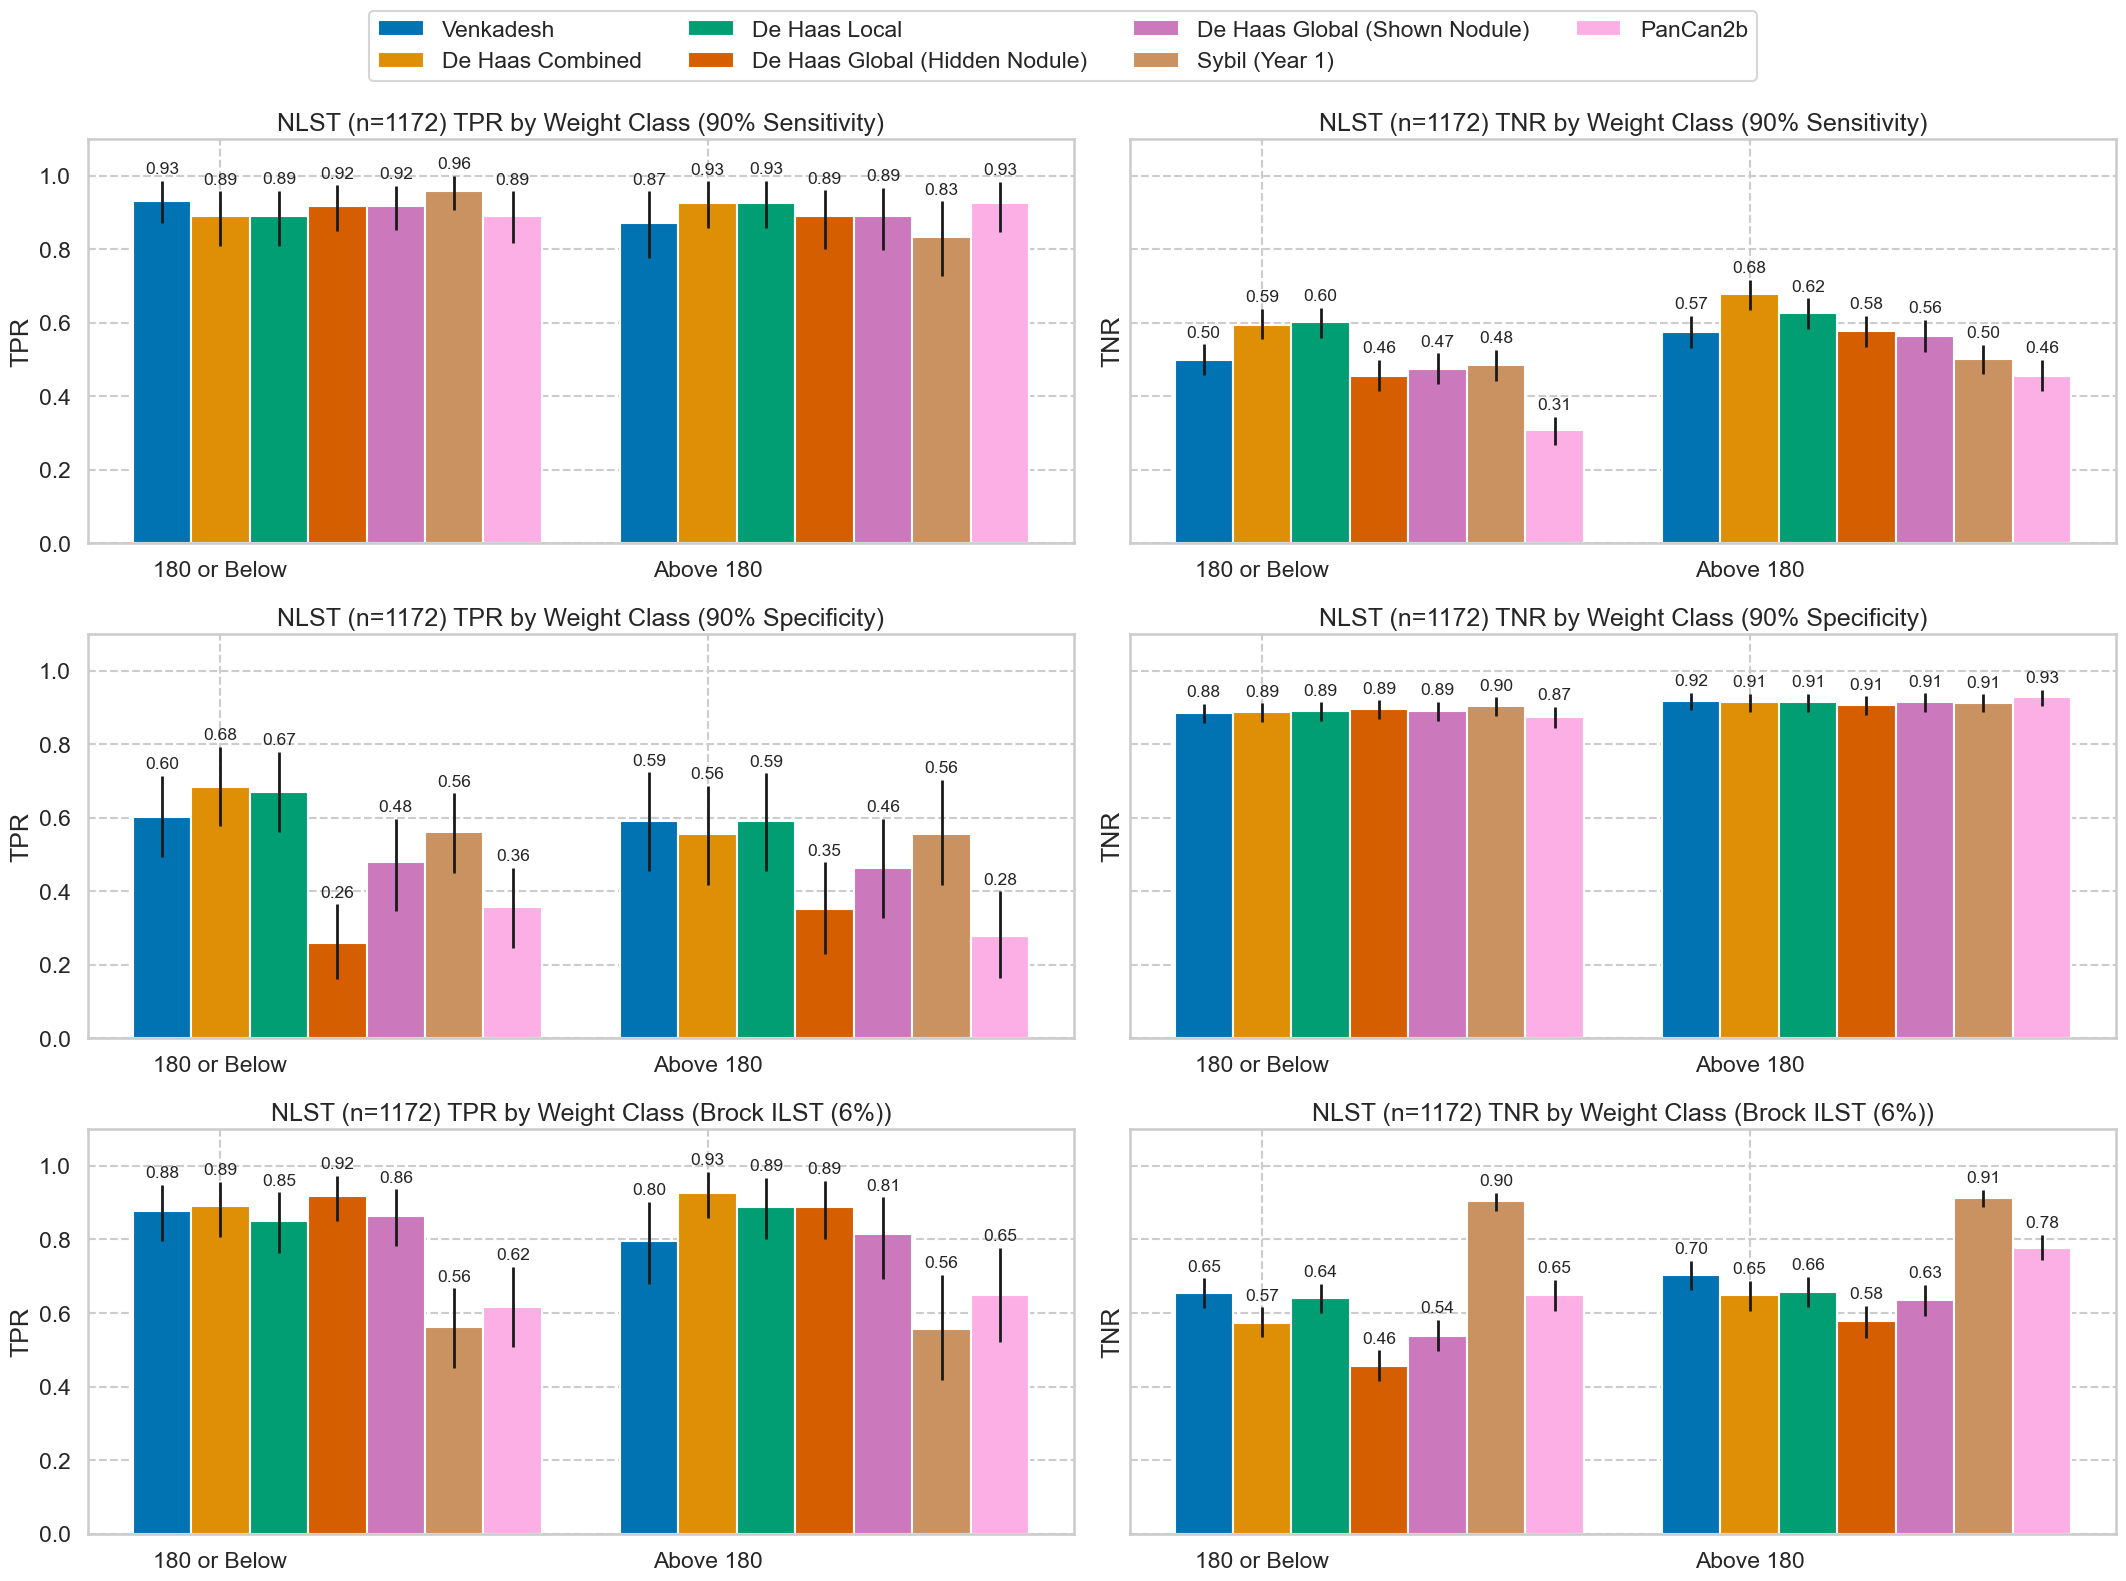

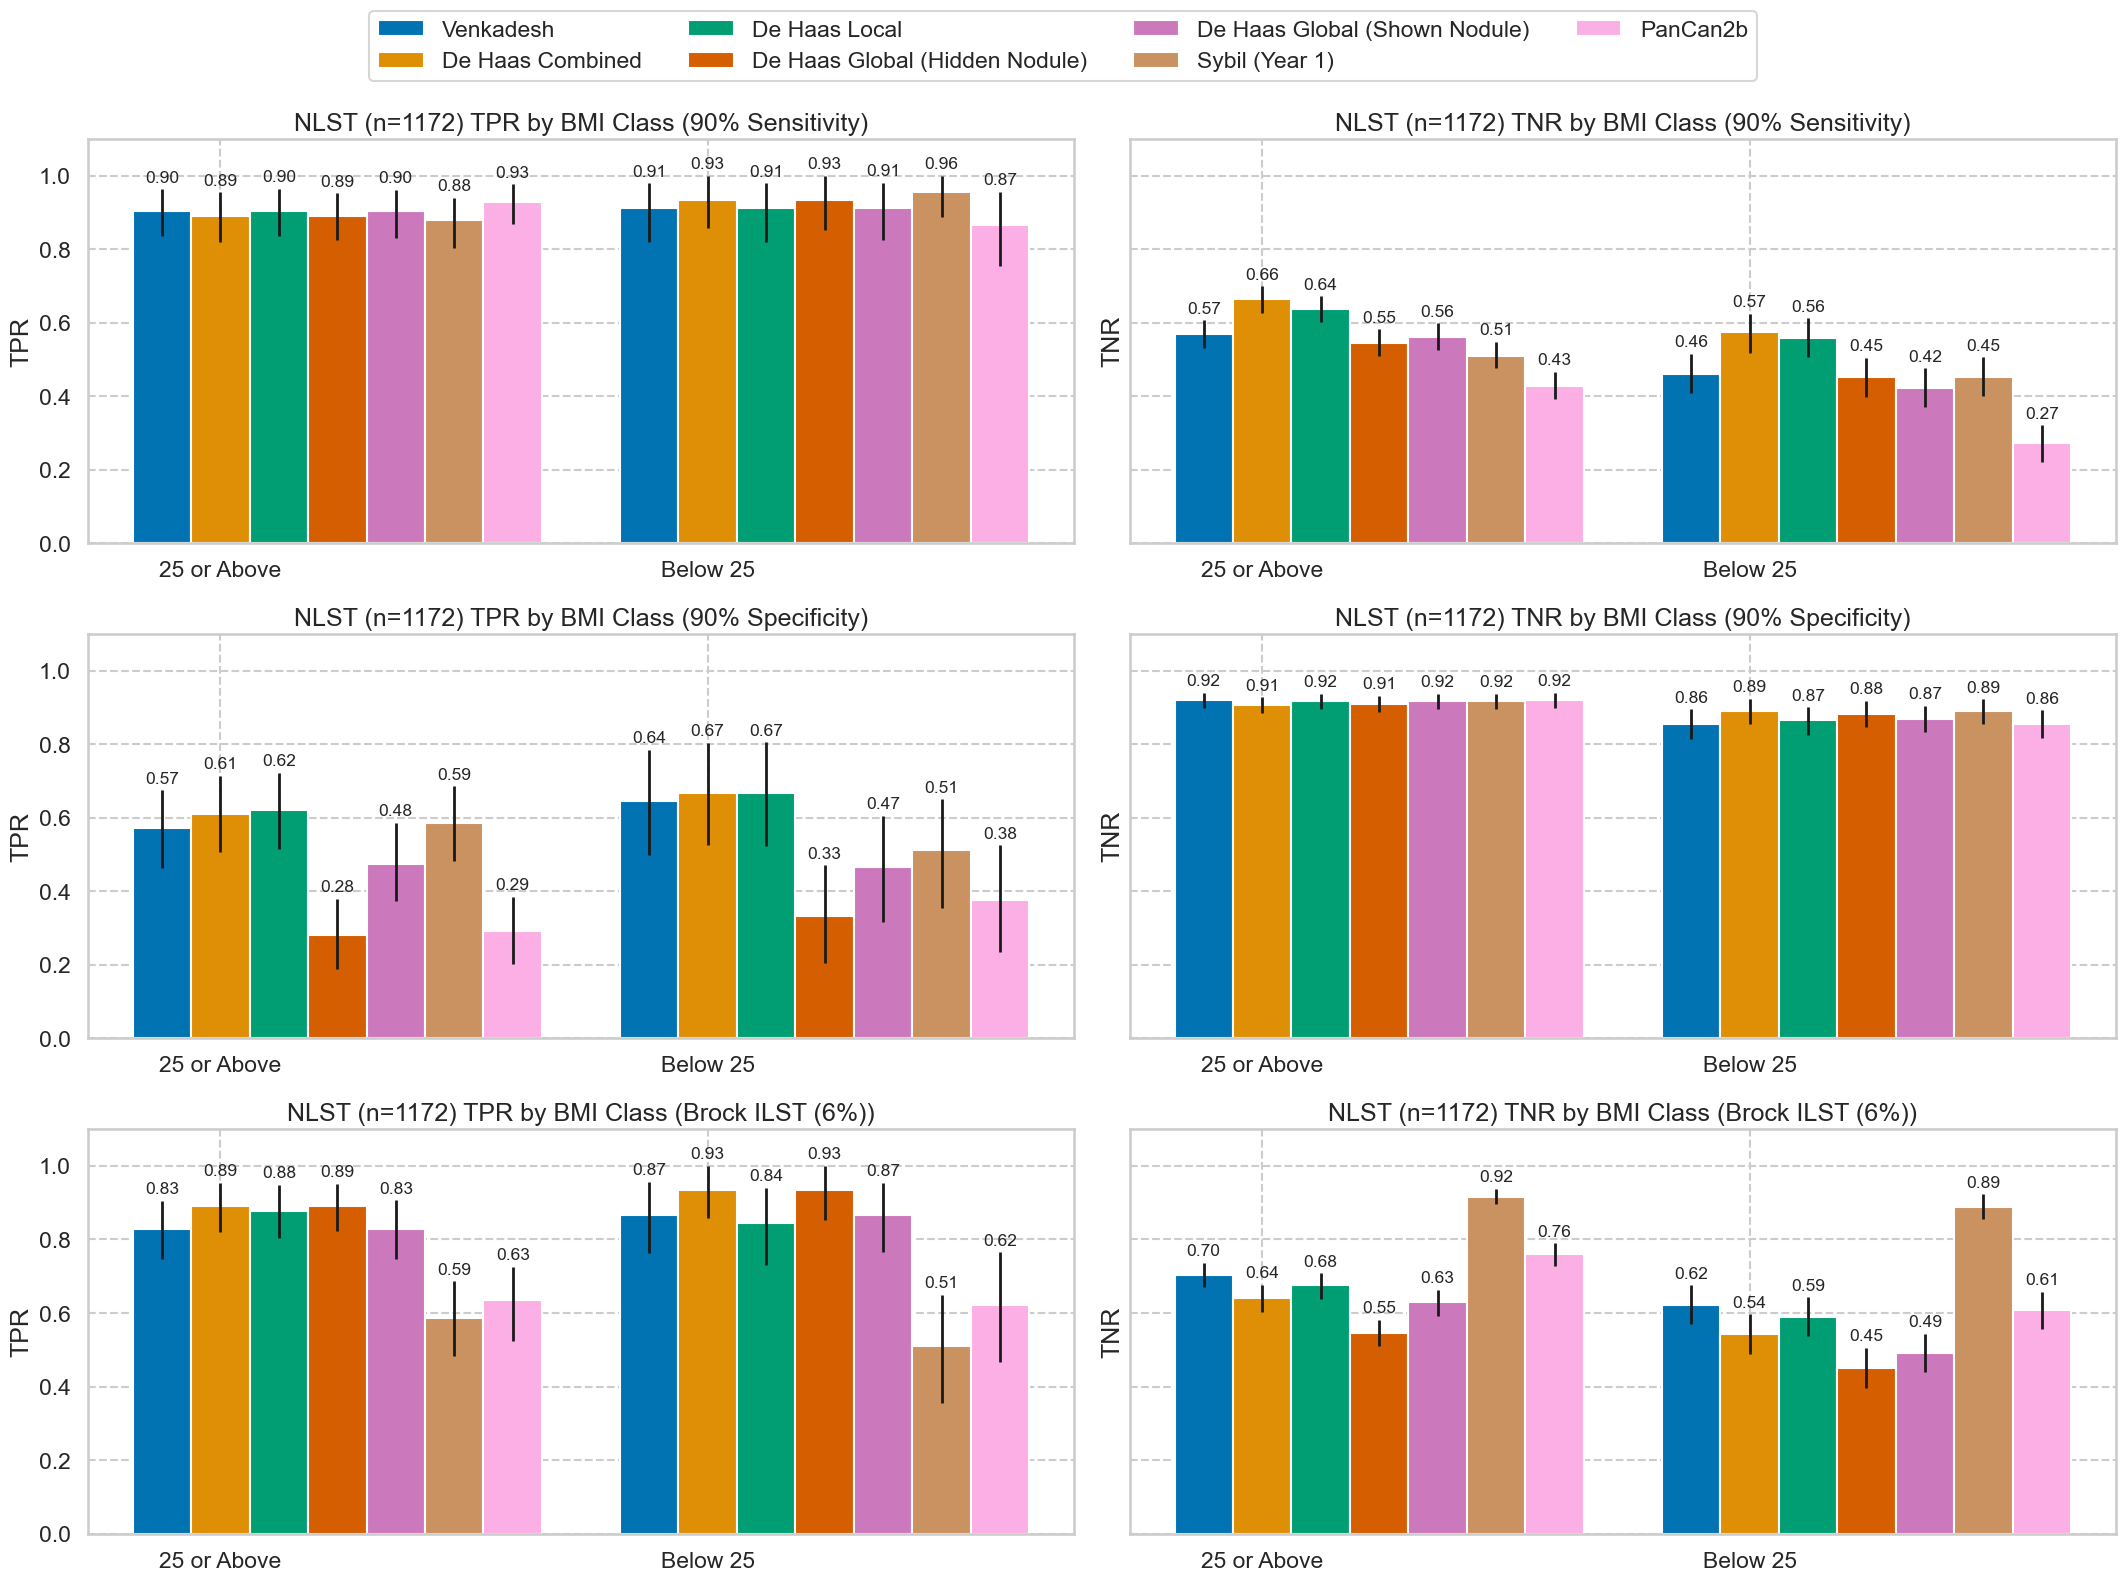

In [47]:
for col in nlst_demos_to_include:
    _ = threshold.plot_threshold_stats_subgroups(nlst_1172, col, dataset_name='NLST',
                                                policies=nlst_1172_policies, models=NLST_1172_MODELCOLS, 
                                                stats=threshold_nlst_1172.query(f'attribute == "{col}"'),
                                                plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/threshold-NLST-1172/{col}.png"
                                                )  

### NLST 5911


['Age Class', 'Gender', 'Race', 'HS Education', 'Height Class', 'Weight Class', 'BMI Class']


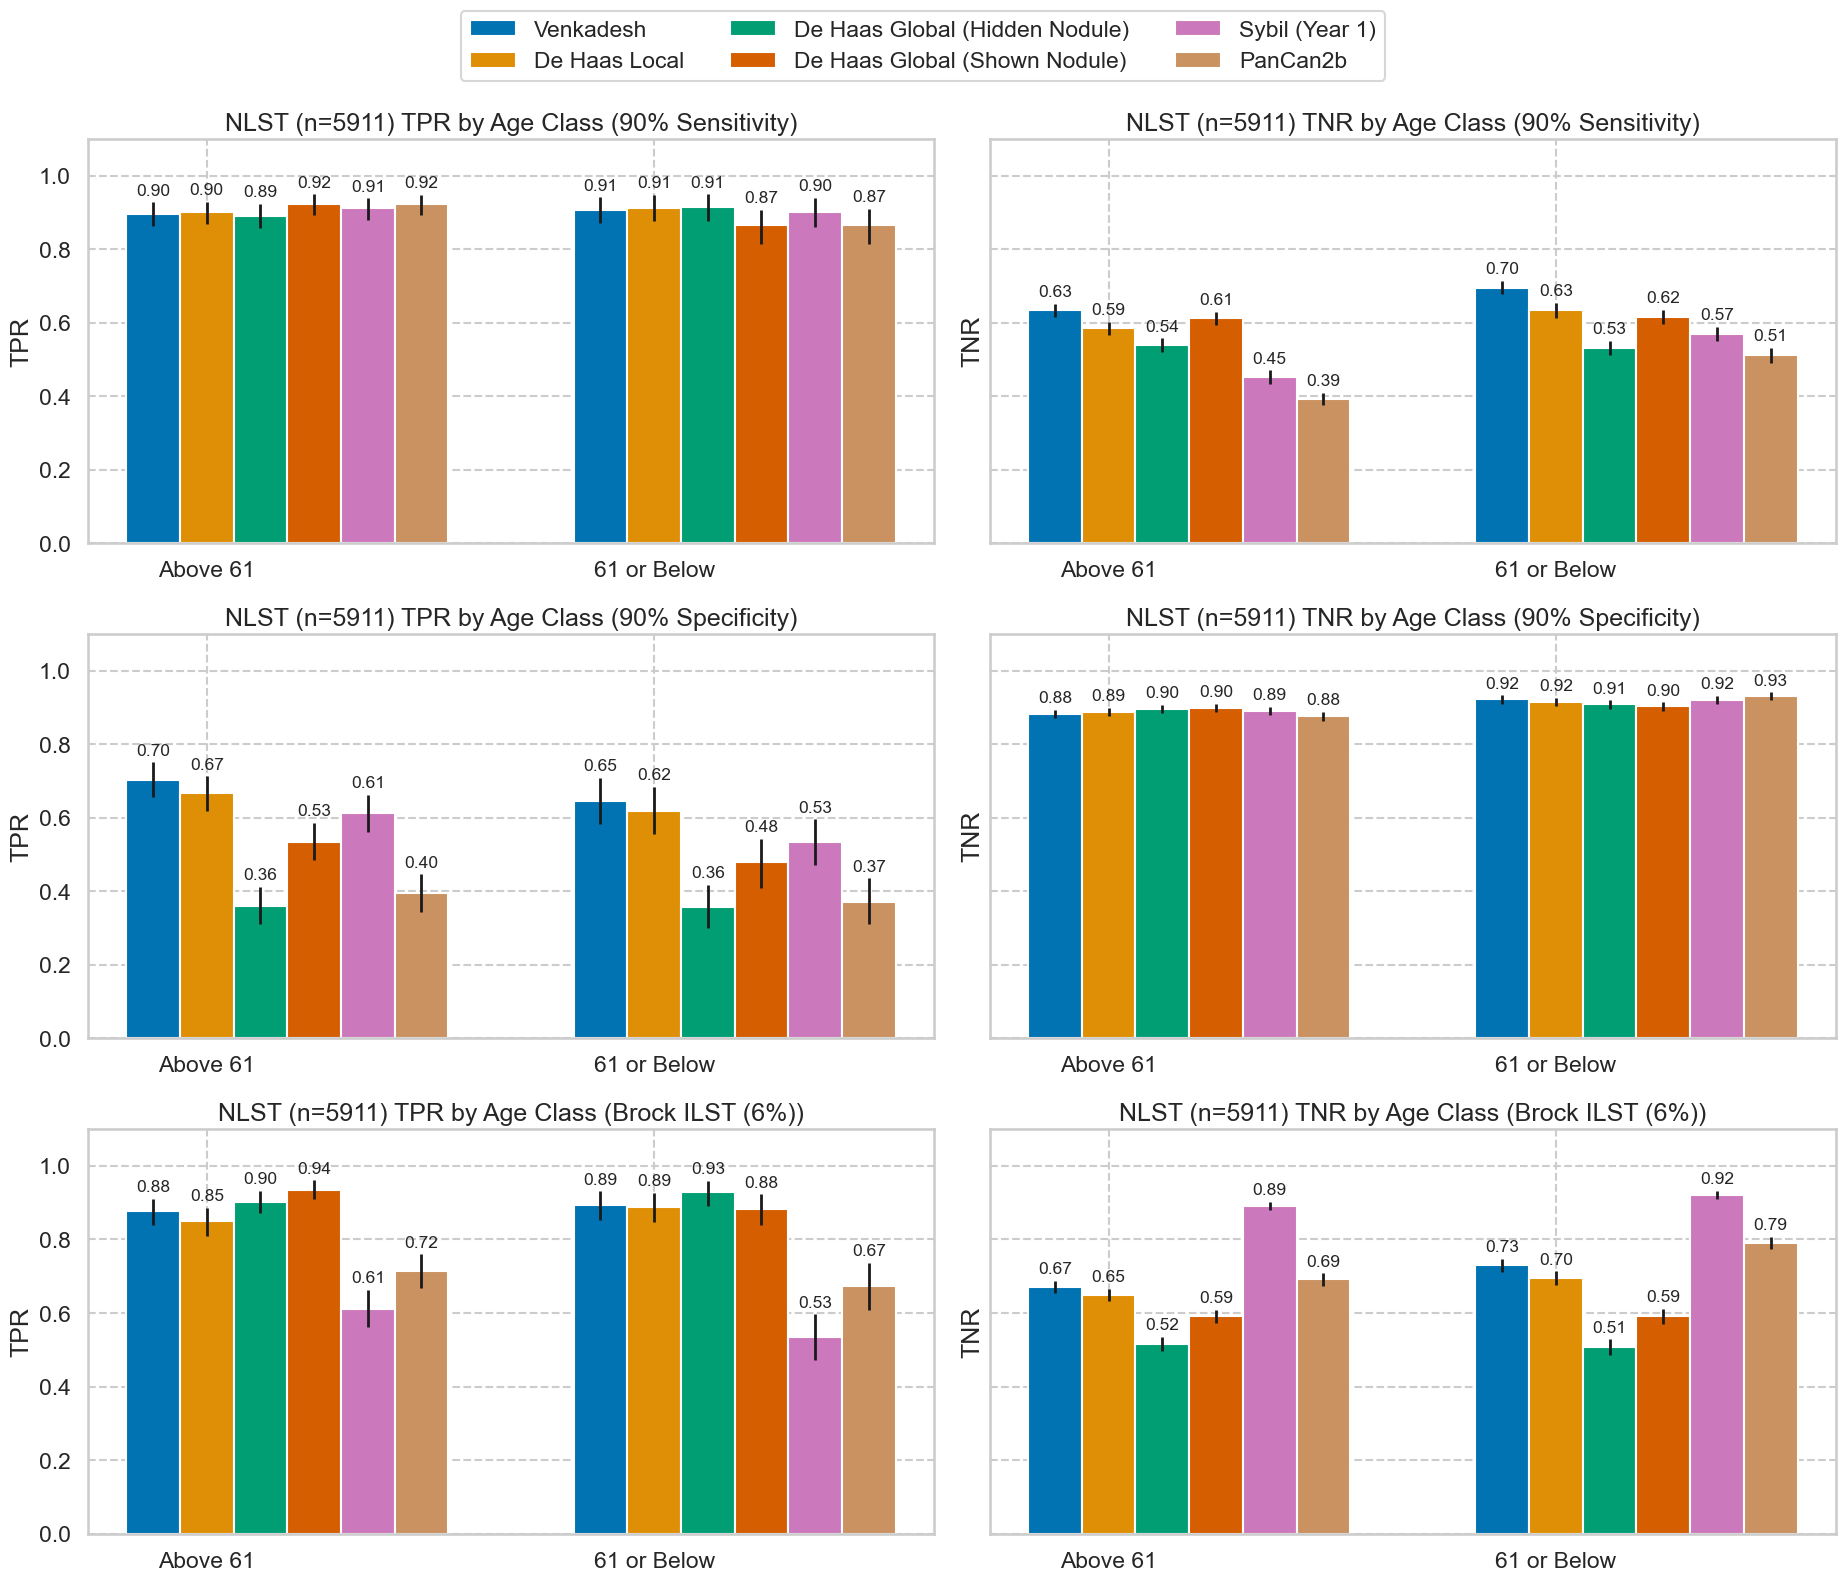

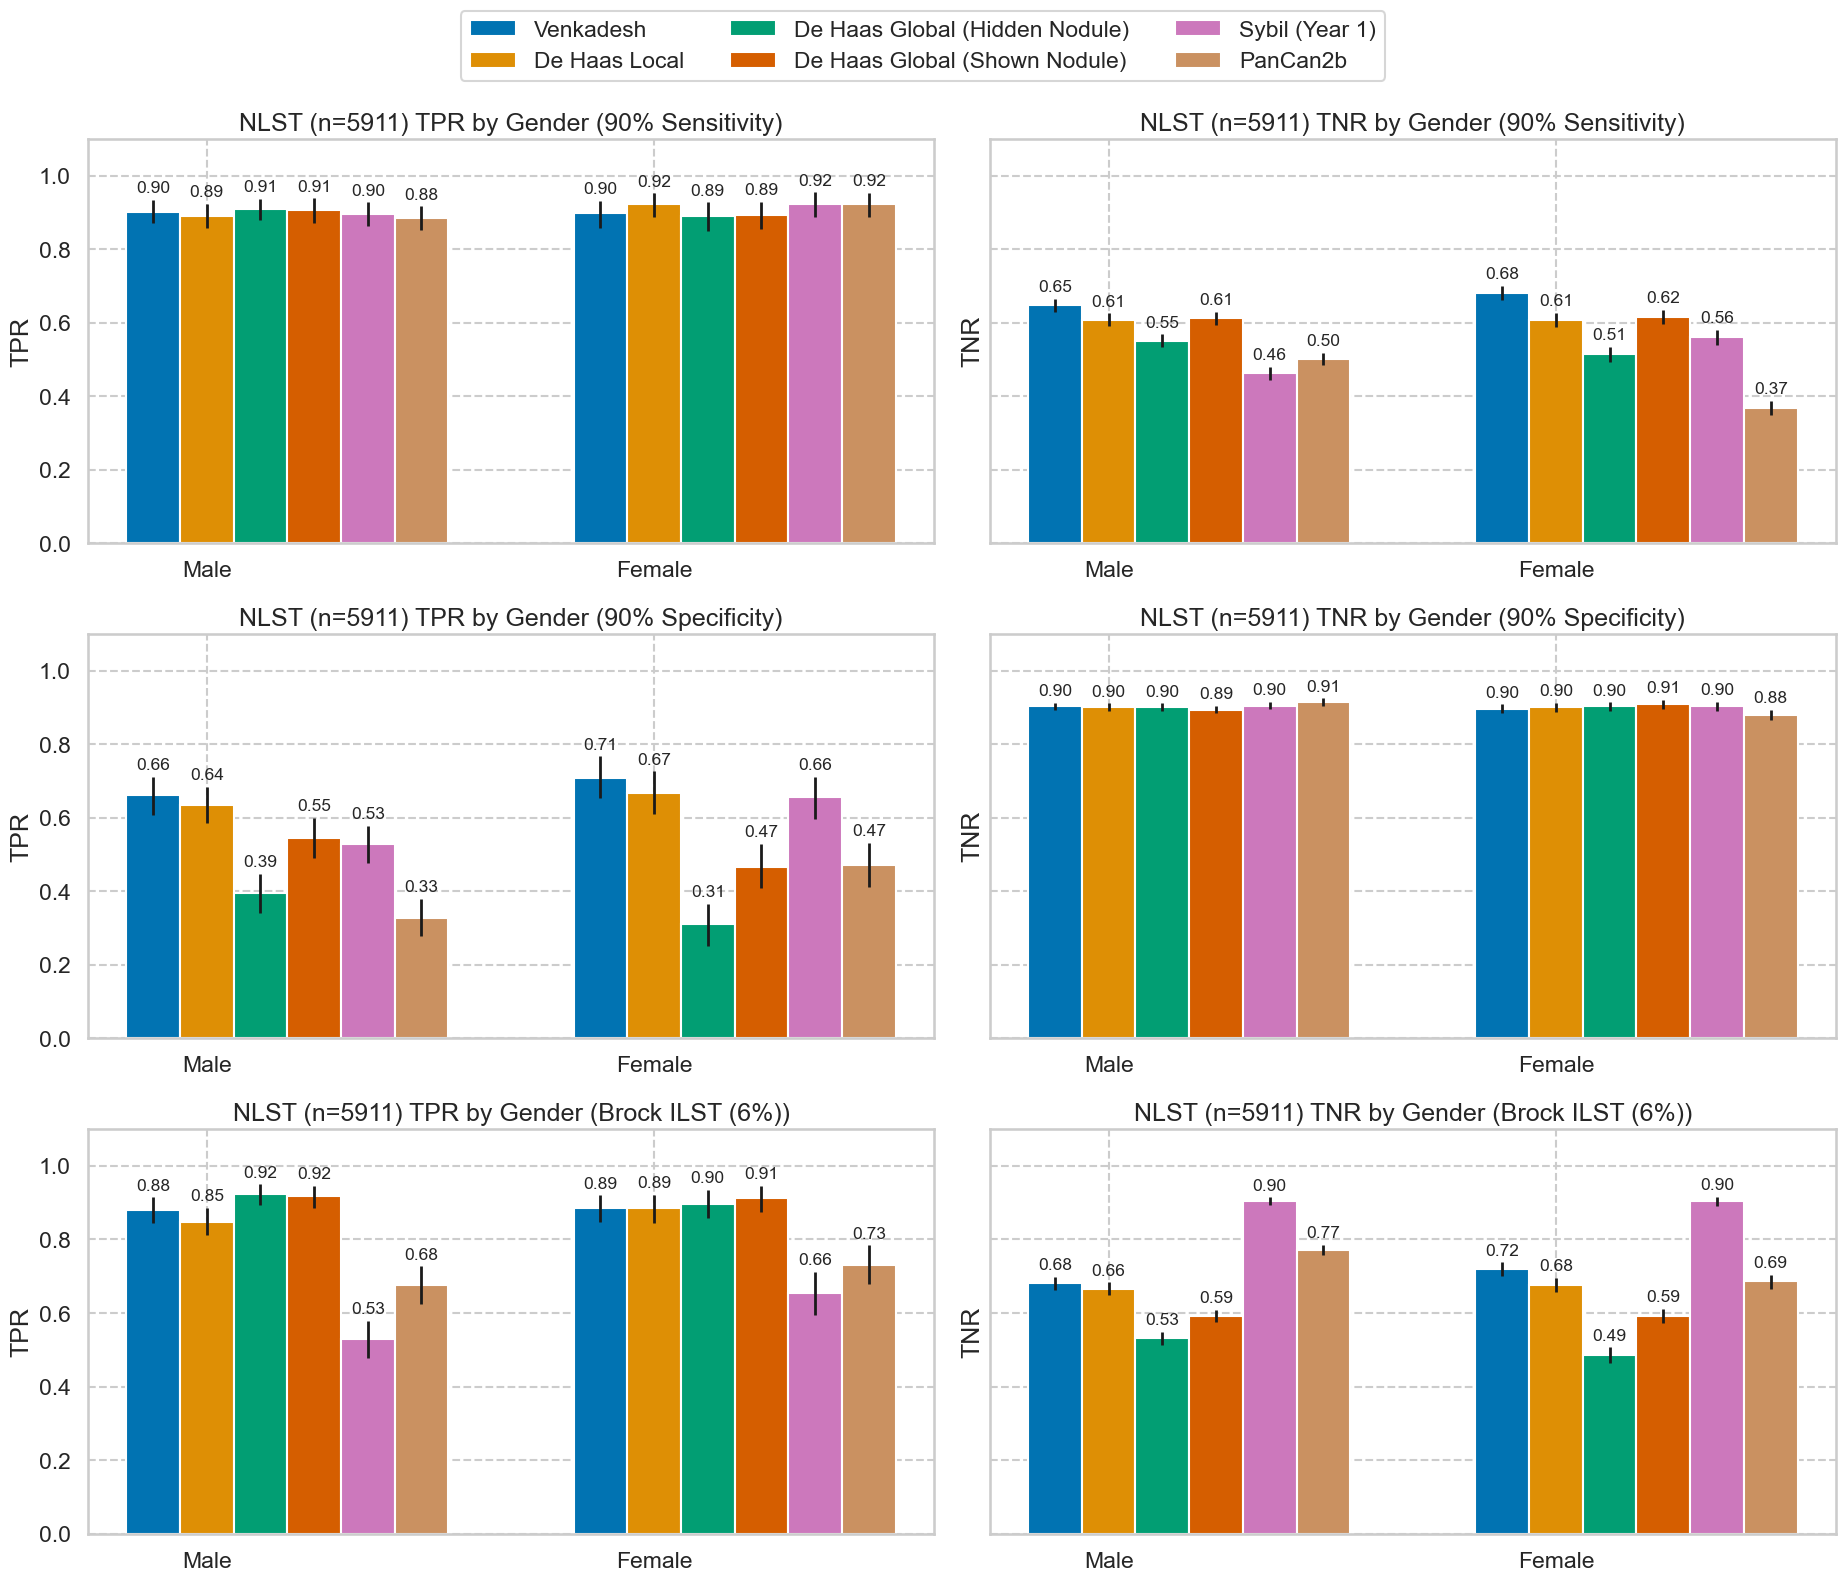

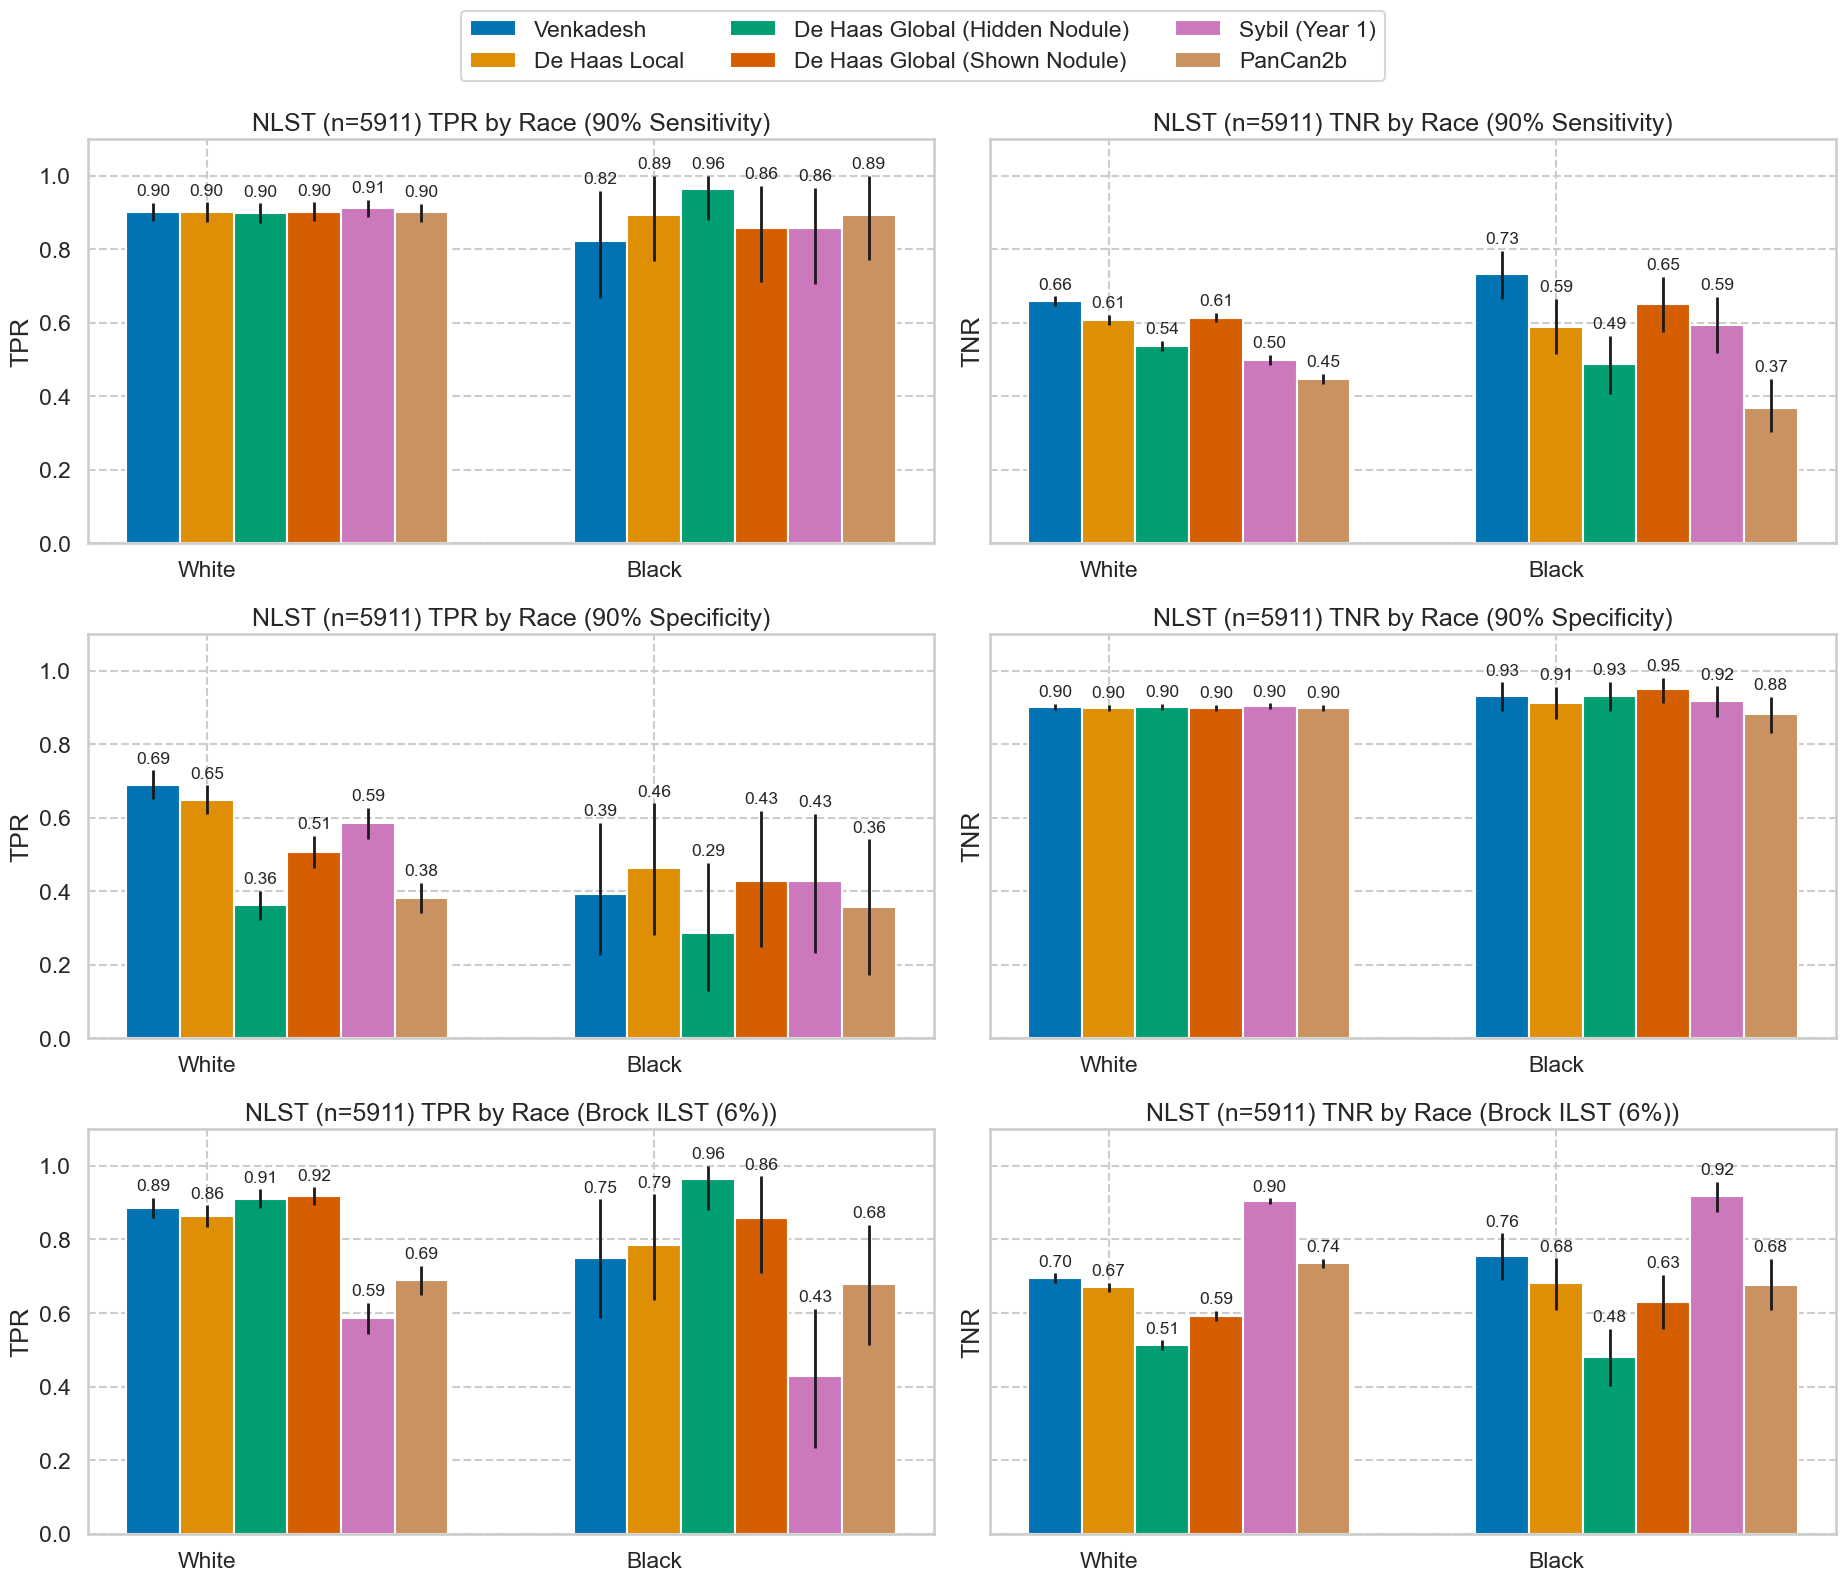

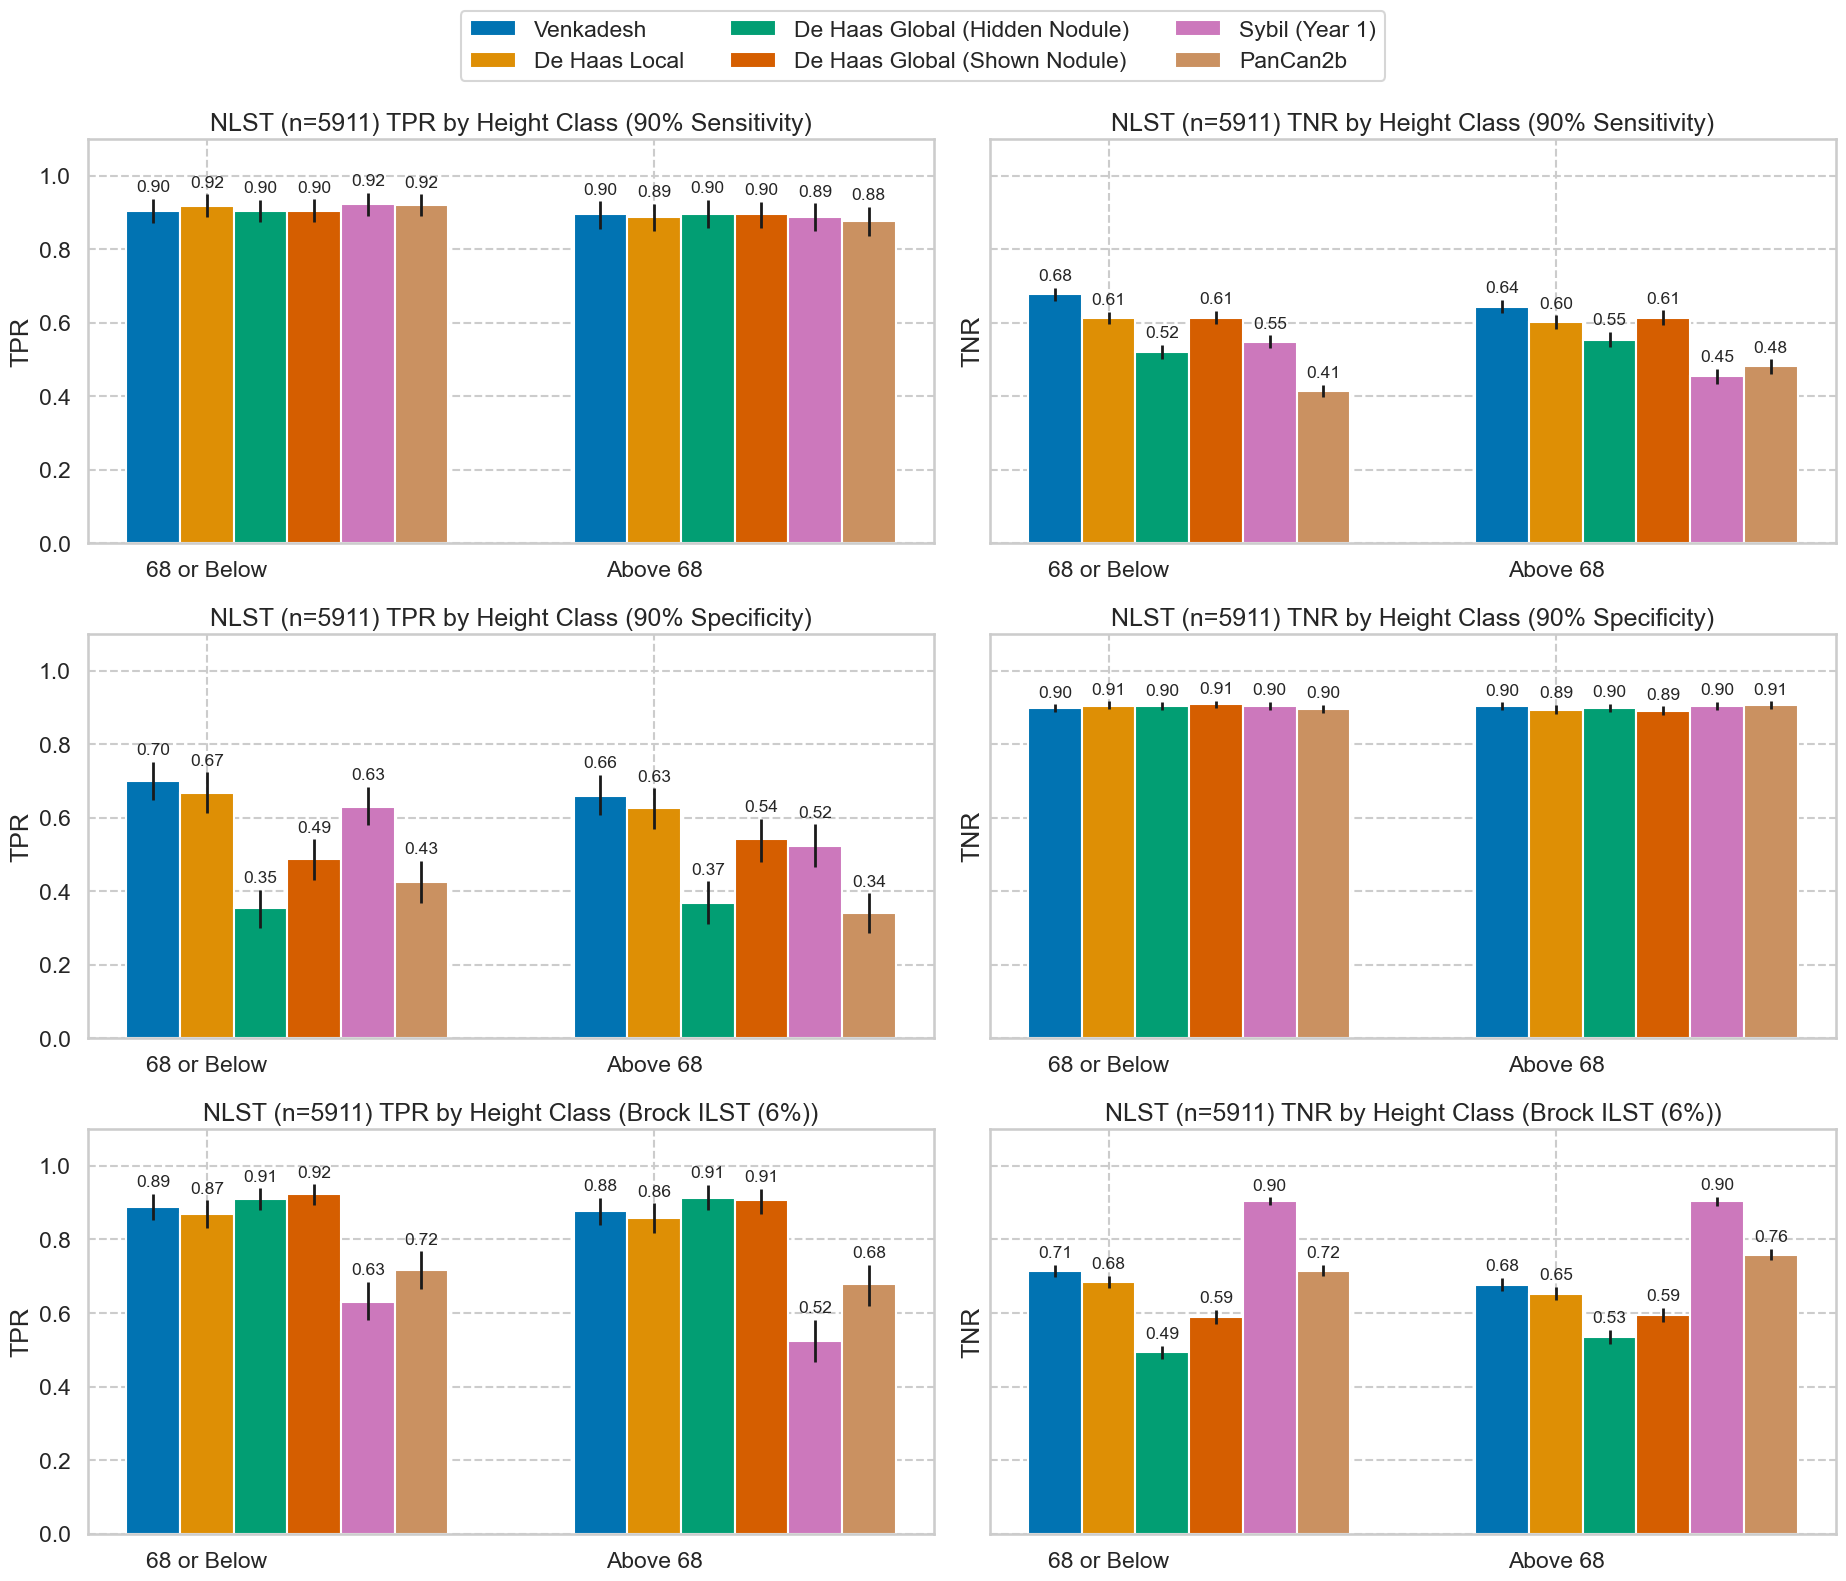

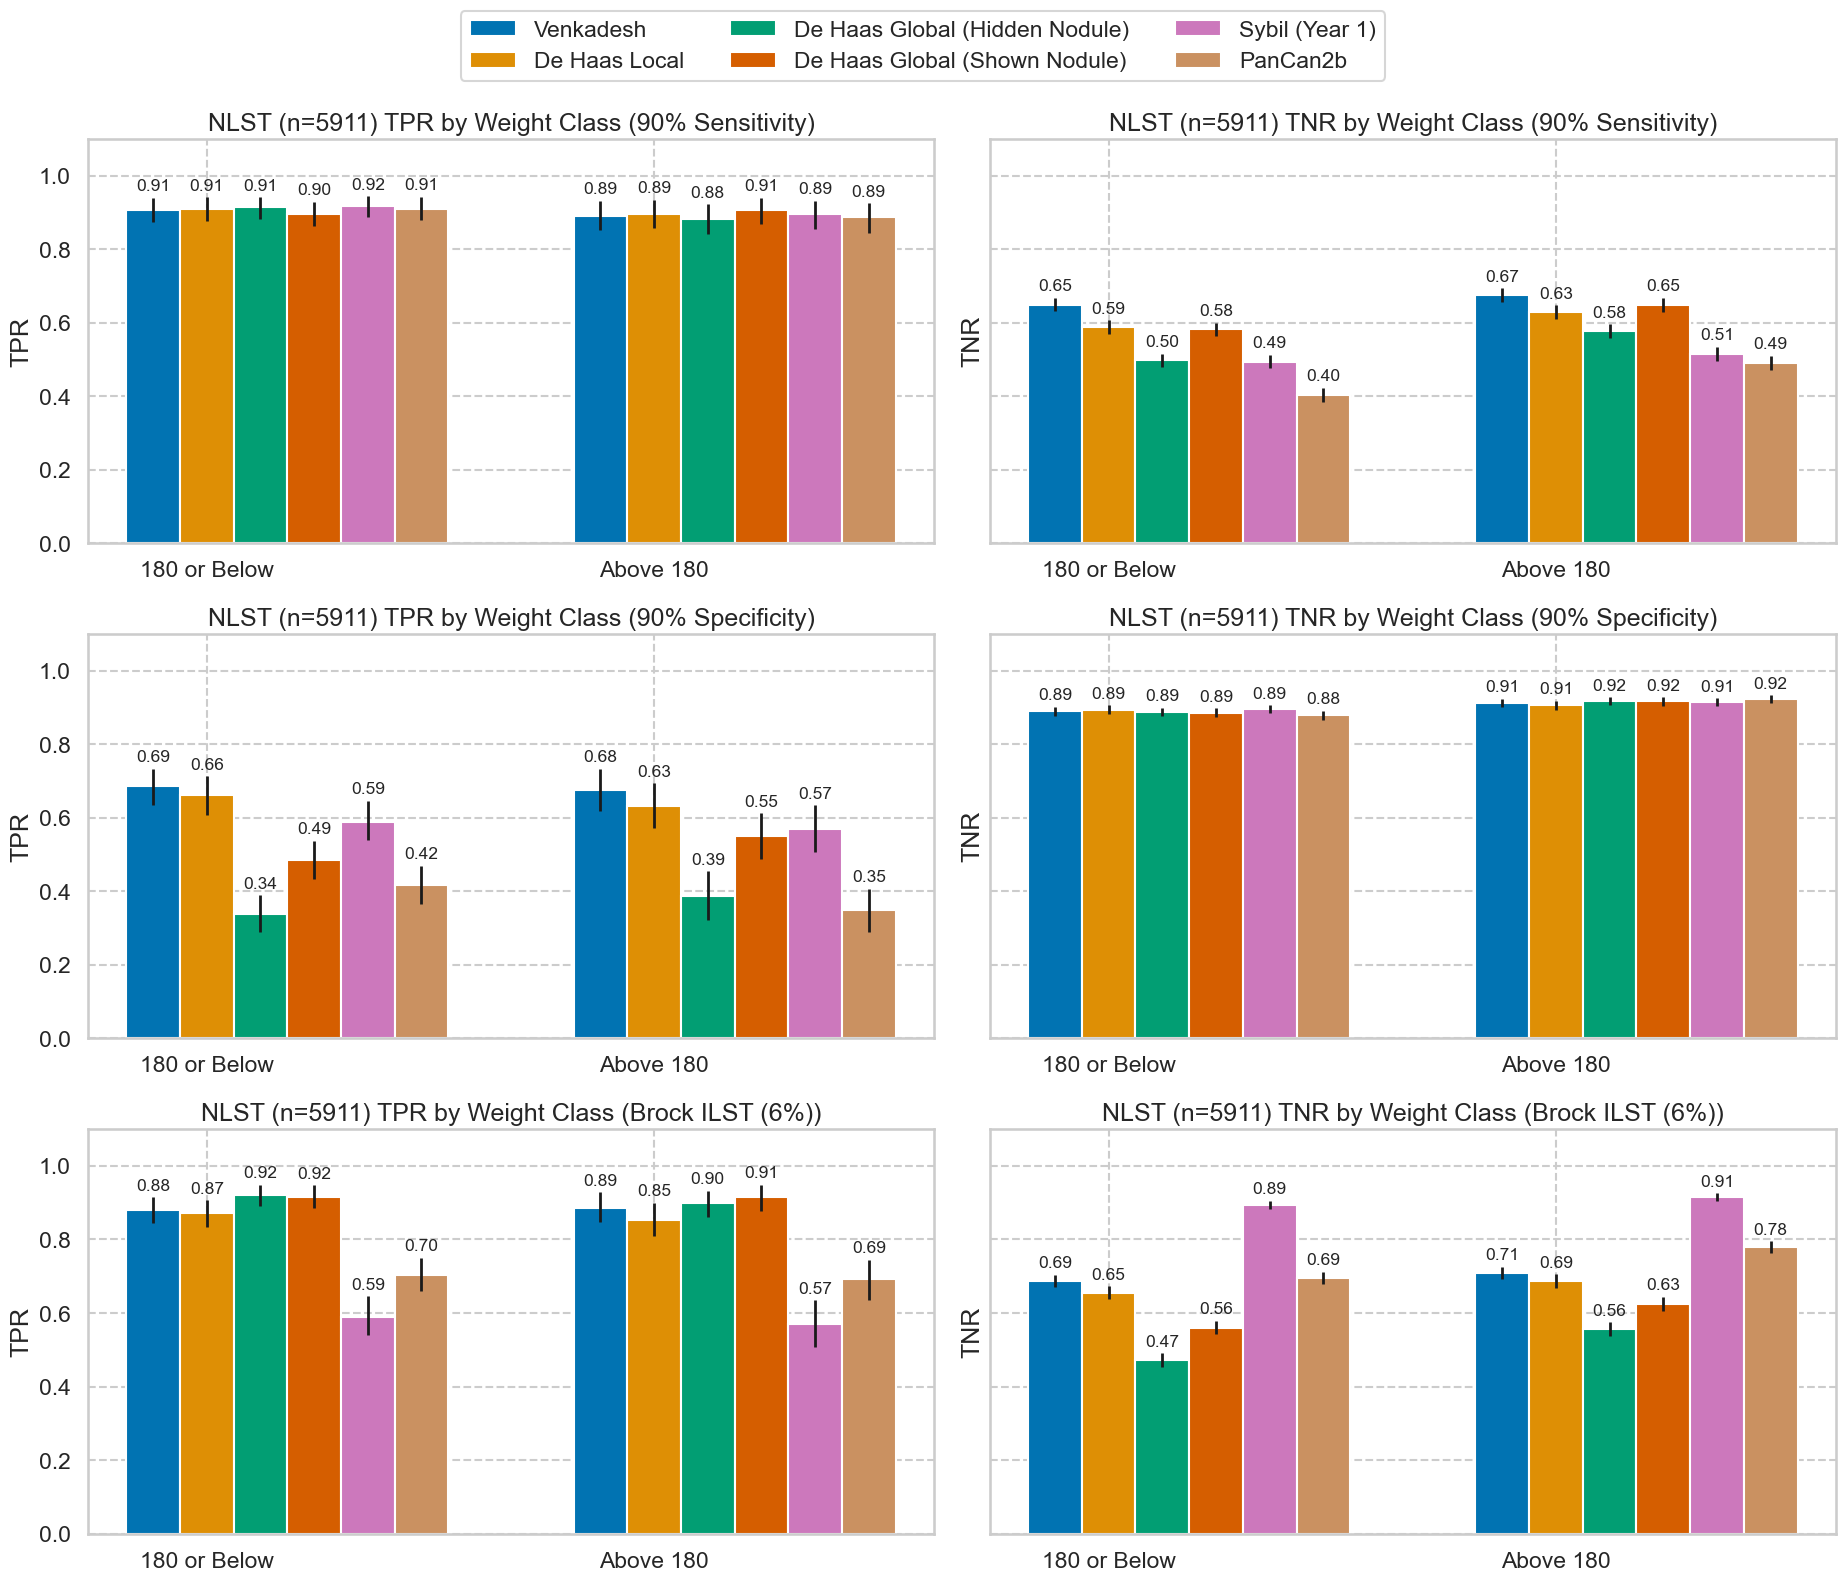

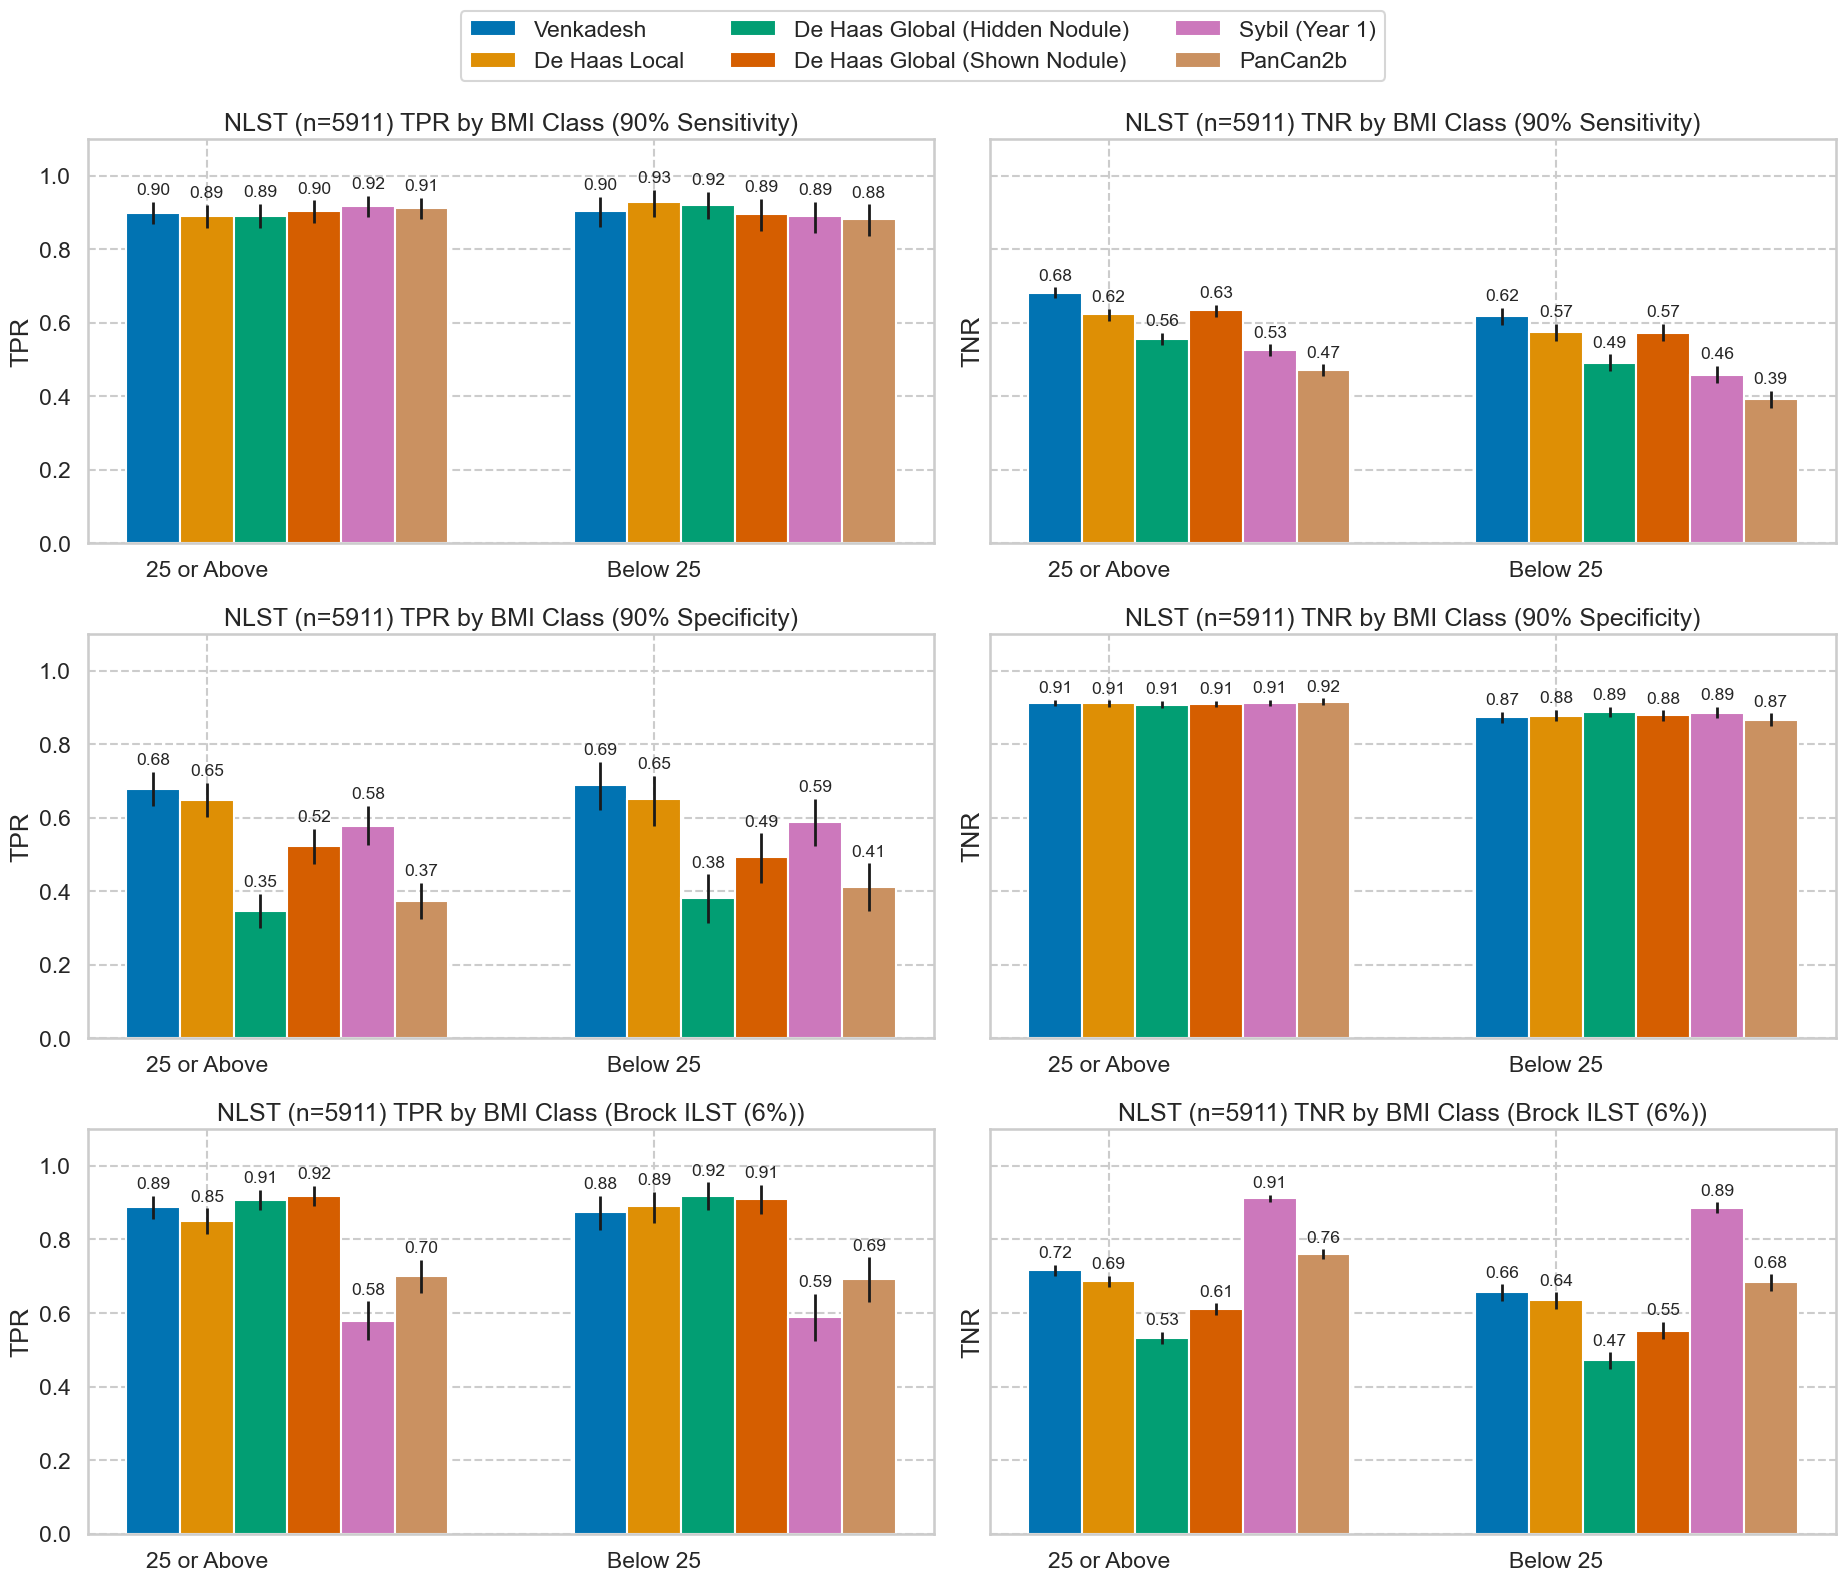

In [48]:
print(nlst_demos_to_include)
for col in nlst_demos_to_include:
    _ = threshold.plot_threshold_stats_subgroups(nlst_5911, col, dataset_name='NLST',
                                                policies=nlst_5911_policies, models=NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "{col}"'),
                                                plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/threshold-NLST-5911/{col}.png"
                                                )  

## Threshold Tables

In [49]:
def metric_outside_ci(val_is_outside_ci):
    return "*" if val_is_outside_ci else ""

def ci_dont_intersect(ci_notouch):
    return "**" if ci_notouch else ""

def check_ci(val_is_outside_ci, ci_notouch):
    if ci_notouch and val_is_outside_ci:
        return "**"
    if ci_notouch and not val_is_outside_ci:
        return "???"
    if val_is_outside_ci and not ci_notouch:
        return "*"
    if not val_is_outside_ci and not ci_notouch:
        return ""

def threshold_results_pretty(df, model_order, metric='FPR', precision=TABLE_SCORE_PRECISION):
    df['model'] = df.apply(lambda row: COL_TO_MODEL[row['col']], axis=1)
    df = df.query('Group_1 != "ALL" & Group_2 != "ALL"').drop_duplicates(subset='comp_id')

    ## Get metric info in nice interval notation.
    df[f'Group_1_{metric}'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1, metric=metric), axis=1)
    df[f'Group_2_{metric}'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2, metric=metric), axis=1)


    df1 = df[['comp_id', 'model', 'policy', 'category', 'attribute', 'Group_1', f'Group_1_{metric}', 'Group_1_mal', f'{metric}_diff']].rename(columns={
        'Group_1': 'Group', f'Group_1_{metric}': metric, 'Group_1_mal': 'Malignant Scans'})
    # df1['CI'] = df1.apply(lambda row: metric_outside_ci(row['CI']), axis=1)
    # df1['CI'] = df1.apply(lambda row: f"{row[f'{metric}_diff']:.{precision}f}", axis=1)
    df1['CI'] = "" * len(df1)
    df1['comp_id'] = df1.apply(lambda row: row['comp_id'].split(row['policy'])[1][1:], axis=1)

    df2 = df[['comp_id', 'model', 'policy', 'category', 'attribute', 'Group_2', f'Group_2_{metric}', 'Group_2_mal', f"{metric}_outside_CI", f"{metric}_CI_notouch"]].rename(columns={
        'Group_2': 'Group', f'Group_2_{metric}': metric, 'Group_2_mal': 'Malignant Scans'})
    df2['CI'] = df2.apply(lambda row: check_ci(row[f"{metric}_outside_CI"], row[f"{metric}_CI_notouch"]), axis=1)
    df2['comp_id'] = df2.apply(lambda row: row['comp_id'].split(row['policy'])[1][1:], axis=1)
    df_res = pd.concat([df1, df2])


    if df_res['category'].iloc[0] in data.rename_types.keys():
        df_res['Category'] = df_res.apply(lambda row: data.rename_types[row['category']], axis=1)
    else:
        df_res['Category'] = df_res['category']
    
    if df_res['attribute'].iloc[0] in data.rename_cols.keys():
        df_res['Attribute'] = df_res.apply(lambda row: prettify_result_val(row['attribute'], row['Group'])[0], axis=1)
        df_res['Group'] = df_res.apply(lambda row: prettify_result_val(row['attribute'], row['Group'])[1], axis=1)
    else:
        df_res['Attribute'] = df_res['attribute']

    df_res = df_res.set_index(pd.MultiIndex.from_frame(df_res[['policy', 'Category', 'Attribute', 'Group']]))
    model_results = {m: dfm[[metric, 'CI']] for m, dfm in df_res.groupby('model')}
    
    df_out = pd.concat(model_results, axis=1)
    df_out['Malignant Scans'] = df_res['Malignant Scans'].drop_duplicates()
    df_out = df_out.sort_values(by='Malignant Scans', ascending=False)
    
    df_out = df_out.sort_index(ascending=True, level=['policy', 'Category', 'Attribute'], sort_remaining=False)[model_order]
    return df_out

### DLCST

In [50]:
dlcst_demos_to_include = ['Age Class', 'Gender']
pairwise_tpr_dlcst = threshold.all_attribute_pairwise_comparisons(threshold_dlcst, metric="TPR")
threshold_tpr_dlcst = threshold_results_pretty(pairwise_tpr_dlcst, model_order=list(DLCST_MODELCOLS.keys()), metric='TPR')
tpr_dlcst_demo = threshold_tpr_dlcst.xs("Demographics", level='Category').query('Attribute in @dlcst_demos_to_include & policy in @POLICIES_TO_USE')
tpr_dlcst_demo

Venkadesh     \
                                                     TPR CI   
policy          Attribute Group                               
90% Sensitivity Age Class Above 61     0.94 (0.84, 1.00)      
                          61 or Below  0.89 (0.77, 1.00)      
                Gender    Male         0.88 (0.75, 1.00)      
                          Female       0.96 (0.88, 1.00)      
90% Specificity Age Class Above 61     0.84 (0.70, 0.96)      
                          61 or Below  0.71 (0.55, 0.88)      
                Gender    Male         0.78 (0.64, 0.93)      
                          Female       0.78 (0.62, 0.93)      
Brock ILST (6%) Age Class Above 61     0.94 (0.84, 1.00)      
                          61 or Below  0.96 (0.88, 1.00)      
                Gender    Male         0.91 (0.79, 1.00)      
                          Female       1.00 (1.00, 1.00)  *   

                                        De Haas Combined      \
                                                     TPR  CI   
policy          Attribute Group                                
90% Sensitivity Age Class Above 61     0.87 (0.76, 0.97)       
                          61 or Below  0.96 (0.88, 1.00)   *   
                Gender    Male         0.84 (0.70, 0.96)       
                          Female       1.00 (1.00, 1.00)  **   
90% Specificity Age Class Above 61     0.81 (0.67, 0.94)       
                          61 or Below  0.75 (0.58, 0.90)       
                Gender    Male         0.75 (0.59, 0.90)       
                          Female       0.81 (0.67, 0.96)       
Brock ILST (6%) Age Class Above 61     0.94 (0.84, 1.00)       
                          61 or Below  0.96 (0.88, 1.00)       
                Gender    Male         0.91 (0.79, 1.00)       
                          Female       1.00 (1.00, 1.00)   *   

                                                PanCan2b     \
                                                     TPR CI   
policy          Attribute Group                               
90% Sensitivity Age Class Above 61     0.87 (0.75, 0.97)      
                          61 or Below  0.96 (0.88, 1.00)  *   
                Gender    Male         0.88 (0.75, 0.97)      
                          Female       0.96 (0.88, 1.00)  *   
90% Specificity Age Class Above 61     0.71 (0.54, 0.87)      
                          61 or Below  0.61 (0.43, 0.79)      
                Gender    Male         0.66 (0.48, 0.82)      
                          Female       0.67 (0.48, 0.84)      
Brock ILST (6%) Age Class Above 61     0.71 (0.54, 0.87)      
                          61 or Below  0.68 (0.50, 0.85)      
                Gender    Male         0.69 (0.52, 0.85)      
                          Female       0.70 (0.52, 0.88)      

                                          Sybil (Year 1)     
                                                     TPR CI  
policy          Attribute Group                              
90% Sensitivity Age Class Above 61     0.97 (0.89, 1.00)     
                          61 or Below  0.96 (0.88, 1.00)     
                Gender    Male         0.94 (0.84, 1.00)     
                          Female       1.00 (1.00, 1.00)  *  
90% Specificity Age Class Above 61     0.71 (0.55, 0.86)     
                          61 or Below  0.61 (0.42, 0.77)     
                Gender    Male         0.72 (0.56, 0.88)     
                          Female       0.59 (0.41, 0.78)     
Brock ILST (6%) Age Class Above 61     0.65 (0.48, 0.82)     
                          61 or Below  0.39 (0.22, 0.57)  *  
                Gender    Male         0.56 (0.39, 0.73)     
                          Female       0.48 (0.30, 0.68)

In [91]:
print(tpr_dlcst_demo.style.format(na_rep='', escape='latex-math').format_index(escape='latex-math', axis=1).format_index(escape='latex-math', axis=0).to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoTPR.tex",
    hrules=True, label='tab:resDLCSTdemoTPR', environment='table*', column_format=f'lll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (TPR) with 95\% Confidence Intervals (CI) for models on demographic characteristics when evaluated on the DLCST validation set (n=599 scans). Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [52]:
pairwise_tnr_dlcst = threshold.all_attribute_pairwise_comparisons(threshold_dlcst, metric='TNR')
threshold_tnr_dlcst = threshold_results_pretty(pairwise_tnr_dlcst, model_order=list(DLCST_MODELCOLS.keys()), metric='TNR')
tnr_dlcst_demo = threshold_tnr_dlcst.xs("Demographics", level='Category').query('Attribute in @dlcst_demos_to_include & policy in @POLICIES_TO_USE')
tnr_dlcst_demo

Venkadesh      \
                                                     TNR  CI   
policy          Attribute Group                                
90% Sensitivity Age Class Above 61     0.83 (0.77, 0.89)       
                          61 or Below  0.87 (0.83, 0.90)       
                Gender    Male         0.88 (0.84, 0.92)       
                          Female       0.83 (0.78, 0.87)   *   
90% Specificity Age Class Above 61     0.86 (0.81, 0.92)       
                          61 or Below  0.91 (0.88, 0.94)   *   
                Gender    Male         0.92 (0.89, 0.95)       
                          Female       0.88 (0.83, 0.91)   *   
Brock ILST (6%) Age Class Above 61     0.69 (0.61, 0.76)       
                          61 or Below  0.73 (0.68, 0.78)       
                Gender    Male         0.77 (0.72, 0.82)       
                          Female       0.66 (0.60, 0.72)  **   

                                        De Haas Combined     \
                                                     TNR CI   
policy          Attribute Group                               
90% Sensitivity Age Class Above 61     0.77 (0.70, 0.84)      
                          61 or Below  0.78 (0.74, 0.82)      
                Gender    Male         0.81 (0.76, 0.85)      
                          Female       0.75 (0.69, 0.80)  *   
90% Specificity Age Class Above 61     0.85 (0.79, 0.91)      
                          61 or Below  0.92 (0.89, 0.94)  *   
                Gender    Male         0.90 (0.87, 0.93)      
                          Female       0.90 (0.86, 0.93)      
Brock ILST (6%) Age Class Above 61     0.68 (0.59, 0.75)      
                          61 or Below  0.67 (0.62, 0.72)      
                Gender    Male         0.70 (0.64, 0.75)      
                          Female       0.64 (0.59, 0.70)  *   

                                                PanCan2b      \
                                                     TNR  CI   
policy          Attribute Group                                
90% Sensitivity Age Class Above 61     0.65 (0.57, 0.73)       
                          61 or Below  0.72 (0.68, 0.76)   *   
                Gender    Male         0.78 (0.74, 0.83)       
                          Female       0.61 (0.55, 0.66)  **   
90% Specificity Age Class Above 61     0.84 (0.78, 0.90)       
                          61 or Below  0.92 (0.89, 0.95)   *   
                Gender    Male         0.93 (0.90, 0.96)       
                          Female       0.86 (0.81, 0.90)  **   
Brock ILST (6%) Age Class Above 61     0.80 (0.73, 0.86)       
                          61 or Below  0.86 (0.83, 0.90)   *   
                Gender    Male         0.89 (0.86, 0.92)       
                          Female       0.80 (0.74, 0.84)  **   

                                          Sybil (Year 1)     
                                                     TNR CI  
policy          Attribute Group                              
90% Sensitivity Age Class Above 61     0.13 (0.08, 0.18)     
                          61 or Below  0.17 (0.14, 0.21)  *  
                Gender    Male         0.16 (0.13, 0.21)     
                          Female       0.16 (0.11, 0.20)     
90% Specificity Age Class Above 61     0.86 (0.80, 0.92)     
                          61 or Below  0.93 (0.90, 0.95)  *  
                Gender    Male         0.93 (0.90, 0.96)     
                          Female       0.89 (0.85, 0.92)  *  
Brock ILST (6%) Age Class Above 61     0.93 (0.89, 0.97)     
                          61 or Below  0.96 (0.94, 0.98)  *  
                Gender    Male         0.95 (0.92, 0.97)     
                          Female       0.96 (0.93, 0.98)

In [90]:
print(tnr_dlcst_demo.style.format(na_rep='', escape='latex-math').format_index(escape='latex-math', axis=1).format_index(escape='latex-math', axis=0).to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoTNR.tex",
    hrules=True, label='tab:resDLCSTdemoTNR', environment='table*', column_format=f'lll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (TNR) with 95\% Confidence Intervals (CI) for models on demographic characteristics when evaluated on the DLCST validation set (n=599 scans). Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


### NLST 1172

In [74]:
pairwise_tpr_1172 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_1172, metric="TPR")
threshold_tpr = threshold_results_pretty(pairwise_tpr_1172, model_order=list(NLST_1172_MODELCOLS.keys()), metric='TPR')

In [98]:
set(invalid_attributes_1172).intersection(set(nlst_demos_to_include))

{'HS Education', 'Race'}

In [82]:
tpr_demo_1172 = threshold_tpr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_1172')
tpr_demo_1172 = tpr_demo_1172[['De Haas Combined', 'De Haas Local', 'De Haas Global (Hidden Nodule)']]
tpr_demo_1172

De Haas Combined     \
                                                         TPR CI   
policy          Attribute    Group                                
90% Sensitivity Age Class    Above 61      0.90 (0.82, 0.96)      
                             61 or Below   0.92 (0.83, 0.98)      
                BMI Class    25 or Above   0.89 (0.82, 0.95)      
                             Below 25      0.93 (0.86, 1.00)      
                Gender       Male          0.91 (0.84, 0.97)      
                             Female        0.90 (0.80, 0.98)      
                Height Class Above 68      0.90 (0.82, 0.97)      
                             68 or Below   0.91 (0.83, 0.98)      
                Weight Class 180 or Below  0.89 (0.81, 0.96)      
                             Above 180     0.93 (0.86, 0.98)      
90% Specificity Age Class    Above 61      0.60 (0.49, 0.72)      
                             61 or Below   0.67 (0.53, 0.80)      
                BMI Class    25 or Above   0.61 (0.51, 0.71)      
                             Below 25      0.67 (0.53, 0.80)      
                Gender       Male          0.59 (0.48, 0.71)      
                             Female        0.69 (0.56, 0.82)      
                Height Class Above 68      0.60 (0.48, 0.71)      
                             68 or Below   0.67 (0.54, 0.79)      
                Weight Class 180 or Below  0.68 (0.58, 0.79)      
                             Above 180     0.56 (0.42, 0.69)  *   
Brock ILST (6%) Age Class    Above 61      0.90 (0.82, 0.96)      
                             61 or Below   0.92 (0.83, 0.98)      
                BMI Class    25 or Above   0.89 (0.82, 0.95)      
                             Below 25      0.93 (0.86, 1.00)      
                Gender       Male          0.91 (0.84, 0.97)      
                             Female        0.90 (0.80, 0.98)      
                Height Class Above 68      0.90 (0.82, 0.97)      
                             68 or Below   0.91 (0.83, 0.98)      
                Weight Class 180 or Below  0.89 (0.81, 0.96)      
                             Above 180     0.93 (0.86, 0.98)      

                                               De Haas Local     \
                                                         TPR CI   
policy          Attribute    Group                                
90% Sensitivity Age Class    Above 61      0.90 (0.83, 0.96)      
                             61 or Below   0.92 (0.83, 0.98)      
                BMI Class    25 or Above   0.90 (0.84, 0.96)      
                             Below 25      0.91 (0.82, 0.98)      
                Gender       Male          0.91 (0.84, 0.97)      
                             Female        0.90 (0.80, 0.98)      
                Height Class Above 68      0.90 (0.83, 0.97)      
                             68 or Below   0.91 (0.84, 0.98)      
                Weight Class 180 or Below  0.89 (0.81, 0.96)      
                             Above 180     0.93 (0.86, 0.98)      
90% Specificity Age Class    Above 61      0.64 (0.53, 0.74)      
                             61 or Below   0.63 (0.49, 0.76)      
                BMI Class    25 or Above   0.62 (0.52, 0.72)      
                             Below 25      0.67 (0.52, 0.80)      
                Gender       Male          0.61 (0.50, 0.72)      
                             Female        0.69 (0.55, 0.82)      
                Height Class Above 68      0.59 (0.47, 0.70)      
                             68 or Below   0.70 (0.59, 0.82)  *   
                Weight Class 180 or Below  0.67 (0.56, 0.78)      
                             Above 180     0.59 (0.46, 0.72)      
Brock ILST (6%) Age Class    Above 61      0.85 (0.76, 0.92)      
                             61 or Below   0.90 (0.80, 0.98)      
                BMI Class    25 or Above   0.88 (0.81, 0.95)      
                             Below 25      0.84 (0.73, 0.94)      
                Gender 

In [99]:
print(tpr_demo_1172.style.format(na_rep='', escape='latex-math').format_index(escape='latex-math', axis=1).format_index(escape='latex-math', axis=0).to_latex(
    buf=f"{TAB_DIR}/resNLSTtijmenTPR.tex",
    hrules=True, label='tab:resNLSTtijmenTPR', environment='table*', column_format=f'lll{"|ll"*3}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (TPR) with 95\% Confidence Intervals (CI) for the De Haas Combined model and its submodels on demographic characteristics when evaluated on the partial NLST validation set (n=1172 scans). Race and High School Education analysis are not included since there are less than 15 malignant scans in the underrepresented subgroup. Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [95]:
pairwise_tnr_1172 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_1172, metric='TNR')
tnr_1172 = threshold_results_pretty(pairwise_tnr_1172, model_order=list(NLST_1172_MODELCOLS.keys()), metric='TNR')
tnr_1172.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_1172')

Venkadesh      \
                                                         TNR  CI   
policy          Attribute    Group                                 
90% Sensitivity Age Class    Above 61      0.52 (0.48, 0.56)       
                             61 or Below   0.56 (0.52, 0.61)   *   
                BMI Class    25 or Above   0.57 (0.53, 0.61)       
                             Below 25      0.46 (0.41, 0.52)  **   
                Gender       Male          0.54 (0.50, 0.58)       
                             Female        0.53 (0.48, 0.57)       
                Height Class Above 68      0.55 (0.52, 0.59)       
                             68 or Below   0.52 (0.47, 0.56)       
                Weight Class 180 or Below  0.50 (0.46, 0.54)       
                             Above 180     0.57 (0.53, 0.62)   *   
90% Specificity Age Class    Above 61      0.88 (0.86, 0.91)       
                             61 or Below   0.92 (0.90, 0.94)   *   
                BMI Class    25 or Above   0.92 (0.90, 0.94)       
                             Below 25      0.86 (0.82, 0.89)  **   
                Gender       Male          0.91 (0.89, 0.93)       
                             Female        0.88 (0.85, 0.91)   *   
                Height Class Above 68      0.92 (0.90, 0.95)       
                             68 or Below   0.88 (0.85, 0.90)   *   
                Weight Class 180 or Below  0.88 (0.86, 0.91)       
                             Above 180     0.92 (0.89, 0.94)   *   
Brock ILST (6%) Age Class    Above 61      0.65 (0.62, 0.69)       
                             61 or Below   0.71 (0.67, 0.75)   *   
                BMI Class    25 or Above   0.70 (0.67, 0.74)       
                             Below 25      0.62 (0.57, 0.67)   *   
                Gender       Male          0.68 (0.64, 0.71)       
                             Female        0.68 (0.64, 0.72)       
                Height Class Above 68      0.70 (0.66, 0.73)       
                             68 or Below   0.66 (0.62, 0.70)       
                Weight Class 180 or Below  0.65 (0.61, 0.69)       
                             Above 180     0.70 (0.66, 0.74)   *   

                                            De Haas Combined      \
                                                         TNR  CI   
policy          Attribute    Group                                 
90% Sensitivity Age Class    Above 61      0.62 (0.58, 0.66)       
                             61 or Below   0.65 (0.61, 0.69)       
                BMI Class    25 or Above   0.66 (0.63, 0.70)       
                             Below 25      0.57 (0.52, 0.62)  **   
                Gender       Male          0.66 (0.63, 0.70)       
                             Female        0.60 (0.55, 0.64)   *   
                Height Class Above 68      0.66 (0.62, 0.70)       
                             68 or Below   0.61 (0.57, 0.65)   *   
                Weight Class 180 or Below  0.59 (0.56, 0.64)       
                             Above 180     0.68 (0.63, 0.72)   *   
90% Specificity Age Class    Above 61      0.91 (0.89, 0.94)       
                             61 or Below   0.88 (0.85, 0.91)   *   
                BMI Class    25 or Above   0.91 (0.88, 0.93)       
                             Below 25      0.89 (0.85, 0.92)       
                Gender       Male          0.90 (0.88, 0.93)       
                             Female        0.90 (0.87, 0.93)       
                Height Class Above 68      0.90 (0.87, 0.93)       
                             68 or Below   0.90 (0.87, 0.93)       
                Weight Class 180 or Below  0.89 (0.86, 0.91)       
                             Above 180     0.91 (0.89, 0.94)   *   
Brock ILST (6%) Age Class    Above 61      0.61 (0.57, 0.64)       
                             61 or Below   0.62 (0.57, 0.66)       
                BMI Class    25 or Above   0.64 (0.60, 0.68)       
                             Below 25 

In [96]:
tnr_demo_1172 = tnr_1172.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_1172')
tnr_demo_1172 = tnr_demo_1172[['De Haas Combined', 'De Haas Local', 'De Haas Global (Hidden Nodule)']]
tnr_demo_1172

De Haas Combined      \
                                                         TNR  CI   
policy          Attribute    Group                                 
90% Sensitivity Age Class    Above 61      0.62 (0.58, 0.66)       
                             61 or Below   0.65 (0.61, 0.69)       
                BMI Class    25 or Above   0.66 (0.63, 0.70)       
                             Below 25      0.57 (0.52, 0.62)  **   
                Gender       Male          0.66 (0.63, 0.70)       
                             Female        0.60 (0.55, 0.64)   *   
                Height Class Above 68      0.66 (0.62, 0.70)       
                             68 or Below   0.61 (0.57, 0.65)   *   
                Weight Class 180 or Below  0.59 (0.56, 0.64)       
                             Above 180     0.68 (0.63, 0.72)   *   
90% Specificity Age Class    Above 61      0.91 (0.89, 0.94)       
                             61 or Below   0.88 (0.85, 0.91)   *   
                BMI Class    25 or Above   0.91 (0.88, 0.93)       
                             Below 25      0.89 (0.85, 0.92)       
                Gender       Male          0.90 (0.88, 0.93)       
                             Female        0.90 (0.87, 0.93)       
                Height Class Above 68      0.90 (0.87, 0.93)       
                             68 or Below   0.90 (0.87, 0.93)       
                Weight Class 180 or Below  0.89 (0.86, 0.91)       
                             Above 180     0.91 (0.89, 0.94)   *   
Brock ILST (6%) Age Class    Above 61      0.61 (0.57, 0.64)       
                             61 or Below   0.62 (0.57, 0.66)       
                BMI Class    25 or Above   0.64 (0.60, 0.68)       
                             Below 25      0.54 (0.49, 0.60)  **   
                Gender       Male          0.64 (0.60, 0.67)       
                             Female        0.57 (0.52, 0.62)   *   
                Height Class Above 68      0.63 (0.59, 0.68)       
                             68 or Below   0.59 (0.55, 0.63)   *   
                Weight Class 180 or Below  0.57 (0.54, 0.62)       
                             Above 180     0.65 (0.61, 0.69)   *   

                                               De Haas Local     \
                                                         TNR CI   
policy          Attribute    Group                                
90% Sensitivity Age Class    Above 61      0.60 (0.56, 0.64)      
                             61 or Below   0.63 (0.59, 0.67)      
                BMI Class    25 or Above   0.64 (0.60, 0.67)      
                             Below 25      0.56 (0.51, 0.61)  *   
                Gender       Male          0.62 (0.58, 0.66)      
                             Female        0.60 (0.55, 0.64)      
                Height Class Above 68      0.62 (0.57, 0.66)      
                             68 or Below   0.61 (0.57, 0.64)      
                Weight Class 180 or Below  0.60 (0.56, 0.64)      
                             Above 180     0.62 (0.58, 0.67)      
90% Specificity Age Class    Above 61      0.89 (0.86, 0.91)      
                             61 or Below   0.92 (0.90, 0.95)  *   
                BMI Class    25 or Above   0.92 (0.90, 0.94)      
                             Below 25      0.87 (0.83, 0.90)  *   
                Gender       Male          0.91 (0.89, 0.93)      
                             Female        0.89 (0.86, 0.92)  *   
                Height Class Above 68      0.92 (0.89, 0.94)      
                             68 or Below   0.89 (0.86, 0.91)  *   
                Weight Class 180 or Below  0.89 (0.86, 0.91)      
                             Above 180     0.91 (0.89, 0.94)      
Brock ILST (6%) Age Class    Above 61      0.64 (0.60, 0.67)      
                             61 or Below   0.67 (0.62, 0.71)      
                BMI Class    25 or Above   0.68 (0.64, 0.71)      
                             Below 25      0.59 (0.54, 0.

In [100]:
print(tnr_demo_1172.style.format(na_rep='', escape='latex-math').format_index(escape='latex-math', axis=1).format_index(escape='latex-math', axis=0).to_latex(
    buf=f"{TAB_DIR}/resNLSTtijmenTNR.tex",
    hrules=True, label='tab:resNLSTtijmenTNR', environment='table*', column_format=f'lll{"|ll"*3}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (TNR) with 95\% Confidence Intervals (CI) for the De Haas Combined model and its submodels on demographic characteristics when evaluated on the partial NLST validation set (n=1172 scans). Race and High School Education analysis are not included since there are less than 15 malignant scans in the underrepresented subgroup. Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


### NLST 5911

In [56]:
nlst_demos_to_include

['Age Class',
 'Gender',
 'Race',
 'HS Education',
 'Height Class',
 'Weight Class',
 'BMI Class']

In [57]:
pairwise_tpr_5911 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_5911, metric="TPR")
threshold_tpr = threshold_results_pretty(pairwise_tpr_5911, model_order=list(NLST_5911_MODELCOLS.keys()), metric='TPR')
threshold_tpr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')

Venkadesh      \
                                                         TPR  CI   
policy          Attribute    Group                                 
90% Sensitivity Age Class    Above 61      0.90 (0.86, 0.93)       
                             61 or Below   0.91 (0.87, 0.94)       
                BMI Class    25 or Above   0.90 (0.87, 0.93)       
                             Below 25      0.90 (0.86, 0.94)       
                Gender       Male          0.90 (0.87, 0.93)       
                             Female        0.90 (0.86, 0.93)       
                Height Class 68 or Below   0.90 (0.87, 0.94)       
                             Above 68      0.90 (0.85, 0.93)       
                Race         White         0.90 (0.88, 0.93)       
                             Black         0.82 (0.67, 0.96)   *   
                Weight Class 180 or Below  0.91 (0.87, 0.94)       
                             Above 180     0.89 (0.85, 0.93)       
90% Specificity Age Class    Above 61      0.70 (0.66, 0.75)       
                             61 or Below   0.65 (0.58, 0.71)   *   
                BMI Class    25 or Above   0.68 (0.63, 0.72)       
                             Below 25      0.69 (0.62, 0.75)       
                Gender       Male          0.66 (0.61, 0.71)       
                             Female        0.71 (0.65, 0.77)       
                Height Class 68 or Below   0.70 (0.65, 0.75)       
                             Above 68      0.66 (0.61, 0.72)       
                Race         White         0.69 (0.65, 0.73)       
                             Black         0.39 (0.23, 0.59)  **   
                Weight Class 180 or Below  0.69 (0.64, 0.73)       
                             Above 180     0.68 (0.62, 0.73)       
Brock ILST (6%) Age Class    Above 61      0.88 (0.84, 0.91)       
                             61 or Below   0.89 (0.85, 0.93)       
                BMI Class    25 or Above   0.89 (0.86, 0.92)       
                             Below 25      0.88 (0.83, 0.92)       
                Gender       Male          0.88 (0.85, 0.91)       
                             Female        0.89 (0.85, 0.92)       
                Height Class 68 or Below   0.89 (0.85, 0.92)       
                             Above 68      0.88 (0.84, 0.91)       
                Race         White         0.89 (0.86, 0.91)       
                             Black         0.75 (0.59, 0.91)   *   
                Weight Class 180 or Below  0.88 (0.84, 0.91)       
                             Above 180     0.89 (0.85, 0.93)       

                                               De Haas Local     \
                                                         TPR CI   
policy          Attribute    Group                                
90% Sensitivity Age Class    Above 61      0.90 (0.87, 0.93)      
                             61 or Below   0.91 (0.88, 0.95)      
                BMI Class    25 or Above   0.89 (0.86, 0.92)      
                             Below 25      0.93 (0.89, 0.96)  *   
                Gender       Male          0.89 (0.86, 0.92)      
                             Female        0.92 (0.89, 0.95)      
                Height Class 68 or Below   0.92 (0.89, 0.95)      
                             Above 68      0.89 (0.85, 0.92)  *   
                Race         White         0.90 (0.87, 0.93)      
                             Black         0.89 (0.77, 1.00)      
                Weight Class 180 or Below  0.91 (0.88, 0.94)      
                             Above 180     0.89 (0.86, 0.93)      
90% Specificity Age Class    Above 61      0.67 (0.62, 0.71)      
                             61 or Below   0.62 (0.56, 0.68)      
                BMI Class    25 or Above   0.65 (0.60, 0.70)      
                             Below 25      0.65 (0.58, 0.71)      
                Gender       Male          0.64 (0.59, 0.68)      
                             Female        0.67 (0.61, 0.7

In [58]:
pairwise_tnr_5911 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_5911, metric="TNR")
threshold_tnr = threshold_results_pretty(pairwise_tnr_5911, model_order=list(NLST_5911_MODELCOLS.keys()), metric='TNR')
threshold_tnr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')

Venkadesh      \
                                                         TNR  CI   
policy          Attribute    Group                                 
90% Sensitivity Age Class    Above 61      0.63 (0.62, 0.65)       
                             61 or Below   0.70 (0.68, 0.71)  **   
                BMI Class    25 or Above   0.68 (0.67, 0.70)       
                             Below 25      0.62 (0.59, 0.64)  **   
                Gender       Male          0.65 (0.63, 0.66)       
                             Female        0.68 (0.66, 0.70)   *   
                Height Class 68 or Below   0.68 (0.66, 0.69)       
                             Above 68      0.64 (0.63, 0.66)   *   
                Race         White         0.66 (0.65, 0.67)       
                             Black         0.73 (0.66, 0.79)   *   
                Weight Class 180 or Below  0.65 (0.63, 0.67)       
                             Above 180     0.67 (0.66, 0.69)   *   
90% Specificity Age Class    Above 61      0.88 (0.87, 0.89)       
                             61 or Below   0.92 (0.91, 0.93)  **   
                BMI Class    25 or Above   0.91 (0.90, 0.92)       
                             Below 25      0.87 (0.86, 0.89)  **   
                Gender       Male          0.90 (0.89, 0.91)       
                             Female        0.90 (0.88, 0.91)       
                Height Class 68 or Below   0.90 (0.89, 0.91)       
                             Above 68      0.90 (0.89, 0.91)       
                Race         White         0.90 (0.89, 0.91)       
                             Black         0.93 (0.89, 0.97)   *   
                Weight Class 180 or Below  0.89 (0.88, 0.90)       
                             Above 180     0.91 (0.90, 0.92)  **   
Brock ILST (6%) Age Class    Above 61      0.67 (0.65, 0.69)       
                             61 or Below   0.73 (0.71, 0.75)  **   
                BMI Class    25 or Above   0.72 (0.70, 0.73)       
                             Below 25      0.66 (0.63, 0.68)  **   
                Gender       Male          0.68 (0.66, 0.70)       
                             Female        0.72 (0.70, 0.74)  **   
                Height Class 68 or Below   0.71 (0.70, 0.73)       
                             Above 68      0.68 (0.66, 0.70)  **   
                Race         White         0.70 (0.68, 0.71)       
                             Black         0.76 (0.69, 0.82)   *   
                Weight Class 180 or Below  0.69 (0.67, 0.70)       
                             Above 180     0.71 (0.69, 0.73)   *   

                                               De Haas Local      \
                                                         TNR  CI   
policy          Attribute    Group                                 
90% Sensitivity Age Class    Above 61      0.59 (0.57, 0.60)       
                             61 or Below   0.63 (0.61, 0.65)  **   
                BMI Class    25 or Above   0.62 (0.61, 0.64)       
                             Below 25      0.57 (0.55, 0.60)  **   
                Gender       Male          0.61 (0.59, 0.63)       
                             Female        0.61 (0.59, 0.63)       
                Height Class 68 or Below   0.61 (0.60, 0.63)       
                             Above 68      0.60 (0.58, 0.62)       
                Race         White         0.61 (0.59, 0.62)       
                             Black         0.59 (0.52, 0.66)   *   
                Weight Class 180 or Below  0.59 (0.57, 0.61)       
                             Above 180     0.63 (0.61, 0.65)  **   
90% Specificity Age Class    Above 61      0.89 (0.88, 0.90)       
                             61 or Below   0.92 (0.90, 0.93)  **   
                BMI Class    25 or Above   0.91 (0.90, 0.92)       
                             Below 25      0.88 (0.86, 0.89)  **   
                Gender       Male          0.90 (0.89, 0.91)       
                             Female   

## Demographic Confounder Links

In [59]:
def num_with_percent(x, s, precision):
    return f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], precision)})'

def confounders_by_attribute(df, attribute, cols, precision=1):
    dfsets = {val: dfv for val, dfv in df.groupby(attribute)}
    subgroups = list(dfsets.keys())
    subgroups_pretty_key = {sg: prettify_result_val(attribute, sg)[1] for sg in subgroups}

    cat_df = data.combine_diff_dfs(cols['cat'], data.diffs_category_prevalence, dfsets)
    for s in dfsets:
        cat_df[f"{subgroups_pretty_key[s]} Prevalence (\%)"] = cat_df.apply(lambda x: num_with_percent(x, s, precision), axis=1)

    cat_df = cat_df[pd.notna(cat_df['value'])]
    cat_df['category'] = cat_df.apply(lambda row: data.rename_types[row['category']], axis=1)
    cat_df['attribute2'] = cat_df.apply(lambda row: prettify_result_val(row['attribute'], row['value'])[0], axis=1)
    cat_df['value'] = cat_df.apply(lambda row: prettify_result_val(row['attribute'], row['value'])[1], axis=1)
    cat_df['attribute'] = cat_df['attribute2']
    cat_df = cat_df.set_index(pd.MultiIndex.from_frame(cat_df[['category', 'attribute', 'value']]))

    cat_df = cat_df[cat_df['attribute'] != attribute]
    cat_df = cat_df[[f"{subgroups_pretty_key[s]} Prevalence (\%)" for s in subgroups] + [f"diff_{s1}_{s2}" for s1, s2 in itertools.combinations(subgroups, 2)]]
    # cat_df = cat_df.sort_values(by=f"diff_{subgroups[0]}_{subgroups[1]}", ascending=True)
    cat_df = cat_df.sort_index(ascending=True)

    num_df = data.combine_diff_dfs(cols['num'], data.diffs_numerical_means, dfsets)
    num_df['category'] = num_df.apply(lambda row: data.rename_types[row['category']], axis=1)
    num_df['attribute2'] = num_df.apply(lambda row: prettify_result_val(row['attribute'], row['value'])[0], axis=1)
    num_df['value'] = num_df.apply(lambda row: prettify_result_val(row['attribute'], row['value'])[1], axis=1)
    num_df['attribute'] = num_df['attribute2']
    num_df = num_df.set_index(pd.MultiIndex.from_frame(num_df[['category', 'attribute', 'value']]))

    num_df = num_df[num_df['attribute'] != attribute]
    num_df = num_df[num_df['value'].isin(['Median (IQR)'])]
    num_df = num_df[[f"{s}" for s in subgroups] + [f"diff_{s1}_{s2}" for s1, s2 in itertools.combinations(subgroups, 2)]]
    num_df = num_df.rename(columns={f"{s}": subgroups_pretty_key[s] for s in subgroups})
    # num_df = num_df.sort_values(by=f"diff_{subgroups[0]}_{subgroups[1]}", ascending=True)
    num_df = num_df.sort_index(ascending=True)

    if len(subgroups) == 2:
        rename_diff = {f"diff_{subgroups[0]}_{subgroups[1]}": "Difference"}
        cat_df.rename(columns=rename_diff, inplace=True)
        num_df.rename(columns=rename_diff, inplace=True)
        cat_df["Abs Diff"] = cat_df['Difference'].abs()

    return cat_df, num_df

In [60]:
nlst_5911_v2, nlst_cols_v2, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=False, bin_num=True)
nlst_cols_v2

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'other': ['NoduleCounts', 'Diameter_mm', 'SliceCount']},
 'cat': {'demo': ['Age > 61',
   'Gender',
   'HighSchoolPlus',
   'Married',
   'NonHispanicWhite',
   'Overweight',
   'Unfinished_ed',
   'WhiteOrBlack',
   'educat',
   'ethnic',
   'height > 68',
   'marital',
   'race',
   'weight > 180'],
  'smoke': ['cigar',
   'cigsmok',
   'pipe',
   'pkyr > 55',
   'smokeage > 16',
   'smokeday > 25',
   'smokelive',
   'smokework',
   'smokeyr > 40'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'di

In [61]:
def sort_multiindex_by_attribute(df, col='Abs Diff'):
    attribute_max = df.groupby('attribute')[col].max()
    sorted_attributes = attribute_max.sort_values(ascending=False).index

    df2 = df.reset_index()
    df2['attribute'] = pd.Categorical(df2['attribute'], categories=sorted_attributes, ordered=True)
    df2 = df2.sort_values('attribute')
    df2 = df2.set_index(['category', 'attribute', 'value'])
    return df2 

In [62]:
cat_gender, num_gender = confounders_by_attribute(nlst_5911_v2, 'Gender', nlst_cols_v2)
display(cat_gender)
display(num_gender)

cat_gender = sort_multiindex_by_attribute(cat_gender, 'Abs Diff')
cat_gender

Male Prevalence (\%)  \
category     attribute        value                                    
Demographics Age Class        61 or Below                1461 (42.5)   
                              Above 61                   1980 (57.5)   
             BMI Class        25 or Above                2538 (73.8)   
                              Below 25                    903 (26.2)   
             Education Status 8th grade or less             95 (2.8)   
...                                                              ...   
Work History Painting         1.0                          267 (7.8)   
             Sandblasting     0.0                        3341 (97.1)   
                              1.0                           99 (2.9)   
             Welding          0.0                        3099 (90.1)   
                              1.0                          341 (9.9)   

                                                Female Prevalence (\%)  \
category     attribute        value                                      
Demographics Age Class        61 or Below                  1125 (45.5)   
                              Above 61                     1345 (54.5)   
             BMI Class        25 or Above                  1474 (59.7)   
                              Below 25                      996 (40.3)   
             Education Status 8th grade or less               16 (0.6)   
...                                                                ...   
Work History Painting         1.0                             50 (2.0)   
             Sandblasting     0.0                          2459 (99.6)   
                              1.0                             11 (0.4)   
             Welding          0.0                          2451 (99.2)   
                              1.0                             19 (0.8)   

                                                 Difference  Abs Diff  
category     attribute        value                                    
Demographics Age Class        61 or Below           -3.0880    3.0880  
                              Above 61               3.0880    3.0880  
             BMI Class        25 or Above           14.0815   14.0815  
                              Below 25             -14.0815   14.0815  
             Education Status 8th grade or less      2.1130    2.1130  
...                                                     ...       ...  
Work History Painting         1.0                    5.7351    5.7351  
             Sandblasting     0.0                   -2.4608    2.4608  
                              1.0                    2.4318    2.4318  
             Welding          0.0                   -9.1698    9.1698  
                              1.0                    9.1407    9.1407  

[225 rows x 4 columns]

Male    Female  \
category     attribute                 value                              
Demographics Age                       Median (IQR)    63 (8)    62 (8)   
             BMI                       Median (IQR)    27 (5)    26 (7)   
             Height                    Median (IQR)    71 (3)    64 (3)   
             Weight                    Median (IQR)  192 (46)  157 (45)   
Other        Diameter (mm)             Median (IQR)     7 (5)     7 (4)   
             Nodules Per Scan          Median (IQR)     1 (1)     1 (1)   
             Slices In Scan            Median (IQR)  165 (36)  155 (36)   
Smoking      Age at Smoking Onset      Median (IQR)    16 (4)    17 (4)   
             Cigarettes per Day (avg.) Median (IQR)   30 (20)   20 (10)   
             Pack-Years                Median (IQR)   55 (35)   46 (22)   
             Total Years of Smoking    Median (IQR)   42 (10)    40 (9)   

                                                     Difference  
category     attribute                 value                     
Demographics Age                       Median (IQR)       1.000  
             BMI                       Median (IQR)       0.888  
             Height                    Median (IQR)       7.000  
             Weight                    Median (IQR)      35.000  
Other        Diameter (mm)             Median (IQR)       0.200  
             Nodules Per Scan          Median (IQR)       0.000  
             Slices In Scan            Median (IQR)      10.000  
Smoking      Age at Smoking Onset      Median (IQR)      -1.000  
             Cigarettes per Day (avg.) Median (IQR)      10.000  
             Pack-Years                Median (IQR)       9.000  
             Total Years of Smoking    Median (IQR)       2.000

Male Prevalence (\%)  \
category     attribute          value                               
Demographics Height Class       Above 68              2621 (76.2)   
                                68 or Below            820 (23.8)   
             Weight Class       180 or Below          1215 (35.3)   
                                Above 180             2226 (64.7)   
Smoking      Smoked Pipe        1.0                   1256 (36.5)   
...                                                           ...   
Nodule       Non-Solid          True                     31 (0.9)   
             Calcified          True                      3 (0.1)   
                                False                 3438 (99.9)   
Demographics Non-Hispanic White False                   280 (8.1)   
                                True                  3161 (91.9)   

                                             Female Prevalence (\%)  \
category     attribute          value                                 
Demographics Height Class       Above 68                  146 (5.9)   
                                68 or Below             2324 (94.1)   
             Weight Class       180 or Below            1880 (76.1)   
                                Above 180                590 (23.9)   
Smoking      Smoked Pipe        1.0                        45 (1.8)   
...                                                             ...   
Nodule       Non-Solid          True                       22 (0.9)   
             Calcified          True                        2 (0.1)   
                                False                   2468 (99.9)   
Demographics Non-Hispanic White False                     201 (8.1)   
                                True                    2269 (91.9)   

                                              Difference  Abs Diff  
category     attribute          value                               
Demographics Height Class       Above 68         70.2588   70.2588  
                                68 or Below     -70.2588   70.2588  
             Weight Class       180 or Below    -40.8039   40.8039  
                                Above 180        40.8039   40.8039  
Smoking      Smoked Pipe        1.0              34.6791   34.6791  
...                                                  ...       ...  
Nodule       Non-Solid          True              0.0102    0.0102  
             Calcified          True              0.0062    0.0062  
                                False            -0.0062    0.0062  
Demographics Non-Hispanic White False            -0.0005    0.0005  
                                True              0.0005    0.0005  

[225 rows x 4 columns]

In [63]:
# nlst_5911_v2, nlst_cols_v2, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
cat_race, num_race = confounders_by_attribute(nlst_5911_v2, 'WhiteOrBlack', nlst_cols_v2)

## ROC isolating for confounders

In [64]:
def roc_isolations_pretty(df0, attribute, model, precision=TABLE_SCORE_PRECISION):
    df = df0.rename(index=model_column_rename)
    df.reset_index(inplace=True, names='model')
    df = df.query(f'model == "{model}"')

    ## Get AUC info in nice interval notation.
    df['Group_1_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1), axis=1)
    df['Group_2_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2), axis=1)

    df['Category'] = df.apply(lambda row: data.rename_types[row['category']], axis=1)
    df['Confounder'] = df.apply(lambda row: prettify_result_val(row['filter_by'], row['filter_val'])[0], axis=1)
    df['Subset'] = df.apply(lambda row: prettify_result_val(row['filter_by'], row['filter_val'])[1], axis=1)
    df['P'] = df.apply(lambda row: data.truncate_p(row['p']), axis=1)
    df = df.set_index(pd.MultiIndex.from_frame(df[['Category', 'Confounder', 'Subset']]))

    ## Get list of subgroups.
    subgroups = list(set(list(pd.unique(df['Group_1'])) + list(pd.unique(df['Group_2']))))
    subgroups_pretty_key = {sg: prettify_result_val(attribute, sg)[1] for sg in subgroups}
    
    ## Group 1 and Group 2 don't necessarily always align. We need to realign them.
    # cols_to_realign = ['mal', 'ben', 'pct', 'pct_mal', 'AUC']
    cols_to_realign = ['AUC']
    def realign_group_num(row, subgroup, col='AUC'):
        if row['Group_1'] == subgroup:
            return row[f'Group_1_{col}']
        if row['Group_2'] == subgroup:
            return row[f'Group_2_{col}']
        else: 
            return None
    
    for sg in subgroups:
        for c in cols_to_realign:
            df[f"{subgroups_pretty_key[sg]} {c}"] = df.apply(lambda row: realign_group_num(row, sg, c), axis=1)
    
    df2 = df[[f"{subgroups_pretty_key[sg]} {col}" for sg, col in itertools.product(subgroups, cols_to_realign)]]
    multicol = pd.MultiIndex.from_tuples(list(itertools.product(list(subgroups_pretty_key.values()), cols_to_realign)))
    df2.columns = multicol
    df2['P'] = df['P']
    # df = df[['p'] + [f"{subgroups_pretty_key[sg]} AUC" for sg in subgroups]]
    return df2

In [65]:
# def prevalence_plus_isolated_roc(dataset, attribute, cols, results, model, data_precision=1, result_precision=TABLE_SCORE_PRECISION):
#     cat_prev, _ = confounders_by_attribute(dataset, attribute, cols, precision=data_precision)
#     roc_results = roc_isolations_pretty(results, attribute, model, precision=result_precision)
#     combined_df = pd.concat([cat_prev, roc_results], axis=1).dropna(axis=0)

#     subgroups = list(set(list(pd.unique(results['Group_1'])) + list(pd.unique(results['Group_2']))))
#     subgroups_pretty = [prettify_result_val(attribute, sg)[1] for sg in subgroups]
#     subcols_to_align = ["Prevalence (\\%)", 'AUC', 'mal', 'ben', 'pct', 'pct_mal']
#     other_cols = ['Difference', 'Abs Diff', 'p', 'P', 'AUC_diff']

#     combined_df = combined_df[[f"{s} {c}" for s, c in itertools.product(subgroups_pretty, subcols_to_align)] + other_cols]
#     multicol_idx = pd.MultiIndex.from_tuples(list(itertools.product(subgroups_pretty, subcols_to_align))).append(pd.Index(other_cols))
#     combined_df.columns = multicol_idx

#     return combined_df

In [66]:
gender_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-gender-by-factors-nlst-5911.csv', index_col=0)
gender_roc_pretty = roc_isolations_pretty(gender_roc, 'Gender', 'Sybil (Year 1)')
gender_roc_pretty

C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\597238936.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_1_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\597238936.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_2_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\597238936.py:10: SettingWithCopyWarning: 
A value i

Male             Female  \
                                                      AUC                AUC   
Category     Confounder   Subset                                               
Demographics Age Class    61 or Below   0.79 (0.74, 0.83)  0.91 (0.87, 0.94)   
                          Above 61      0.82 (0.79, 0.85)  0.86 (0.83, 0.89)   
             HS Education 1.0           0.81 (0.78, 0.84)  0.88 (0.86, 0.91)   
             Married      0.0           0.80 (0.75, 0.85)  0.91 (0.89, 0.94)   
                          1.0           0.81 (0.78, 0.84)  0.85 (0.81, 0.88)   
...                                                   ...                ...   
Scanner      Model Name   Mx8000        0.72 (0.62, 0.81)  0.90 (0.84, 0.96)   
                          Sensation 16  0.84 (0.76, 0.90)  0.86 (0.80, 0.92)   
                          Sensation 4   0.98 (0.96, 1.00)  0.96 (0.89, 1.00)   
                          Sensation 64  0.82 (0.64, 0.99)  0.95 (0.83, 1.00)   
                          Volume Zoom   0.85 (0.80, 0.90)  0.93 (0.88, 0.97)   

                                             P  
                                                
Category     Confounder   Subset                
Demographics Age Class    61 or Below   < .001  
                          Above 61         .14  
             HS Education 1.0           < .001  
             Married      0.0             .001  
                          1.0              .18  
...                                        ...  
Scanner      Model Name   Mx8000          .004  
                          Sensation 16     .60  
                          Sensation 4      .75  
                          Sensation 64     .37  
                          Volume Zoom      .05  

[157 rows x 3 columns]

In [67]:
race_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-race-by-factors-nlst-5911.csv', index_col=0)
race_roc_pretty = roc_isolations_pretty(race_roc, 'WhiteOrBlack', 'Venkadesh')
race_roc_pretty

C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\597238936.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_1_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\597238936.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_2_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\597238936.py:10: SettingWithCopyWarning: 
A value i

White  \
                                                          AUC   
Category     Confounder   Subset                                
Demographics Age Class    61 or Below       0.90 (0.88, 0.92)   
                          Above 61          0.88 (0.86, 0.90)   
             Gender       Male              0.89 (0.87, 0.91)   
                          Female            0.89 (0.87, 0.91)   
             HS Education 0.0               0.79 (0.36, 1.00)   
...                                                       ...   
Scanner      Model Name   LightSpeed QX/i   0.90 (0.87, 0.93)   
                          LightSpeed Ultra  0.75 (0.64, 0.84)   
                          LightSpeed16      0.88 (0.83, 0.93)   
                          Sensation 16      0.91 (0.87, 0.94)   
                          Volume Zoom       0.91 (0.87, 0.94)   

                                                        Black     P  
                                                          AUC        
Category     Confounder   Subset                                     
Demographics Age Class    61 or Below       0.88 (0.79, 0.96)   .74  
                          Above 61          0.78 (0.65, 0.90)   .13  
             Gender       Male              0.81 (0.66, 0.93)   .24  
                          Female            0.84 (0.75, 0.92)   .40  
             HS Education 0.0               0.32 (0.00, 1.00)  None  
...                                                       ...   ...  
Scanner      Model Name   LightSpeed QX/i   0.99 (1.00, 1.00)  .003  
                          LightSpeed Ultra  0.67 (0.38, 0.90)   .74  
                          LightSpeed16      0.81 (0.60, 0.97)   .47  
                          Sensation 16      0.74 (0.56, 0.92)   .12  
                          Volume Zoom       0.95 (0.88, 1.00)   .68  

[135 rows x 3 columns]

In [68]:
overweight_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-overweight-by-factors-nlst-5911.csv', index_col=0)
overweight_roc_pretty = roc_isolations_pretty(overweight_roc, 'Overweight', 'Sybil (Year 1)')
overweight_roc_pretty

C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\597238936.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_1_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\597238936.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_2_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\597238936.py:10: SettingWithCopyWarning: 
A value i

Below 25        25 or Above  \
                                                      AUC                AUC   
Category     Confounder   Subset                                               
Demographics Age Class    61 or Below   0.83 (0.79, 0.88)  0.85 (0.82, 0.89)   
                          Above 61      0.80 (0.75, 0.84)  0.86 (0.83, 0.88)   
             Gender       Male          0.76 (0.70, 0.82)  0.83 (0.80, 0.86)   
                          Female        0.85 (0.81, 0.89)  0.90 (0.87, 0.93)   
             HS Education 0.0           0.72 (0.37, 1.00)  0.73 (0.42, 1.00)   
...                                                   ...                ...   
Scanner      Model Name   LightSpeed16  0.79 (0.67, 0.90)  0.80 (0.71, 0.87)   
                          Mx8000        0.71 (0.57, 0.84)  0.84 (0.76, 0.90)   
                          Sensation 16  0.76 (0.68, 0.85)  0.91 (0.86, 0.95)   
                          Sensation 64  0.91 (0.70, 1.00)  0.86 (0.69, 1.00)   
                          Volume Zoom   0.86 (0.79, 0.91)  0.90 (0.86, 0.94)   

                                           P  
                                              
Category     Confounder   Subset              
Demographics Age Class    61 or Below    .58  
                          Above 61       .03  
             Gender       Male           .03  
                          Female         .11  
             HS Education 0.0            .96  
...                                      ...  
Scanner      Model Name   LightSpeed16   .93  
                          Mx8000         .08  
                          Sensation 16  .002  
                          Sensation 64   .77  
                          Volume Zoom    .34  

[161 rows x 3 columns]

## Thresholds, isolating for confounders

In [69]:
def threshold_isolations_pretty(df, model, demographic='Gender', metric='TPR', precision=TABLE_SCORE_PRECISION):
    df['model'] = df.apply(lambda row: COL_TO_MODEL[row['col']], axis=1)
    df = df.query(f'model == "{model}" & Group_1 != "ALL" & Group_2 != "ALL"')
    df = df.sort_values(by=['comp_id', 'Group_1'], ascending=False).drop_duplicates(subset='comp_id')

    if df['Group_1'].nunique() > 1 or df['Group_2'].nunique() > 1:
        print("ERROR: probably did not do top2=True in the pairwise comparisons.")
        return None
    
    g1, g2 = pd.unique(df['Group_1'])[0], pd.unique(df['Group_2'])[0]

    ## Get metric info in nice interval notation.
    df[f'{g1} {metric}'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1, metric=metric), axis=1)
    df[f'{g2} {metric}'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2, metric=metric), axis=1)
    df['CI Check'] = df.apply(lambda row: check_ci(row[f'{metric}_outside_CI'], row[f'{metric}_CI_notouch']), axis=1)

    if df['category'].iloc[0] in data.rename_types.keys():
        df['Category'] = df.apply(lambda row: data.rename_types[row['category']], axis=1)
    else:
        df['Category'] = df['category']
    
    if df['filter_by'].iloc[0] in data.rename_cols.keys():
        df['Confounder'] = df.apply(lambda row: prettify_result_val(row['filter_by'], row['filter_val'])[0], axis=1)
        df['Subset'] = df.apply(lambda row: prettify_result_val(row['filter_by'], row['filter_val'])[1], axis=1)
    else:
        df['Confounder'] = df['filter_by']
        df['Subset'] = df['filter_val']
    
    df = df.set_index(pd.MultiIndex.from_frame(df[['policy', 'Category', 'Confounder', 'Subset']]))
    df = df.sort_index(ascending=True, level=['policy', 'Category', 'Confounder', 'Subset'], sort_remaining=False)
    
    df2 = df[[f"{sg} {col}" for sg, col in itertools.product([g1, g2], [metric])]]
    multicol = pd.MultiIndex.from_tuples(list(itertools.product([g1, g2], [metric])))
    df2.columns = multicol
    df2['CI Check'] = df['CI Check']
    return df2

In [70]:
thresholds_isolating_gender = pd.read_csv(f'{RESULTS_DIR}/threshold-gender-by-factors-nlst-5911.csv', index_col=0)
thresholds_isolating_gender, _ = threshold_stats_pretty(thresholds_isolating_gender, nlst_5911_policies, demographic_for_isolations='Gender')

gender_isolation_tpr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_gender, metric="TPR")
gender_iso_tpr_pretty = threshold_isolations_pretty(gender_isolation_tpr_5911, model='Sybil (Year 1)', metric='TPR')

gender_isolation_tnr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_gender, metric="TNR")
gender_iso_tnr_pretty = threshold_isolations_pretty(gender_isolation_tnr_5911, model='Sybil (Year 1)', metric='TNR')

display(gender_iso_tpr_pretty)
display(gender_iso_tnr_pretty)

C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\4291728630.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['CI Check'] = df['CI Check']
C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\4291728630.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['CI Check'] = df['CI Check']


Male  \
                                                                               TPR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        61 or Below        0.88 (0.81, 0.94)   
                                              Above 61           0.91 (0.86, 0.94)   
                             BMI Class        25 or Above        0.91 (0.87, 0.94)   
                                              Below 25           0.87 (0.80, 0.93)   
                             Education Status 8th grade or less  0.88 (0.60, 1.00)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.54 (0.35, 0.70)   
                             Sandblasting     0.0                0.53 (0.47, 0.58)   
                                              1.0                0.57 (0.33, 0.78)   
                             Welding          0.0                0.53 (0.46, 0.58)   
                                              1.0                0.56 (0.41, 0.72)   

                                                                            Female  \
                                                                               TPR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        61 or Below        0.93 (0.88, 0.97)   
                                              Above 61           0.92 (0.87, 0.96)   
                             BMI Class        25 or Above        0.94 (0.89, 0.98)   
                                              Below 25           0.91 (0.85, 0.95)   
                             Education Status 8th grade or less  1.00 (1.00, 1.00)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.00 (0.00, 0.00)   
                             Sandblasting     0.0                0.66 (0.60, 0.72)   
                                              1.0                0.00 (0.00, 0.00)   
                             Welding          0.0                0.66 (0.60, 0.72)   
                                              1.0                0.00 (0.00, 0.00)   

                                                                CI Check  
                                                                          
policy          Category     Confounder       Subset                      
90% Sensitivity Demographics Age Class        61 or Below                 
                                              Above 61                    
                             BMI Class        25 or Above                 
                                              Below 25                    
                             Education Status 8th grade or less        *  
...                                                                  ...  
Brock ILST (6%) Work History Painting         1.0                     **  
                             Sandblasting     0.0                     **  
                                              1.0                     **  
                             Welding          0.0                     **  
                                              1.0                     **  

[642 rows x 3 columns]

Male  \
                                                                               TNR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        61 or Below        0.51 (0.49, 0.54)   
                                              Above 61           0.42 (0.40, 0.45)   
                             BMI Class        25 or Above        0.48 (0.46, 0.50)   
                                              Below 25           0.41 (0.38, 0.44)   
                             Education Status 8th grade or less  0.37 (0.27, 0.47)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.87 (0.82, 0.91)   
                             Sandblasting     0.0                0.91 (0.89, 0.92)   
                                              1.0                0.88 (0.81, 0.95)   
                             Welding          0.0                0.91 (0.90, 0.92)   
                                              1.0                0.87 (0.84, 0.91)   

                                                                            Female  \
                                                                               TNR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        61 or Below        0.64 (0.61, 0.67)   
                                              Above 61           0.49 (0.46, 0.52)   
                             BMI Class        25 or Above        0.60 (0.57, 0.62)   
                                              Below 25           0.51 (0.47, 0.54)   
                             Education Status 8th grade or less  0.07 (0.00, 0.23)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.82 (0.70, 0.92)   
                             Sandblasting     0.0                0.90 (0.89, 0.92)   
                                              1.0                0.80 (0.55, 1.00)   
                             Welding          0.0                0.90 (0.89, 0.91)   
                                              1.0                0.94 (0.83, 1.00)   

                                                                CI Check  
                                                                          
policy          Category     Confounder       Subset                      
90% Sensitivity Demographics Age Class        61 or Below             **  
                                              Above 61                **  
                             BMI Class        25 or Above             **  
                                              Below 25                **  
                             Education Status 8th grade or less       **  
...                                                                  ...  
Brock ILST (6%) Work History Painting         1.0                      *  
                             Sandblasting     0.0                         
                                              1.0                      *  
                             Welding          0.0                         
                                              1.0                      *  

[642 rows x 3 columns]

In [71]:
thresholds_isolating_race = pd.read_csv(f'{RESULTS_DIR}/threshold-race-by-factors-nlst-5911.csv', index_col=0)
thresholds_isolating_race, _ = threshold_stats_pretty(thresholds_isolating_race, nlst_5911_policies, demographic_for_isolations='WhiteOrBlack')

race_isolation_tpr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_race, metric="TPR")
race_iso_tpr_pretty = threshold_isolations_pretty(race_isolation_tpr_5911, model='Venkadesh', metric='TPR')

race_isolation_tnr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_race, metric="TNR")
race_iso_tnr_pretty = threshold_isolations_pretty(race_isolation_tnr_5911, model='Venkadesh', metric='TNR')

display(race_iso_tpr_pretty)
display(race_iso_tnr_pretty)

C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\4291728630.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['CI Check'] = df['CI Check']
C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\4291728630.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['CI Check'] = df['CI Check']


White  \
                                                                               TPR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        61 or Below        0.90 (0.86, 0.94)   
                                              Above 61           0.90 (0.87, 0.93)   
                             BMI Class        25 or Above        0.90 (0.87, 0.93)   
                                              Below 25           0.91 (0.87, 0.95)   
                             Education Status 8th grade or less  0.75 (0.00, 1.00)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.94 (0.84, 1.00)   
                             Sandblasting     0.0                0.89 (0.86, 0.92)   
                                              1.0                0.72 (0.50, 0.92)   
                             Welding          0.0                0.88 (0.85, 0.91)   
                                              1.0                0.97 (0.90, 1.00)   

                                                                             Black  \
                                                                               TPR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        61 or Below        0.92 (0.70, 1.00)   
                                              Above 61           0.75 (0.50, 0.94)   
                             BMI Class        25 or Above        0.84 (0.65, 1.00)   
                                              Below 25           0.78 (0.44, 1.00)   
                             Education Status 8th grade or less  0.50 (0.00, 1.00)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                1.00 (1.00, 1.00)   
                             Sandblasting     0.0                0.74 (0.56, 0.90)   
                                              1.0                1.00 (1.00, 1.00)   
                             Welding          0.0                0.72 (0.52, 0.89)   
                                              1.0                1.00 (1.00, 1.00)   

                                                                CI Check  
                                                                          
policy          Category     Confounder       Subset                      
90% Sensitivity Demographics Age Class        61 or Below                 
                                              Above 61                 *  
                             BMI Class        25 or Above              *  
                                              Below 25                 *  
                             Education Status 8th grade or less           
...                                                                  ...  
Brock ILST (6%) Work History Painting         1.0                      *  
                             Sandblasting     0.0                      *  
                                              1.0                     **  
                             Welding          0.0                      *  
                                              1.0                      *  

[579 rows x 3 columns]

White  \
                                                                               TNR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        61 or Below        0.69 (0.68, 0.71)   
                                              Above 61           0.63 (0.61, 0.65)   
                             BMI Class        25 or Above        0.68 (0.66, 0.69)   
                                              Below 25           0.62 (0.60, 0.64)   
                             Education Status 8th grade or less  0.51 (0.40, 0.62)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.63 (0.57, 0.68)   
                             Sandblasting     0.0                0.70 (0.68, 0.71)   
                                              1.0                0.59 (0.48, 0.70)   
                             Welding          0.0                0.70 (0.68, 0.71)   
                                              1.0                0.67 (0.61, 0.72)   

                                                                             Black  \
                                                                               TNR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        61 or Below        0.74 (0.64, 0.85)   
                                              Above 61           0.72 (0.62, 0.81)   
                             BMI Class        25 or Above        0.73 (0.64, 0.81)   
                                              Below 25           0.73 (0.60, 0.85)   
                             Education Status 8th grade or less  1.00 (1.00, 1.00)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.55 (0.25, 0.82)   
                             Sandblasting     0.0                0.76 (0.70, 0.82)   
                                              1.0                0.00 (0.00, 0.00)   
                             Welding          0.0                0.75 (0.68, 0.82)   
                                              1.0                0.83 (0.50, 1.00)   

                                                                CI Check  
                                                                          
policy          Category     Confounder       Subset                      
90% Sensitivity Demographics Age Class        61 or Below              *  
                                              Above 61                 *  
                             BMI Class        25 or Above              *  
                                              Below 25                 *  
                             Education Status 8th grade or less       **  
...                                                                  ...  
Brock ILST (6%) Work History Painting         1.0                      *  
                             Sandblasting     0.0                      *  
                                              1.0                     **  
                             Welding          0.0                      *  
                                              1.0                      *  

[579 rows x 3 columns]

In [72]:
thresholds_isolating_overweight = pd.read_csv(f'{RESULTS_DIR}/threshold-overweight-by-factors-nlst-5911.csv', index_col=0)
thresholds_isolating_overweight, _ = threshold_stats_pretty(thresholds_isolating_overweight, nlst_5911_policies, demographic_for_isolations='Overweight')

overweight_isolation_tpr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_overweight, metric="TPR")
overweight_iso_tpr_pretty = threshold_isolations_pretty(overweight_isolation_tpr_5911, model='Sybil (Year 1)', metric='TPR')

overweight_isolation_tnr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_overweight, metric="TNR")
overweight_iso_tnr_pretty = threshold_isolations_pretty(overweight_isolation_tnr_5911, model='Sybil (Year 1)', metric='TNR')

display(overweight_iso_tpr_pretty)
display(overweight_iso_tnr_pretty)

C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\4291728630.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['CI Check'] = df['CI Check']
C:\Users\shaur\AppData\Local\Temp\ipykernel_2120\4291728630.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['CI Check'] = df['CI Check']


Below 25  \
                                                                               TPR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        61 or Below        0.91 (0.84, 0.97)   
                                              Above 61           0.88 (0.82, 0.93)   
                             Education Status 8th grade or less  1.00 (1.00, 1.00)   
                                              9th-11th grade     0.90 (0.67, 1.00)   
                                              Associate Degree   0.96 (0.90, 1.00)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.33 (0.12, 0.56)   
                             Sandblasting     0.0                0.60 (0.54, 0.67)   
                                              1.0                0.33 (0.00, 0.70)   
                             Welding          0.0                0.61 (0.54, 0.68)   
                                              1.0                0.20 (0.00, 0.50)   

                                                                       25 or Above  \
                                                                               TPR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        61 or Below        0.90 (0.85, 0.94)   
                                              Above 61           0.93 (0.90, 0.96)   
                             Education Status 8th grade or less  0.83 (0.50, 1.00)   
                                              9th-11th grade     0.91 (0.77, 1.00)   
                                              Associate Degree   0.91 (0.84, 0.97)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.72 (0.50, 0.92)   
                             Sandblasting     0.0                0.57 (0.52, 0.62)   
                                              1.0                0.69 (0.40, 0.92)   
                             Welding          0.0                0.57 (0.52, 0.62)   
                                              1.0                0.67 (0.50, 0.83)   

                                                                CI Check  
                                                                          
policy          Category     Confounder       Subset                      
90% Sensitivity Demographics Age Class        61 or Below                 
                                              Above 61                 *  
                             Education Status 8th grade or less        *  
                                              9th-11th grade              
                                              Associate Degree            
...                                                                  ...  
Brock ILST (6%) Work History Painting         1.0                      *  
                             Sandblasting     0.0                         
                                              1.0                      *  
                             Welding          0.0                         
                                              1.0                      *  

[642 rows x 3 columns]

Below 25  \
                                                                               TNR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        61 or Below        0.53 (0.49, 0.56)   
                                              Above 61           0.41 (0.37, 0.44)   
                             Education Status 8th grade or less  0.32 (0.18, 0.46)   
                                              9th-11th grade     0.38 (0.27, 0.49)   
                                              Associate Degree   0.48 (0.43, 0.52)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.75 (0.66, 0.84)   
                             Sandblasting     0.0                0.89 (0.87, 0.90)   
                                              1.0                0.81 (0.61, 1.00)   
                             Welding          0.0                0.89 (0.87, 0.90)   
                                              1.0                0.86 (0.77, 0.93)   

                                                                       25 or Above  \
                                                                               TNR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        61 or Below        0.59 (0.56, 0.61)   
                                              Above 61           0.47 (0.45, 0.50)   
                             Education Status 8th grade or less  0.33 (0.20, 0.45)   
                                              9th-11th grade     0.38 (0.31, 0.46)   
                                              Associate Degree   0.52 (0.49, 0.55)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.91 (0.86, 0.94)   
                             Sandblasting     0.0                0.91 (0.90, 0.92)   
                                              1.0                0.89 (0.81, 0.96)   
                             Welding          0.0                0.91 (0.91, 0.92)   
                                              1.0                0.88 (0.84, 0.93)   

                                                                CI Check  
                                                                          
policy          Category     Confounder       Subset                      
90% Sensitivity Demographics Age Class        61 or Below             **  
                                              Above 61                **  
                             Education Status 8th grade or less           
                                              9th-11th grade              
                                              Associate Degree         *  
...                                                                  ...  
Brock ILST (6%) Work History Painting         1.0                     **  
                             Sandblasting     0.0                     **  
                                              1.0                         
                             Welding          0.0                     **  
                                              1.0                         

[642 rows x 3 columns]